## Import Libraries and Define Functions

In [5]:
import codecs
import glob
import os
import time
import re
from datetime import datetime
import multiprocessing as mp
from multiprocessing import Pool
try:
    import cPickle as pickle
except:
    import pickle

import pandas as pd
import numpy as np
from scipy import optimize
import scipy as sp
from scipy import stats as stats
import matplotlib.pyplot as plt

import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


term_size=80
# from model_functions import *

In [ ]:
# import pickle

def is_pickleable(obj):
    try:
        pickle.dumps(obj)
    except (pickle.PicklingError, TypeError):
        return False
    return True

def save_workspace(filename, variables_to_save=None, globals_dict=None):
    """
    Save specified variables from the current workspace to a file using pickle.
    
    Parameters:
    - filename: str, the name of the file to save the variables to.
    - variables_to_save: list, the names of the variables to save. If None, all variables are saved.
    - globals_dict: dict, the global environment variables.
    
    Usage:
    save_workspace('workspace.pkl', variables_to_save=['var1', 'var2'], globals_dict=globals())
    """
    
    globals_dict = globals_dict if globals_dict is not None else {}
    
    if variables_to_save is not None:
        data_to_save = {name: globals_dict[name] for name in variables_to_save if is_pickleable(globals_dict[name])}
    else:
        data_to_save = {k: v for k, v in globals_dict.items() if is_pickleable(v) and not (k.startswith('__') and k.endswith('__'))}
    
    with open(filename, 'wb') as f:
        pickle.dump(data_to_save, f)
    
    print(f"Saved variables to {filename}")

def load_workspace(filename):
    """
    Load variables from a file into the current workspace using pickle.
    
    Parameters:
    - filename: str, the name of the file from which to load the variables.
    
    Returns:
    A dictionary with the loaded variables.
    
    Usage:
    loaded_vars = load_workspace('workspace.pkl')
    globals().update(loaded_vars)  # To update the current global workspace with the loaded variables.
    """
    with open(filename, 'rb') as f:
        data_loaded = pickle.load(f)
    
    return data_loaded

# Example usage:
# loaded_vars = load_workspace('workspace.pkl')
# globals().update(loaded_vars)  # This will bring all the variables into the global namespace.



In [6]:
def my_pearsonr(x,y):
    return stats.pearsonr(x,y)[0]
# Generate RL model predictions given outcomes, a learning rate and an initial prediction
#assumes outcomes is a DataFrame, cols=number of trials, rows = number of learning instances
# returns predictions as an np.array with the same shape as outcomes.

def genModelPreds(outcomes,lr,p0):
    pred = np.zeros(outcomes.shape)
    pred[:,0] = p0
    for ii in range(outcomes.shape[1]-1):
        pred[:,ii+1] = pred[:,ii] + lr * (np.array(outcomes.iloc[:,ii]) - pred[:,ii])
    return pred           

def genModelPreds_biasOC_d(outcomes,lr,d,p0):
    outcomes=np.array(outcomes)

    ocsDf = np.zeros(outcomes.shape)
    ocsDf[outcomes==-1]=-d
    ocsDf[outcomes==1]=1-d
        
    pred = np.zeros(outcomes.shape)
    pred[:,0] = p0
    for ii in range(outcomes.shape[1]-1):
        pred[:,ii+1] = pred[:,ii] + lr * (ocsDf[:,ii] - pred[:,ii])
    return pred 

def genModelPreds_biasOC_2LR(outcomes,lr_pos,lr_neg,p0):
    outcomes=np.array(outcomes)

    lrsDf = np.zeros(outcomes.shape)
    lrsDf[outcomes==0]=lr_neg
    lrsDf[outcomes==1]=lr_pos
        
    pred = np.zeros(outcomes.shape)
    pred[:,0] = p0
    for ii in range(outcomes.shape[1]-1):
        pred[:,ii+1] = pred[:,ii] + lrsDf[:,ii] * (outcomes[:,ii] - pred[:,ii])
    return pred 


def calcActProbs(modelPreds, sftmax, chVals=np.arange(5)+1):
    preds=np.array(modelPreds)
    EVs=[preds*i+(1-preds)*-i for i in chVals]
    expEVs_sftmax=[np.exp(np.float64(i)/sftmax) for i in EVs]
    sftmax_denom=np.zeros(expEVs_sftmax[0].shape)
    for i in expEVs_sftmax:
        sftmax_denom+=i
    cols=['ch_{:02d}'.format(i) for i in np.arange(modelPreds.shape[1])+1]
    actProbArr=[pd.DataFrame(i/sftmax_denom, columns=cols) for i in expEVs_sftmax]
    
    return actProbArr

def calcActProbsPosNegOC(modelPreds, sftmax, chVals=np.arange(5)+1):
    preds=np.array(modelPreds)
    EVs=[preds*i for i in chVals]
    expEVs_sftmax=[np.exp(np.float64(i)/sftmax) for i in EVs]
    sftmax_denom=np.zeros(expEVs_sftmax[0].shape)
    for i in expEVs_sftmax:
        sftmax_denom+=i
    cols=['ch_{:02d}'.format(i) for i in np.arange(modelPreds.shape[1])+1]
    actProbArr=[pd.DataFrame(i/sftmax_denom, columns=cols) for i in expEVs_sftmax]
    
    return actProbArr

def genChoices(actProbArr):
    probCh=[np.zeros(actProbArr[0].shape)]
    choices=np.random.random_sample(actProbArr[0].shape)
    for i in range(len(actProbArr)):
        probCh.append(probCh[-1]+actProbArr[i])
        choices[choices<probCh[-1]]=i+1
    
    return choices#, probCh

def calcNegLogLike(choices, actProbs):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    for i in np.arange(len(actProbs)):
        chProbs[choices==i+1]=actProbs[i][choices==i+1]
    
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll, chProbs

def chanceLikelihood(choices, chanceP=0.2):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    
    chProbs[chProbs!=0]=chanceP
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll

def genBetaParams(mu=0.3, sd=0.05):
    alpha=((1-mu)/sd**2 - 1/mu )*mu**2
    beta=alpha*(1/mu-1)
    
    return alpha, beta

def betaMuSd(mu=0.3, sd=0.05, N=1):
    alpha=((1-mu)/sd**2 - 1/mu )*mu**2
    beta=alpha*(1/mu-1)
    
    return np.random.beta(alpha, beta,N)

#single LR sofented with sigmoid and single SM model
def optimizeLR_sft(params, choices, outcomes):
    lrp,sm=params
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    if np.any(np.array((lr,sm))<0) or lr>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds(outcomes,lr,initPred)
    actProbs=calcActProbs(mod, sm)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)


#single LR sofented with sigmoid and fixed SM model
def optimizeLR_sft_fixedSM(params, choices, outcomes, smax=1, initPred=.5):
    lrp=params
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    if lr<0 or smax<0 or lr>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds(outcomes,lr,initPred)
    actProbs=calcActProbs(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)

#single LR sofented with sigmoid and fixed SM model
def optimizeLR_sft_fixedSM_posNegOC(params, choices, outcomes, smax=1, initPred=0):
    lrp,d=params
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    d=np.exp(d)/(np.exp(d)+1) #if softening d
    if lr<0 or smax<0 or lr>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_d(outcomes,lr,d,initPred)
    actProbs=calcActProbsPosNegOC(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)

#single LR sofented with sigmoid and biasedOC with sigmoid and p0 with no sigmoid, + fixed SM model
def optimizeLR_sft_fixedSM_posNegOC_p0(params, choices, outcomes, smax=1):
    lrp,d, p0=params
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    d=np.exp(d)/(np.exp(d)+1) #if softening d
    p0=(np.exp(p0)/(np.exp(p0)+1))*2-1 #if softening d
    if lr<0 or smax<0 or lr>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_d(outcomes,lr,d,p0)
    actProbs=calcActProbsPosNegOC(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)

#double LR sofented with sigmoid and fixed SM model
def optimize2LR_sft_fixedSM(params, choices, outcomes, smax=1, initPred=.5):
    lr_pos, lr_neg=params
    lr_pos=np.exp(lr_pos)/(np.exp(lr_pos)+1)
    lr_neg=np.exp(lr_neg)/(np.exp(lr_neg)+1)
    if lr_pos<0 or lr_neg<0 or smax<0 or lr_pos>1 or lr_neg>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_2LR(outcomes,lr_pos, lr_neg,initPred)
    actProbs=calcActProbs(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)


def hrarchFit_gSMbrute_iLRmin(smaxRange, chDf, ocDf, lrRange=np.linspace(-10,10,5)):
    # timer=time.time()
    smax_nll=np.inf
    # print(smaxRange)
    for smax in smaxRange:
        fit_lrDF=pd.DataFrame(index=chDf.PID.unique(), columns=chDf.cond.unique(), data=np.nan)    
        nllDF=pd.DataFrame(index=chDf.PID.unique(), columns=chDf.cond.unique(), data=np.inf)
        for PID in chDf.PID.unique():
            for cond in chDf.cond.unique():
                lr_nll = np.inf
                for lr in lrRange:

                    result=sp.optimize.minimize(optimizeLR_sft_fixedSM, (lr,),(chDf.loc[(chDf.PID==PID)&(chDf.cond==cond),'ch_01':], ocDf.loc[(ocDf.PID==PID)&(ocDf.cond==cond), 'oc_01':],smax),bounds=((-10,10),))

                    if result.fun < lr_nll:
                        lr_nll = result.fun
                        lr_val = result.x[0]
                if lr_nll < nllDF.loc[PID,cond]:
                    nllDF.loc[PID,cond]=lr_nll
                    fit_lrDF.loc[PID,cond]=np.exp(lr_val)/(np.exp(lr_val)+1)

        if nllDF.sum().sum() < smax_nll:
            smax_nll=nllDF.sum().sum()
            bestSM = smax
            bestLR = fit_lrDF.copy()

        # print('sm{} finished at: {:02f}'.format(smax,time.time()-timer))
        
    return (bestSM, bestLR)


def tiered_hrarchFit_gSMbrute_iLRmin(chDF, ocDF):
    timer=time.time()
    SML1,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(0,20,6), chDF, ocDF)
    if SML1==0:
        SML2,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(0,4,5), chDF, ocDF)
    else:
        SML2,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(SML1-4,SML1+4,9), chDF, ocDF)

    if SML2==0:
        SML3,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(0,1.2,4), chDF, ocDF)
    else:
        SML3,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(SML2-1,SML2+1,6), chDF, ocDF)

    if SML3==0:
        SML4,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(0,.4,5), chDF, ocDF)
    else:
        SML4,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(SML3-.4,SML3+.4,9), chDF, ocDF)

    if SML4==0:
        SML5,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(0,.12,4), chDF, ocDF)
    else:
        SML5,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(SML4-.1,SML4+.1,6), chDF, ocDF)

    if SML5==0:
        SML6,fit_lrDF =hrarchFit_gSMbrute_iLRmin(np.linspace(0,.04,5), chDF, ocDF)
    else:
        SML6,fit_lrDF =hrarchFit_gSMbrute_iLRmin(np.linspace(SML5-.04,SML5+.04,9), chDF, ocDF)
    
    print('final sm: {} finished at: {:02f}'.format(SML6,time.time()-timer))
    
    return SML6,fit_lrDF


def sigmoid(x,a,b,c):
    y=a+b/(1+np.exp(-c*(x-50)))

    return y

In [7]:
def bootstrap_correlation_ci(series1, series2, n_bootstraps=10000, ci=95):
    indices = np.arange(len(series1))
    correlations = []
    
    for _ in range(n_bootstraps):
        boot_indices = np.random.choice(indices, size=len(indices), replace=True)
        boot_series1 = series1[boot_indices]
        boot_series2 = series2[boot_indices]
        r, _ = stats.pearsonr(boot_series1, boot_series2)
        correlations.append(r)
    
    lower = np.percentile(correlations, (100 - ci) / 2)
    upper = np.percentile(correlations, 100 - (100 - ci) / 2)
    return lower, upper

def scatter_plot_with_correlation(series1, series2, title, figsize=(4.5,4), xlim=None, ylim=None, fname=None, clean=False, linecolor='black', markercolor='grey'):
    # Remove rows with NaN values in either series
    tmpDrop = series1.isna() | series2.isna()
    
    N=series1[~tmpDrop].size
    # Calculate Pearson's correlation
    r, p = stats.pearsonr(series1[~tmpDrop], series2[~tmpDrop])

    plt.figure(figsize=(4.5,4))
    # Create scatter plot
    # plt.scatter(series1[~tmpDrop], series2[~tmpDrop])
    # Add this line after the scatter plot
    sns.regplot(x=series1[~tmpDrop], y=series2[~tmpDrop], robust=True, scatter=True, color=linecolor, ci=95, n_boot=1000, scatter_kws={'color': markercolor})
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    # Calculate robust linear regression model parameters
    x = series1[~tmpDrop].values.reshape(-1, 1)
    y = series2[~tmpDrop].values.reshape(-1, 1)
    model = sm.RLM(y, sm.add_constant(x)).fit()
    intercept, slope  = model.params
    print(f'y = {slope:.2e}x + {intercept:.3e}')
    
    # Add the equation for the line to the plot
    # plt.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.2f}', transform=ax.transAxes, fontsize=12)
    # plt.text(0.05, 0.05, f'y = {slope:.2f}x + {intercept:.2f}', fontsize=12)

    # Customize plot appearance
    if clean is not True:
        plt.title(f'{title}: r({N-2:0d})={r:.2f}, p={p:.3f}')
        plt.xlabel(series1.name)
        plt.ylabel(series2.name)
    else:
        print(f'{title}: r({N-2:0d})={r:.2f}, p={p:.3f}')
        plt.xticks([])    
        plt.yticks([])
        plt.xlabel(None)
        plt.ylabel(None)

    # Save plot to file if filename is provided
    if fname:
        plt.savefig(fname)

    # Show the plot
    plt.show()
    
    
def calculate_bic(nll, k, n):
    """
    Calculate the Bayesian Information Criterion (BIC).

    Parameters:
    nll (float): Negative log likelihood of the model
    k (int): Number of parameters in the model
    n (int): Number of observations

    Returns:
    float: BIC value
    """
    bic = nll + (k / 2) * np.log(n)
    return 2 * bic

# Example usage:
# nll = 123.45  # Negative Log Likelihood
# k = 5         # Number of parameters
# n = 100       # Number of observations

# bic = calculate_bic(nll, k, n)
# print(f"BIC: {bic}")
def likelihood_ratio_test(nll_model1, nll_model2, k_model1, k_model2):
    """
    Calculate the likelihood ratio statistic for comparing two models.

    Parameters:
    nll_model1 (float): Negative log likelihood of the first model (typically the simpler model)
    nll_model2 (float): Negative log likelihood of the second model (typically the more complex model)
    k_model1 (int): Number of parameters in the first model
    k_model2 (int): Number of parameters in the second model

    Returns:
    float: Likelihood ratio statistic
    float: Degrees of freedom (difference in number of parameters)
    float: p-value for the likelihood ratio test
    """
    lr_statistic = 2 * (nll_model1 - nll_model2)
    df = k_model2 - k_model1
    p_value = stats.chi2.sf(lr_statistic, df)
    return lr_statistic, df, p_value

### Load and perform AUDIT analysis of Phase 1Qualtrics Survey Data

In [20]:
os.chdir(r'c:\Users\mnand\Desktop\SNE Data Analysis')
p1qDat=pd.read_csv(r'final\data\BPD_PTSD Social LDM Week1_December 18, 2023_17.30.csv').drop(np.r_[0:2]).apply(pd.to_numeric, errors='ignore')

# Display DataFrame in a scrollable window in Jupyter

C:\Users\mnand\AppData\Local\Temp\ipykernel_27980\2947157305.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  p1qDat=pd.read_csv(r'final\data\BPD_PTSD Social LDM Week1_December 18, 2023_17.30.csv').drop(np.r_[0:2]).apply(pd.to_numeric, errors='ignore')


In [ ]:
# READ IN PILOT DATA (n=250) AND ANALYZE AUDIT SCORES
os.chdir(r'c:\Users\mnand\Desktop\SNE Data Analysis')
p1qDat=pd.read_csv(r'final\data\BPD_PTSD Social LDM Week1_December 18, 2023_17.30.csv').drop(np.r_[0:2]).apply(pd.to_numeric, errors='ignore')
# p1auDat=p1qDat.loc[:,p1qDat.columns.str.contains('AUDIT')]
p1auDat=p1qDat.loc[:,np.logical_or(p1qDat.columns=='Gender', p1qDat.columns.str.contains('AUDIT'))]

p1AUDIT=p1auDat.replace({'Never':0,'Monthly or less':1,
               '2 to 4 times a month':2,'2 to 3 times a week':3,
               '4 or more times a week':4,'1 or 2':0,'3 or 4':1,
               '5 or 6':2,'7 to 9':3,'10 or more':4,'Less than monthly':1,
               'Monthly':2,'Weekly':3,'Daily or almost daily':4,'Daily or mostly daily':4,np.nan:0,
               'No':0,'Yes, but not in the last year':2,'Yes, during the last year':4})

maleAudit=p1AUDIT.loc[p1AUDIT.Gender=='Male','AUDIT1':].sum(axis=1)
femaleAudit=p1AUDIT.loc[p1AUDIT.Gender=='Female','AUDIT1':].sum(axis=1)
otherAudit=p1AUDIT.loc[np.logical_and(p1AUDIT.Gender!='Female',p1AUDIT.Gender!='Male'),'AUDIT1':].sum(axis=1)
p1AUDIT=p1AUDIT.loc[:,'AUDIT1':].sum(axis=1)

C:\Users\mnand\AppData\Local\Temp\ipykernel_27980\129767766.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  p1qDat=pd.read_csv(r'final\data\BPD_PTSD Social LDM Week1_December 18, 2023_17.30.csv').drop(np.r_[0:2]).apply(pd.to_numeric, errors='ignore')


AttributeError: 'DataFrame' object has no attribute 'Gender'

### Load and perform QA analysis of Qualtrics Survey Data

In [25]:
prlfcDat=pd.DataFrame([])
for fname in glob.iglob(r"\Users\mnand\Desktop\SNE Data Analysis\final\data\ProlificDemographics\prolific_export*.csv"):
        tmp=pd.read_csv(fname).apply(pd.to_numeric, errors='ignore')
        prlfcDat=prlfcDat.append(tmp)

prlfcDat.reset_index(drop=True, inplace=True)

C:\Users\mnand\AppData\Local\Temp\ipykernel_27980\927196613.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  tmp=pd.read_csv(fname).apply(pd.to_numeric, errors='ignore')


AttributeError: 'DataFrame' object has no attribute 'append'

In [26]:
# qDat=pd.read_csv('final/data/BPD_PTSD Social LDM Week1_July 20, 2023_12.36.csv').drop(np.r_[0:10]).apply(pd.to_numeric, errors='ignore').query('Finished=="True"')
qDat=pd.read_csv('final/data/BPD_PTSD Social LDM Week1_December 18, 2023_17.30.csv').drop(np.r_[0:10]).apply(pd.to_numeric, errors='ignore')
qDat=qDat[(qDat.STUDY_ID.str.startswith('64') == True) & qDat.Finished==1].set_index('PROLIFIC_PID')

qDat.drop(['63d7b127485d5655e70c8282', '63bd8d4ca46f8313570e6fa4', '62f70dd38becd2f7f2ce53a8'], inplace=True)
subjs=pd.Series(qDat.index)

qSumm=pd.DataFrame(index=subjs)
qSumm['totalTime']=qDat['Duration (in seconds)'].astype(float)


demoG=qDat[['BirthSex', 'Age', 'Hand', 'HLS_ethnicity', 'Race', 'Primary_Language', 'Religion', 'Education', 'Marital_Status', 'Children', 'How_Many_Children', 'Employment', 'Income', 'Own_Car', 'How_Many_Cars', 'SleepHours', 'Awake', 'ASD']]

C:\Users\mnand\AppData\Local\Temp\ipykernel_27980\3023978084.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  qDat=pd.read_csv('final/data/BPD_PTSD Social LDM Week1_December 18, 2023_17.30.csv').drop(np.r_[0:10]).apply(pd.to_numeric, errors='ignore')


In [27]:
#CALCULATE SCALE SUMMARY SCORES HERE
auDat=qDat.loc[:,qDat.columns.str.contains('AUDIT')].drop(columns=['AUDITDT'])
auDat[auDat.columns[auDat.columns.str.startswith('AUDIT1')]]=auDat.loc[:,'AUDIT1':'AUDIT1.7']-1
auDat[['AUDIT2','AUDIT3']]=auDat[['AUDIT2','AUDIT3']].replace({1:0,3:4})
qSumm['AUDIT']=auDat.sum(axis=1)
# p1auDat
# p1AUDIT

Overall Survey Time:
Mean/Median Duration (mins): 64.98/59.49
Min/Max Duration (mins): 30.45/233.75


FileNotFoundError: [Errno 2] No such file or directory: 'final/results/Overall_Survey_Duration.png'

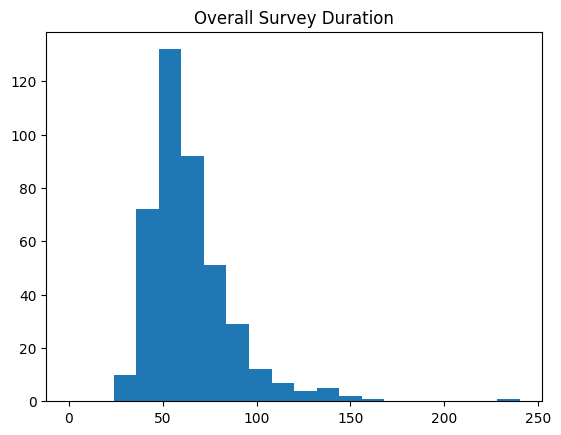

In [28]:
qSumm.loc[:, 'qa:attChks']=np.sum((qDat.loc[:,qDat.columns[qDat.columns.str.startswith('AC') | qDat.columns.str.startswith('LEC-A_13')]]==[2, 5, 7]).astype(int), axis=1)
LEC_Atmp=pd.DataFrame(np.array(qDat.loc[:,qDat.columns.str.startswith('LEC-A')].drop(columns='LEC-A_13').transpose())[:-1]==np.array(qDat.loc[:,qDat.columns.str.startswith('LEC-A')].drop(columns='LEC-A_13').transpose())[1:], columns=qDat.index)
qSumm['LEC_A_prop_ConsecResps']=LEC_Atmp.sum()/LEC_Atmp.shape[0]
BSItmp=pd.DataFrame(np.array(qDat.loc[:,qDat.columns.str.startswith('BSI')].drop(columns='BSIDT').transpose())[:-1]==np.array(qDat.loc[:,qDat.columns.str.startswith('BSI')].drop(columns='BSIDT').transpose())[1:], columns=qDat.index)
qSumm['BSI_prop_ConsecResps']=BSItmp.sum()/BSItmp.shape[0]
#ConsecResps not calculated for AUDIT/SCID-II because question type varied too much.
#ConsecResps not calculated for LEC-B/PCL5 because question type varied too much and contingent upon LEC-A.
#ConsecResps not calculated for SIP-R because Consec responding valid.
qSumm['qa:survTot_prop_ConsecResps']=(LEC_Atmp.sum()+BSItmp.sum())/(LEC_Atmp.shape[0]+BSItmp.shape[0])



print('Overall Survey Time:')
print('Mean/Median Duration (mins): {:0.2f}/{:0.2f}'.format(qSumm.totalTime.mean()/60,qSumm.totalTime.median()/60))
print('Min/Max Duration (mins): {:0.2f}/{:0.2f}'.format(qSumm.totalTime.min()/60, qSumm.totalTime.max()/60))
maxBin=np.ceil(qSumm.totalTime.max()/60/5)*5
binStep=np.ceil(maxBin/20)
plt.hist(qSumm.totalTime/60, bins=np.arange(0,maxBin+binStep,binStep))
plt.title('Overall Survey Duration')
plt.savefig('final/results/Overall_Survey_Duration.png')
plt.show()

print('_' * term_size)

fig,axs=plt.subplots(3,int(np.sum(qSumm.columns.str.contains('prop_ConsecResps'))/2), figsize=(np.sum(qSumm.columns.str.contains('prop_ConsecResps'))/2*5,10))
for col, ax in zip(qSumm.columns[qSumm.columns.str.contains('prop_ConsecResps')],axs.flatten()):
    if 'Dur' in col:
        ax.hist(qSumm[col], bins=25)
    else:
        ax.hist(qSumm[col], bins=np.arange(0,1.01,.05))
    ax.set(title='Qualtrics - '+col)
plt.savefig('final/results/Qualtrics_Survey_QAmetrics.png')
plt.show()
print('_' * term_size)

qCorrDf=qSumm.loc[:,qSumm.columns.str.contains('prop_ConsecResps')].corr()
sns.heatmap(qCorrDf, xticklabels=qCorrDf.columns, yticklabels=qCorrDf.columns, annot=True, cmap='autumn')
plt.title('Correlation between ConsecRep metrics for surveys')
plt.savefig('final/results/qa_survey_consecRep_correlations.png')
plt.show()
# [print(i) for i in qDat.columns]
# qDat.loc[:,'Gender':'Colorblind_2_TEXT']
print('_' * term_size)
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axs[0].hist(qSumm.AUDIT, bins=np.r_[-0.5:41:1])
axs[0].axvline(7.5,linestyle="dashed", color='black')
axs[0].set_title('AUDIT Scores: {:d}<=7, {:d}>7'.format(np.sum(qSumm.AUDIT<=7),np.sum(qSumm.AUDIT>7)))

axs[1].hist(p1AUDIT, bins=np.r_[-0.5:41:1])
axs[1].axvline(7.5,linestyle="dashed", color='black')
axs[1].set_title('p1AUDIT Scores: {:d}<=7, {:d}>7; F>13={:d}/{:d}; M>15={:d}/{:d}; O>14={:d}/{:d}'.format(np.sum(p1AUDIT<=7),np.sum(p1AUDIT>7), np.sum(femaleAudit>13),femaleAudit.shape[0], np.sum(maleAudit>15), maleAudit.shape[0], np.sum(otherAudit>14),otherAudit.shape[0]))
# print('F>13={:d}/{:d}; M>15={:d}/{:d}; O>14={:d}/{:d}'.format(np.sum(femaleAudit>13),femaleAudit.shape[0], np.sum(maleAudit>15), maleAudit.shape[0], np.sum(otherAudit>14),otherAudit.shape[0]))

plt.savefig('final/results/AUDIT_ditributions.png')
plt.show()
print('_' * term_size)

### Load and analyze Trust Appraisal Data- Dont have this for now
+ QA Metrics
+ Curve Fitting
    - Offset (bounds=[1,5])
    - Scale (bounds=[0,4])
    - Slope (bounds=[-.25,.25])

In [ ]:
qDat.shape

(418, 330)

Trust Appraisal Task:
Mean/Median Task Duration (mins): 6.31/6.03
Min/Max Task Duration (mins): 2.59/27.19


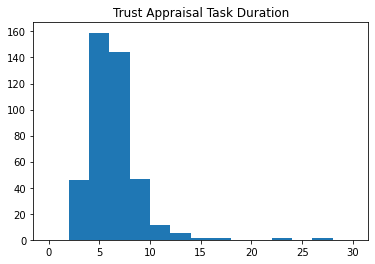

In [ ]:
tfOffsetBounds=(1,5)
tfScaleBounds=(0,4)
# tfOffsetBounds=(-1,6)
# tfScaleBounds=(-1,6)
tfSlopeBounds=(-.25,.25)

# READ IN TF DATA
tfDat=[]
for subj in subjs:
    # for fname in glob.iglob('data/tf/tf_app_'+subj+'*2022*.csv'):
    for fname in glob.iglob('/Users/dstanley/Dropbox/gitlab/Pavlovia_curr_active/tf_app/data/tf_app_'+subj+'*2023*.csv'):
        tfDat.append(pd.read_csv(fname).apply(pd.to_numeric, errors='ignore'))

# Calculate Summary and Quality Assurance Metrics
tfMeanResp=pd.DataFrame(index=subjs, columns=np.arange(0,101,10))
tfSumm=pd.DataFrame(index=subjs)
for dat in tfDat:
    PID=dat.subject_id[0]
    currDat=dat[dat.trialtype=='TR']
    if dat.labels[0][0]=='T':
        tfMeanResp.loc[PID,:]=6-np.array(currDat.groupby('stimLevel').mean().key_press)
        sigOut=optimize.curve_fit(sigmoid, (np.array(currDat.stimLevel)-1)*10, 6-np.array(currDat.key_press), bounds=([tfOffsetBounds[0],tfScaleBounds[0],tfSlopeBounds[0]],[tfOffsetBounds[1],tfScaleBounds[1],tfSlopeBounds[1]]))
    else:
        tfMeanResp.loc[PID,:]=np.array(currDat.groupby('stimLevel').mean().key_press)
        sigOut=optimize.curve_fit(sigmoid, (np.array(currDat.stimLevel)-1)*10, np.array(currDat.key_press), bounds=([tfOffsetBounds[0],tfScaleBounds[0],tfSlopeBounds[0]],[tfOffsetBounds[1],tfScaleBounds[1],tfSlopeBounds[1]]))
    tfSumm.loc[PID,'totalTime']=dat.totalTime[0]/1000
    tfSumm.loc[PID,'fitOffset']=sigOut[0][0]
    tfSumm.loc[PID,'fitScale']=sigOut[0][1]
    tfSumm.loc[PID,'fitSlope']=sigOut[0][2]
    tfSumm.loc[PID,'qa:prop_rt<300']=np.sum(currDat.rt<300)/currDat.rt.count()
    tfSumm.loc[PID,'qa:prop_rt>10000']=np.sum(currDat.rt>10000)/currDat.rt.count()
    # tfSumm.loc[PID,'qa:prop_rt<200']=np.sum(currDat.rt<200)/currDat.rt.count()
    tfSumm.loc[PID,'qa:prop_ConsecResps']=np.sum((np.array(currDat.key_press[:-1])-np.array(currDat.key_press[1:]))==0)/currDat.key_press.count()
    tfSumm.loc[PID,'qa:instruxDur']=np.round(dat[dat.trial_type=='instructions'].iloc[1].rt/1000,2)
    tfSumm.loc[PID,'qa:blurEv']=np.sum([dat.trialtype=='blurevent'])
    # tfSumm.loc[PID,'qa:blurWrn']=np.sum([dat.trialtype=='blurwarn'])

tfSumm.to_csv('final/results/trustAppraisalFitsFinal.csv')

# Print and Plot Task QA Summary
print('Trust Appraisal Task:')
print('Mean/Median Task Duration (mins): {:0.2f}/{:0.2f}'.format(tfSumm.totalTime.mean()/60,tfSumm.totalTime.median()/60))
print('Min/Max Task Duration (mins): {:0.2f}/{:0.2f}'.format(tfSumm.totalTime.min()/60, tfSumm.totalTime.max()/60))
maxBin=np.ceil(tfSumm.totalTime.max()/60/5)*5
binStep=np.ceil(maxBin/20)
plt.hist(tfSumm.totalTime/60, bins=np.arange(0,maxBin+binStep,binStep))
plt.title('Trust Appraisal Task Duration')
plt.savefig('final/results/Trust_Appraisal_Task_Duration.png')
plt.show()

fig,axs=plt.subplots(1,np.sum(tfSumm.columns.str.startswith('qa:')), figsize=(np.sum(tfSumm.columns.str.startswith('qa:')*5),5))
for col, ax in zip(tfSumm.columns[tfSumm.columns.str.startswith('qa:')],axs.flatten()):
    if 'Dur' or 'blur' in col:
        ax.hist(tfSumm[col], bins=25)
    else:
        ax.hist(tfSumm[col], bins=np.arange(0,1.01,.05))
    ax.set(title='tf'+col)
plt.savefig('final/results/Trust_Appraisal_QAmetrics.png')
plt.show()

### Load and analyze Lottery Learning Data
+ Two phases
    - Learning Data (6 lotteries)
    - Final Ratings (6 lotteries from Learning, 6 other paired faces from initial ratings)
+ QA Metrics
+ Learning Performance
    - Average points sent
    - Learning rates

In [ ]:
# READ IN rwlrn DATA
rwlrnDat=[]

rwlrnDatList = []
for subj in subjs:
    pattern = fr'C:\Users\mnand\Desktop\SNE Data Analysis\RawData\bpd_rwlrn\data\bpd_rwlrn_{subj}*2023*.csv'
    for fname in glob.iglob(pattern):
        rwlrnDatList.append(pd.read_csv(fname, sep=',', encoding='utf-8-sig', engine='python'))
rwlrnDat = pd.concat(rwlrnDatList, ignore_index=True)
    
rwlrnSumm=pd.DataFrame(index=subjs)
rwlrnEstArr=pd.DataFrame()
rwlrnOCArr=pd.DataFrame()
for PID in rwlrnDat['subject_id'].unique():
    dat = rwlrnDat[rwlrnDat['subject_id'] == PID]
    if not dat.empty:
        rwlrnSumm.loc[PID,'totalTime'] = dat['totalTime'].iloc[0] / 1000
        rwdecisions = dat.loc[dat.trialtype == 'decision', :]
        rwdecisions.key_press = rwdecisions.key_press.astype(int)
        rwfratings = dat.loc[dat.trialtype == 'final_rating', :]
        rwfratings.key_press = rwfratings.key_press.astype(int)
        rwlrnSumm.loc[PID,'qa:dec_%rt<300'] = np.sum(rwdecisions.rt < 300) / rwdecisions.rt.count()
        rwlrnSumm.loc[PID,'qa:dec_%rt>10000'] = np.sum(rwdecisions.rt > 10000) / rwdecisions.rt.count()
        rwlrnSumm.loc[PID,'qa:dec_%Conseqs'] = np.sum((np.array(rwdecisions.key_press[:-1]) - np.array(rwdecisions.key_press[1:])) == 0) / rwdecisions.key_press.count()
        rwlrnSumm.loc[PID,'qa:dec_instruxDur'] = np.round(dat[dat.trial_type == 'instructions'].iloc[2].rt / 1000, 2)
        rwlrnSumm.loc[PID,'qa:frat_%rt<300'] = np.sum(rwfratings.rt < 300) / rwfratings.rt.count()
        rwlrnSumm.loc[PID,'qa:frat_%rt>10000'] = np.sum(rwfratings.rt > 10000) / rwfratings.rt.count()
        rwlrnSumm.loc[PID,'qa:frat_%Conseqs'] = np.sum((np.array(rwfratings.key_press[:-1]) - np.array(rwfratings.key_press[1:])) == 0) / rwfratings.key_press.count()
        rwlrnSumm.loc[PID,'qa:frat_instruxDur'] = np.round(dat[dat.trial_type == 'instructions'].iloc[4].rt / 1000, 2)
        rwlrnSumm.loc[PID,'qa:blurEv'] = np.sum([dat.trialtype == 'blurevent'])
        # ...rest of your code...

    rwlrnEst=pd.DataFrame(index=np.arange(0,22), columns=['PID'])
    rwlrnEst['PID']=PID
    rwlrnOC=rwlrnEst.copy()
    for targ in np.sort(dat[dat.trialtype=='decision'].lottotype.unique()):
        rwlrnEst[targ]=dat[np.logical_and(dat.trialtype=='decision', dat.lottotype==targ)].sort_values(['ltround']).key_press.reset_index(drop=True).astype(int)
        rwlrnOC[targ]=(dat[np.logical_and(dat.trialtype=='decision', dat.lottotype==targ)].sort_values(['ltround']).outcome.reset_index(drop=True)=='Won').astype(int)
    
    rwlrnEstArr = pd.concat([rwlrnEstArr, rwlrnEst], ignore_index=True)
rwlrnOCArr = pd.concat([rwlrnOCArr, rwlrnOC], ignore_index=True)

rwlrnEstArr.reset_index()
rwlrnOCArr.reset_index()
rwmeanSumm=rwlrnEstArr.reset_index().groupby('index').mean()
rwcntSumm=rwlrnEstArr.reset_index().groupby('index').count().drop(columns='PID')
rwsteSumm=rwlrnEstArr.reset_index().groupby('index').std()/np.sqrt(rwcntSumm)
rwmeanOCSumm=rwlrnOCArr.reset_index().groupby('index').mean()
rwsteOCSumm=rwlrnOCArr.reset_index().groupby('index').std()/np.sqrt(rwcntSumm)
       

# Print and Plot RWLRN Task Summary
print('RWLRN Task:')
print('Mean/Median Task Duration (mins): {:0.2f}/{:0.2f}'.format(rwlrnSumm.totalTime.mean()/60,rwlrnSumm.totalTime.median()/60))
print('Min/Max Task Duration (mins): {:0.2f}/{:0.2f}'.format(rwlrnSumm.totalTime.min()/60, rwlrnSumm.totalTime.max()/60))
maxBin=np.ceil(rwlrnSumm.totalTime.max()/60/5)*5
binStep=np.ceil(maxBin/20)
plt.hist(rwlrnSumm.totalTime/60, bins=np.arange(0,maxBin+binStep,binStep))
plt.title('RWLRN Task Duration')
plt.savefig('final/results/RWLRN_Task_Duration.png')
plt.show()
    
fig,axs=plt.subplots(1,np.sum(rwlrnSumm.columns.str.startswith('qa:dec')), figsize=(np.sum(rwlrnSumm.columns.str.startswith('qa:dec')*5),5))
for col, ax in zip(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('qa:dec')],axs.flatten()):
    if 'Dur' or 'blur' in col:
        ax.hist(rwlrnSumm[col], bins=25)
    else:
        ax.hist(rwlrnSumm[col], bins=np.arange(0,1.01,.05))
    ax.set(title='rwlrn'+col)
plt.savefig('final/results/Lotto_Learning_QAmetrics.png')
plt.show()

fig,axs=plt.subplots(1,np.sum(rwlrnSumm.columns.str.startswith('qa:frat')), figsize=(np.sum(rwlrnSumm.columns.str.startswith('qa:frat')*5),5))
for col, ax in zip(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('qa:frat')],axs.flatten()):
    if 'Dur' or 'blur' in col:
        ax.hist(rwlrnSumm[col], bins=25)
    else:
        ax.hist(rwlrnSumm[col], bins=np.arange(0,1.01,.05))
    ax.set(title='rwfrat'+col)
plt.savefig('final/results/Lotto_Final_Rating_QAmetrics.png')
plt.show()

C:\Users\mnand\AppData\Local\Temp\ipykernel_27980\2822923590.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rwdecisions.key_press = rwdecisions.key_press.astype(int)
C:\Users\mnand\AppData\Local\Temp\ipykernel_27980\2822923590.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rwfratings.key_press = rwfratings.key_press.astype(int)


AttributeError: 'DataFrame' object has no attribute 'append'

### Load and analyze Trust Rating and Learning Data
+ Three phases
    - Initial Ratings (30 faces x 2 ratings)
    - Learning Data (6 faces - 2 x lo, med, hi trust ratings)
    - Final Ratings (6 faces from Learning, 6 other paired faces from initial ratings)
+ QA Metrics
+ Rating Performance
    - correlation between r1 and r2
    - correlation between initial and final
+ Learning Performance
    - Average points sent
    - Learning rates

/Users/dstanley/opt/anaconda3/envs/jpy39/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


TRLRN Task:
Mean/Median Task Duration (mins): 12.15/11.34
Min/Max Task Duration (mins): 5.18/51.22


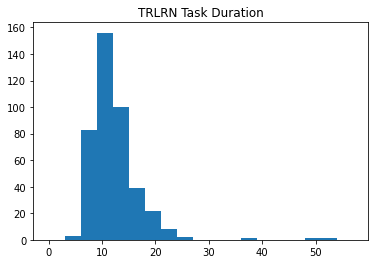

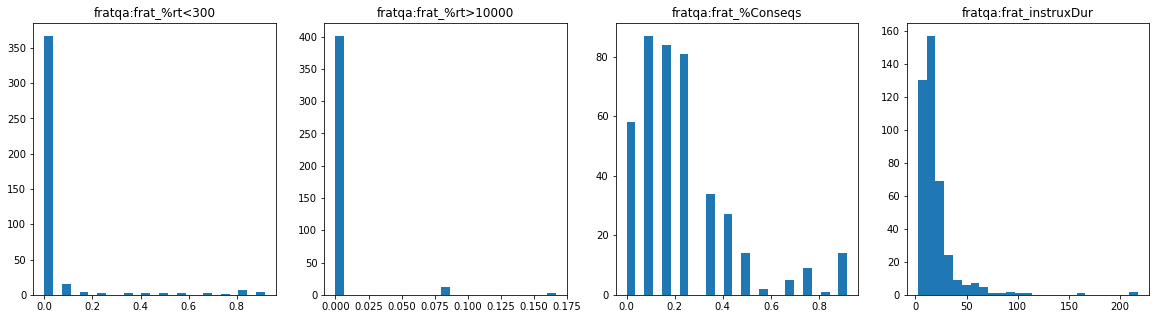

In [ ]:
# READ IN lrn DATA
lrnDat=[]
for subj in subjs:
    # for fname in glob.iglob('data/trlrn/bpd_trlrn_'+subj+'*2022*.csv'):
    for fname in glob.iglob('/Users/dstanley/Dropbox/gitlab/Pavlovia_curr_active/bpd_trlrn/data/bpd_trlrn_'+subj+'*2023*.csv'):
        lrnDat.append(pd.read_csv(fname).apply(pd.to_numeric, errors='ignore'))
    

lrnSumm=pd.DataFrame(index=subjs)
lrnEstArr=pd.DataFrame()
lrnOCArr=pd.DataFrame()
for dat in lrnDat:
    PID=dat.subject_id[0]
    lrnSumm.loc[PID,'totalTime']=dat.totalTime[0]/1000
    lastRat=dat[dat.trialtype=='ratingFB'].index[-1]
    ratings=dat.loc[dat.trialtype=='rating',:]
    ratings.key_press=ratings.key_press.astype(int)
    decisions=dat.loc[dat.trialtype=='decision',:]
    decisions.key_press=decisions.key_press.astype(int)
    fratings=dat.loc[dat.trialtype=='final_rating',:]
    fratings.key_press=fratings.key_press.astype(int)
    lrnSumm.loc[PID,'rat_mean']=ratings.key_press.mean()
    lrnSumm.loc[PID,'rat_std']=ratings.key_press.std()
    tmp=ratings.copy()
    tmp=tmp[['trial_index','stimulus','key_press']].sort_values(['stimulus', 'trial_index']).reset_index(drop=True)
    r,p=stats.pearsonr(tmp.loc[np.r_[0:tmp.shape[0]:2],'key_press'],tmp.loc[np.r_[1:tmp.shape[0]:2],'key_press'])
    lrnSumm.loc[PID,'rat_r1r2_corr_r']=r
    lrnSumm.loc[PID,'rat_r1r2_corr_p']=p
    lrnSumm.loc[PID,'qa:rat_%rt<300']=np.sum(ratings.rt<300)/ratings.rt.count()
    lrnSumm.loc[PID,'qa:rat_%rt>10000']=np.sum(ratings.rt>10000)/ratings.rt.count()
    # lrnSumm.loc[PID,'qa:rat_%rt<200']=np.sum(ratings.rt<200)/ratings.rt.count()
    lrnSumm.loc[PID,'qa:rat_%Conseqs']=np.sum((np.array(ratings.key_press[:-1])-np.array(ratings.key_press[1:]))==0)/ratings.key_press.count()
    lrnSumm.loc[PID,'qa:rat_instruxDur']=np.round(dat[dat.trial_type=='instructions'].iloc[1].rt/1000,2)
    lrnSumm.loc[PID,'qa:rat_blurEv']=np.sum(dat[:lastRat+1].trialtype=='blurevent')
    lrnSumm.loc[PID,'qa:dec_%rt<300']=np.sum(decisions.rt<300)/decisions.rt.count()
    lrnSumm.loc[PID,'qa:dec_%rt>10000']=np.sum(decisions.rt>10000)/decisions.rt.count()
    # lrnSumm.loc[PID,'qa:dec_%rt<200']=np.sum(decisions.rt<200)/decisions.rt.count()
    lrnSumm.loc[PID,'qa:dec_%Conseqs']=np.sum((np.array(decisions.key_press[:-1])-np.array(decisions.key_press[1:]))==0)/decisions.key_press.count()
    lrnSumm.loc[PID,'qa:dec_instruxDur']=np.round(dat[dat.trial_type=='instructions'].iloc[4].rt/1000,2)
    lrnSumm.loc[PID,'qa:dec_blurEv']=np.sum(dat[lastRat+1:].trialtype=='blurevent')
    lrnSumm.loc[PID,'rat_mean']=ratings.key_press.mean()
    lrnSumm.loc[PID,'rat_std']=ratings.key_press.std()
    tmp=fratings.copy()
    tmp=tmp[['trial_index','stimulus','key_press']].sort_values(['stimulus', 'trial_index']).reset_index(drop=True)
    tmp2=ratings.loc[ratings.stimulus.isin(fratings.stimulus)].sort_values(['stimulus','trial_index'])[['trial_index','stimulus', 'key_press']].reset_index(drop=True)
    tmp2=(np.array(tmp2.loc[np.r_[0:tmp2.shape[0]:2],'key_press'])+np.array(tmp2.loc[np.r_[1:tmp2.shape[0]:2],'key_press']))/2
    r,p=stats.pearsonr(tmp.key_press,tmp2)
    lrnSumm.loc[PID,'frat_r1r2_corr_r']=r
    lrnSumm.loc[PID,'frat_r1r2_corr_p']=p
    lrnSumm.loc[PID,'qa:frat_%rt<300']=np.sum(fratings.rt<300)/fratings.rt.count()
    lrnSumm.loc[PID,'qa:frat_%rt>10000']=np.sum(fratings.rt>10000)/fratings.rt.count()
    # lrnSumm.loc[PID,'qa:frat_%rt<200']=np.sum(fratings.rt<200)/fratings.rt.count()
    lrnSumm.loc[PID,'qa:frat_%Conseqs']=np.sum((np.array(fratings.key_press[:-1])-np.array(fratings.key_press[1:]))==0)/fratings.key_press.count()
    lrnSumm.loc[PID,'qa:frat_instruxDur']=np.round(dat[dat.trial_type=='instructions'].iloc[7].rt/1000,2)
    
    lrnEst=pd.DataFrame(index=np.arange(0,22), columns=['PID'])
    lrnEst['PID']=PID
    lrnOC=lrnEst.copy()
    for targ in np.sort(dat[dat.trialtype=='decision'].agenttype.unique()):
        lrnEst[targ]=dat[np.logical_and(dat.trialtype=='decision', dat.agenttype==targ)].sort_values(['aground']).key_press.reset_index(drop=True).astype(int)
        lrnOC[targ]=(dat[np.logical_and(dat.trialtype=='decision', dat.agenttype==targ)].sort_values(['aground']).outcome.reset_index(drop=True)=='Shared').astype(int)
    
    lrnEstArr=lrnEstArr.append(lrnEst)
    lrnOCArr=lrnOCArr.append(lrnOC)

lrnEstArr.reset_index()
lrnOCArr.reset_index()
meanSumm=lrnEstArr.reset_index().groupby('index').mean()
cntSumm=lrnEstArr.reset_index().groupby('index').count().drop(columns='PID')
steSumm=lrnEstArr.reset_index().groupby('index').std()/np.sqrt(cntSumm)
meanOCSumm=lrnOCArr.reset_index().groupby('index').mean()
steOCSumm=lrnOCArr.reset_index().groupby('index').std()/np.sqrt(cntSumm)
       
    

# Print and Plot Task QA Metric Summary
print('TRLRN Task:')
print('Mean/Median Task Duration (mins): {:0.2f}/{:0.2f}'.format(lrnSumm.totalTime.mean()/60,lrnSumm.totalTime.median()/60))
print('Min/Max Task Duration (mins): {:0.2f}/{:0.2f}'.format(lrnSumm.totalTime.min()/60, lrnSumm.totalTime.max()/60))
maxBin=np.ceil(lrnSumm.totalTime.max()/60/5)*5
binStep=np.ceil(maxBin/20)
plt.hist(lrnSumm.totalTime/60, bins=np.arange(0,maxBin+binStep,binStep))
plt.title('TRLRN Task Duration')
plt.savefig('final/results/TRLRN_Task_Duration.png')
plt.show()
    
fig,axs=plt.subplots(1,np.sum(lrnSumm.columns.str.startswith('qa:rat')), figsize=(np.sum(lrnSumm.columns.str.startswith('qa:rat')*5),5))
for col, ax in zip(lrnSumm.columns[lrnSumm.columns.str.startswith('qa:rat')],axs.flatten()):
    if 'Dur' or 'blur' in col:
        ax.hist(lrnSumm[col], bins=25)
    else:
        ax.hist(lrnSumm[col], bins=np.arange(0,1.01,.05))
    ax.set(title='rat'+col)
plt.savefig('final/results/Trust_Rating_QAmetrics.png')
plt.show()

fig,axs=plt.subplots(1,np.sum(lrnSumm.columns.str.startswith('qa:dec')), figsize=(np.sum(lrnSumm.columns.str.startswith('qa:dec')*5),5))
for col, ax in zip(lrnSumm.columns[lrnSumm.columns.str.startswith('qa:dec')],axs.flatten()):
    if 'Dur' or 'blur' in col:
        ax.hist(lrnSumm[col], bins=25)
    else:
        ax.hist(lrnSumm[col], bins=np.arange(0,1.01,.05))
    ax.set(title='lrn'+col)
plt.savefig('final/results/Trust_Learning_QAmetrics.png')
plt.show()

fig,axs=plt.subplots(1,np.sum(lrnSumm.columns.str.startswith('qa:frat')), figsize=(np.sum(lrnSumm.columns.str.startswith('qa:frat')*5),5))
for col, ax in zip(lrnSumm.columns[lrnSumm.columns.str.startswith('qa:frat')],axs.flatten()):
    if 'Dur' or 'blur' in col:
        ax.hist(lrnSumm[col], bins=25)
    else:
        ax.hist(lrnSumm[col], bins=np.arange(0,1.01,.05))
    ax.set(title='frat'+col)
plt.savefig('final/results/Trust_Final_Rating_QAmetrics.png')
plt.show()

### Load and analyze Working Memory Data
+ Design
    - Conds: Match/No Match
    - Array Sizes: 1, 2, 3
+ QA Metrics
+ Wmem Performance
    - Cond X Array Size: Accuracy and RT
    - Cond: Accuracy and RT
    - Array Size: Accuracy and RT




WMEM Task:
Mean/Median Task Duration (mins): 10.88/10.30
Min/Max Task Duration (mins): 8.10/33.09


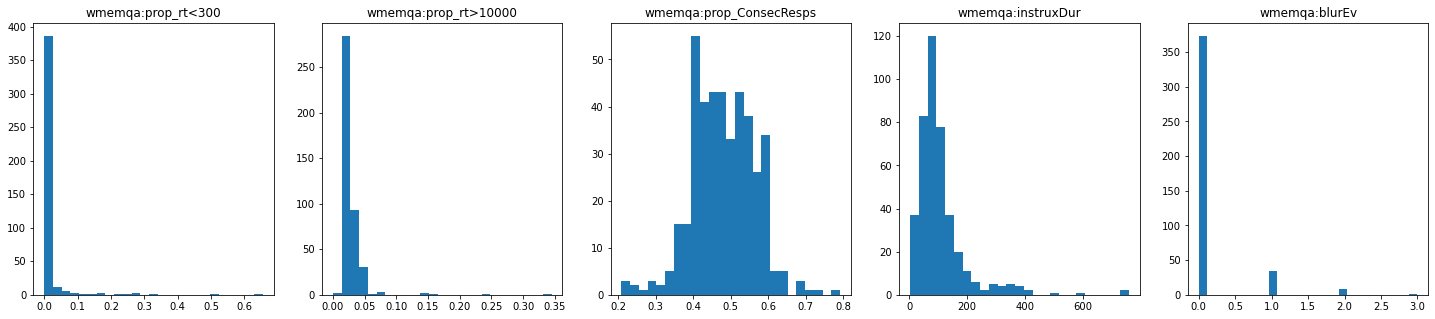

In [ ]:
# READ IN wmem DATA
wmemDat=[]
for subj in subjs:
    # for fname in glob.iglob('data/wmem/bpd_wmem_'+subj+'*2022*.csv'):
    for fname in glob.iglob('/Users/dstanley/Dropbox/gitlab/Pavlovia_curr_active/bpd_wmem/data/bpd_wmem_'+subj+'*2023*.csv'):
        wmemDat.append(pd.read_csv(fname))

wmemSumm=pd.DataFrame(index=subjs)
wmMeanSumm_acc=pd.DataFrame([])
wmMeanSumm_rt=pd.DataFrame([])
wmMeanSumm_acc_arrSz=pd.DataFrame([])
wmMeanSumm_rt_arrSz=pd.DataFrame([])
wmMeanSumm_acc_crrRsp=pd.DataFrame([])
wmMeanSumm_rt_crrRsp=pd.DataFrame([])
for dat in wmemDat:
    PID=dat.subject_id[0]
    wmemSumm.loc[PID,'totalTime']=dat.totalTime[0]/1000
    gdat=dat[(dat.trialType=='REAL') & (dat.rt>300) & (dat.rt<10000)].reset_index(drop=True)
    gdat.loc[gdat.corrResp=='e','corrResp']=gdat.labels[0].split(',')[0]
    gdat.loc[gdat.corrResp=='i','corrResp']=gdat.labels[0].split(',')[1]
    gdat['arraySize']=gdat['arraySize'].astype(int)
    # Overall metrics (Acc, RT, )
    wmemSumm.loc[PID,'overall_acc'] = gdat['corr'].mean()
    wmemSumm.loc[PID,'overall_rt'] = gdat.rt.mean()    
    # Full condition break down of metrics (Match, No Match x 1,2,3 )
    tmp=gdat.groupby(['corrResp', 'arraySize']).mean()['corr']    
    wmMeanSumm_acc=wmMeanSumm_acc.append(tmp.rename(PID))
    tmp=gdat[gdat['corr']==1].groupby(['corrResp', 'arraySize']).mean()['rt']
    wmMeanSumm_rt=wmMeanSumm_rt.append(tmp.rename(PID))
    # Break down of metrics by Array Size (1,2,3 )
    tmp=gdat.groupby(['arraySize']).mean()['corr']
    wmMeanSumm_acc_arrSz=wmMeanSumm_acc_arrSz.append(tmp.rename(PID))
    tmp=gdat[gdat['corr']==1].groupby(['arraySize']).mean()['rt']
    wmMeanSumm_rt_arrSz=wmMeanSumm_rt_arrSz.append(tmp.rename(PID))
    # Break down of metrics by condition (Match, No Match)
    tmp=gdat.groupby(['corrResp']).mean()['corr']
    wmMeanSumm_acc_crrRsp=wmMeanSumm_acc_crrRsp.append(tmp.rename(PID))
    tmp=gdat[gdat['corr']==1].groupby(['corrResp']).mean()['rt']
    wmMeanSumm_rt_crrRsp=wmMeanSumm_rt_crrRsp.append(tmp.rename(PID))
    
    wmemSumm.loc[PID,'qa:prop_rt<300'] = (dat.rt<300).sum()/dat.rt.count()
    wmemSumm.loc[PID,'qa:prop_rt>10000'] = (dat.rt>10000).sum()/dat.rt.count()
    # wmemSumm.loc[PID,'qa:prop_rt<200'] = (dat.rt<200).sum()/dat.rt.count()
    wmemSumm.loc[PID,'qa:prop_ConsecResps']=np.sum(np.array(dat[(dat.trialType=='REAL')].key_press[:-1])==np.array(dat[(dat.trialType=='REAL')].key_press[1:]))/dat[(dat.trialType=='REAL')].key_press.count()
    wmemSumm.loc[PID,'qa:instruxDur']=np.round(dat[dat.trial_type=='instructions'].rt.iloc[1]/1000,2)
    wmemSumm.loc[PID,'qa:blurEv']=np.sum([dat.trialtype=='blurevent'])

wmAcc_mu=pd.DataFrame(wmMeanSumm_acc, columns=pd.MultiIndex.from_tuples(wmMeanSumm_acc.columns, names=['match_type', 'array_size'])).mean()
wmAcc_ste=pd.DataFrame(wmMeanSumm_acc, columns=pd.MultiIndex.from_tuples(wmMeanSumm_acc.columns, names=['match_type', 'array_size'])).std()/np.sqrt(wmMeanSumm_acc.count())
wmRt_mu=pd.DataFrame(wmMeanSumm_rt, columns=pd.MultiIndex.from_tuples(wmMeanSumm_rt.columns, names=['match_type', 'array_size'])).mean()
wmRt_ste=pd.DataFrame(wmMeanSumm_rt, columns=pd.MultiIndex.from_tuples(wmMeanSumm_rt.columns, names=['match_type', 'array_size'])).std()/np.sqrt(wmMeanSumm_rt.count())

tmp=wmMeanSumm_acc_arrSz/wmMeanSumm_rt_arrSz*1000
for subj in subjs:
    wmemSumm.loc[subj,'slope Acc/RT x arrSz']=np.nanmean(np.diff(tmp.loc[subj,:])) 
    
wmemSumm.insert(wmemSumm.columns.get_loc('overall_rt')+1, 'slope Acc/RT x arrSz', wmemSumm.pop('slope Acc/RT x arrSz') )

wmMeanSumm_acc.columns=['crrRspXarrSz acc: {}_{:d}'.format(i[0],i[1]) for i in wmMeanSumm_acc.columns]
wmMeanSumm_rt.columns=['crrRspXarrSz rt: {}_{:d}'.format(i[0],i[1]) for i in wmMeanSumm_rt.columns]        
wmMeanSumm_acc_arrSz.columns=['arrSz acc: {:d}'.format(i) for i in wmMeanSumm_acc_arrSz.columns]
wmMeanSumm_rt_arrSz.columns=['arrSz rt: {:d}'.format(i) for i in wmMeanSumm_rt_arrSz.columns]
wmMeanSumm_acc_crrRsp.columns=['cond acc: {}'.format(i) for i in wmMeanSumm_acc_crrRsp.columns]
wmMeanSumm_rt_crrRsp.columns=['cond rt: {}'.format(i) for i in wmMeanSumm_rt_crrRsp.columns]

wmemSumm=wmemSumm.join(wmMeanSumm_acc_crrRsp.join(wmMeanSumm_rt_crrRsp))
wmemSumm=wmemSumm.join(wmMeanSumm_acc_arrSz.join(wmMeanSumm_rt_arrSz))
wmemSumm=wmemSumm.join(wmMeanSumm_acc.join(wmMeanSumm_rt))

wmemSumm=wmemSumm.loc[:,wmemSumm.columns[~wmemSumm.columns.str.startswith('qa:')].append(wmemSumm.columns[wmemSumm.columns.str.startswith('qa:')])]

print('WMEM Task:')
print('Mean/Median Task Duration (mins): {:0.2f}/{:0.2f}'.format(wmemSumm.totalTime.mean()/60,wmemSumm.totalTime.median()/60))
print('Min/Max Task Duration (mins): {:0.2f}/{:0.2f}'.format(wmemSumm.totalTime.min()/60, wmemSumm.totalTime.max()/60))

# Print and Plot Task Summary
plt.hist(wmemSumm.totalTime/60, bins=25)
plt.title('WMEM Task Duration')
plt.savefig('results/WMEM_Task_Duration.png')
plt.show()

fig,axs=plt.subplots(1,np.sum(wmemSumm.columns.str.startswith('qa:')), figsize=(np.sum(wmemSumm.columns.str.startswith('qa:')*5),5))
for col, ax in zip(wmemSumm.columns[wmemSumm.columns.str.startswith('qa:')],axs.flatten()):
    if 'Dur' or 'blur' in col:
        ax.hist(wmemSumm[col], bins=25)
    else:
        ax.hist(wmemSumm[col], bins=np.arange(0,1.01,.05))
    ax.set(title='wmem'+col)
plt.savefig('results/WMEM_QAmetrics.png')
plt.show()

### QA Analysis
+ Norm all QA metrics by Max Val
+ Calculate median QA metric vector
+ Calculate each participants distance from QA Vector
    - Histogram
    - Polar plots
+ Scatter plots of participant distance from MedQA versus performance in tasks



Dimensionality reduced to 80.00%


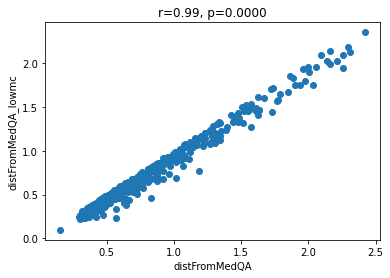

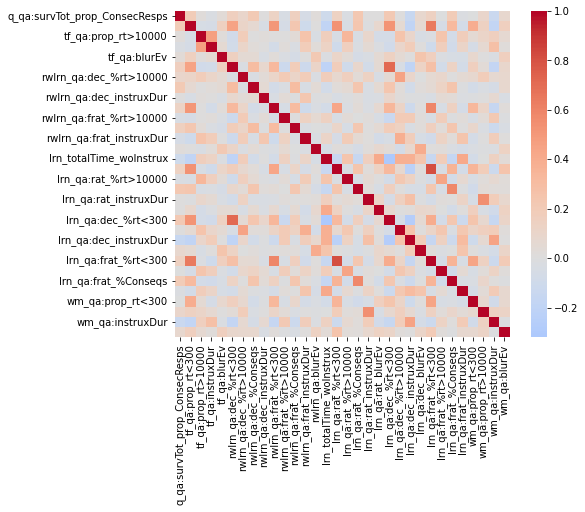

In [ ]:
# AGGREGATE QA METRICS INTO A SINGLE DF qaSumm

tmp=qSumm[qSumm.columns[qSumm.columns.str.contains('Time') | qSumm.columns.str.startswith('qa:')]]
tmp.columns=['q_{}'.format(i) for i in tmp.columns]
qaSumm=tmp
tmp=tfSumm[tfSumm.columns[tfSumm.columns.str.contains('Time') | tfSumm.columns.str.startswith('qa:')]]
tmp.columns=['tf_{}'.format(i) for i in tmp.columns]
qaSumm=qaSumm.join(tmp)
tmp=rwlrnSumm[rwlrnSumm.columns[rwlrnSumm.columns.str.contains('Time') | rwlrnSumm.columns.str.startswith('qa:')]]
tmp.columns=['rwlrn_{}'.format(i) for i in tmp.columns]
qaSumm=qaSumm.join(tmp)
tmp=lrnSumm[lrnSumm.columns[lrnSumm.columns.str.contains('Time') | lrnSumm.columns.str.startswith('qa:')]]
tmp.columns=['lrn_{}'.format(i) for i in tmp.columns]
qaSumm=qaSumm.join(tmp)
tmp=wmemSumm[wmemSumm.columns[wmemSumm.columns.str.contains('Time') | wmemSumm.columns.str.startswith('qa:')]]
tmp.columns=['wm_{}'.format(i) for i in tmp.columns]
qaSumm=qaSumm.join(tmp)

# Remove instruxDur from Total Time Estimates
qaSumm['tf_totalTime']=qaSumm['tf_totalTime']-qaSumm['tf_qa:instruxDur']
qaSumm['rwlrn_totalTime']=qaSumm['rwlrn_totalTime']-qaSumm['rwlrn_qa:dec_instruxDur']
qaSumm['lrn_totalTime']=qaSumm['lrn_totalTime']-(qaSumm['lrn_qa:rat_instruxDur']+qaSumm['lrn_qa:dec_instruxDur']+qaSumm['lrn_qa:frat_instruxDur'])
qaSumm['wm_totalTime']=qaSumm['wm_totalTime']-qaSumm['wm_qa:instruxDur']
qaSumm.rename(columns={'tf_totalTime':'tf_totalTime_woInstrux', 'rwlrn_totalTime':'rwlrn_totalTime_woInstrux', 'lrn_totalTime':'lrn_totalTime_woInstrux', 'wm_totalTime':'wm_totalTime_woInstrux'}, inplace=True)

# Create normalized (to the maximum value) DataFrame qaSumm_nrm
qaSumm_nrm=qaSumm/qaSumm.max()


# Calculate Variable Inflation Factors for all Quality Metrics and 
# if any are over 10, iteratively exclude the factor with the max val and recalculate
dropCols=[]
vifDat=qaSumm_nrm.dropna()
vifMat=pd.DataFrame([[i,variance_inflation_factor(vifDat.values,j)] for i,j in zip(vifDat.columns, range(vifDat.shape[1]))], columns=['qaMeas','VIF'])
while vifMat['VIF'].max()>10:
    dropCols.append(np.array(vifMat.loc[vifMat['VIF']==vifMat['VIF'].max(),'qaMeas'])[0])
    vifDat=qaSumm_nrm.drop(columns=dropCols).dropna()
    vifMat=pd.DataFrame([[i,variance_inflation_factor(vifDat.values,j)] for i,j in zip(vifDat.columns, range(vifDat.shape[1]))], columns=['qaMeas','VIF'])

qaSumm_nrm_lowmc = qaSumm_nrm.loc[:,vifDat.columns]

print('Dimensionality reduced to {:0.2f}%'.format(qaSumm_nrm_lowmc.shape[1]/qaSumm_nrm.shape[1]*100))

# Calculate Mean and Median
qaMean=qaSumm_nrm.mean()
qaMed=qaSumm_nrm.median()
qaMean_lowmc=qaSumm_nrm_lowmc.mean()
qaMed_lowmc=qaSumm_nrm_lowmc.median()


# Calculate metric of "Bad Subjects" based on Euclidean distance from Median QA metrics
qaSumm['distFromMedQA']=[np.sqrt(np.sum((qaSumm_nrm.loc[i,:]-qaMed)**2)) for i in qaSumm_nrm.index]
qaSumm['distFromMedQA_lowmc']=[np.sqrt(np.sum((qaSumm_nrm_lowmc.loc[i,:]-qaMed_lowmc)**2)) for i in qaSumm_nrm_lowmc.index]


r,p=stats.pearsonr(qaSumm['distFromMedQA'], qaSumm['distFromMedQA_lowmc'])
plt.scatter(qaSumm['distFromMedQA'], qaSumm['distFromMedQA_lowmc'])
plt.xlabel('distFromMedQA')
plt.ylabel('distFromMedQA_lowmc')
plt.title('r={:0.2f}, p={:0.4f}'.format(r,p))
plt.show()

plt.figure(figsize=(7.5, 6))
corr_matrix = qaSumm_nrm.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.show()

plt.figure(figsize=(7.5, 6))
corr_matrix = qaSumm_nrm_lowmc.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.show()

In [ ]:
# corr_matrix = qaSumm.iloc[:,:-2].corr()
# sns.heatmap(corr_matrix, cmap='vlag', vmin=-1, vmax=1)
# plt.show()

# corr_matrix = qaSumm.loc[:,qaSumm_nrm_lowmc.columns].corr()
# sns.heatmap(corr_matrix, cmap='vlag', vmin=-1, vmax=1)
# # plt.savefig('results/distFromMedQA_lowmc_corrmat_wLabels.png')
# plt.show()

# corr_matrix = qaSumm.iloc[:,:-2].corr()
# sns.heatmap(corr_matrix, cmap='vlag', vmin=-1, vmax=1, cbar=False, xticklabels=False, yticklabels=False)
# plt.savefig('results/distFromMedQA_corrmat.png')
# plt.show()

# corr_matrix = qaSumm.loc[:,qaSumm_nrm_lowmc.columns].corr()
# sns.heatmap(corr_matrix, cmap='vlag', vmin=-1, vmax=1, cbar=False, xticklabels=False, yticklabels=False)
# plt.savefig('results/distFromMedQA_lowmc_corrmat.png')
# plt.show()

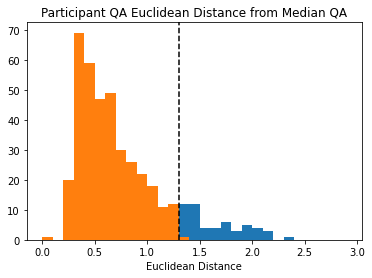

%12.68 removed


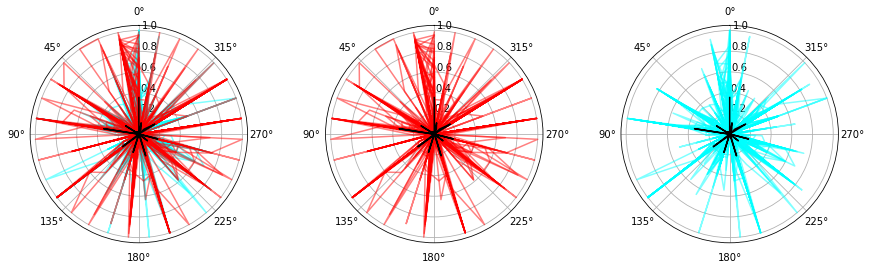

In [ ]:
# Set cutoff for BAD subjs based on distance from Median QA metrics
# IQR=np.diff(qaSumm['distFromMedQA'].quantile([.25, .75]))
# outlier=np.array(qaSumm['distFromMedQA'].quantile([.75])+IQR*1.5)[0]
# # cutoff=outlier
# cutoff=qaSumm.distFromMedQA_lowmc.quantile(.85)
medianDist=qaSumm.distFromMedQA_lowmc.median()
cutoffW1=medianDist+np.median(np.abs(qaSumm.distFromMedQA_lowmc-medianDist))*3
# cutoff=1.5307

# Histogram of Participant QA Euclidean distances from Median with cutoff illustrated
plt.hist(qaSumm['distFromMedQA_lowmc'], bins=np.arange(0,3,.1))
plt.hist(qaSumm.loc[qaSumm['distFromMedQA_lowmc']<cutoffW1,'distFromMedQA_lowmc'], bins=np.arange(0,3,.1))
plt.axvline(x=cutoffW1, linestyle='--', color='k')
plt.title('Participant QA Euclidean Distance from Median QA')
plt.xlabel('Euclidean Distance')
plt.savefig('results/qaAnalysis_ptpDist_from_medQA.png')
plt.show()
print('%{:0.2f} removed'.format((1-np.sum(qaSumm.distFromMedQA_lowmc<cutoffW1)/qaSumm.shape[0])*100))

pltDat=qaSumm_nrm_lowmc # alt=qaSumm_nrm
pltDatMed=qaMed_lowmc # alt=qaMed
pltDatDistMetric='distFromMedQA_lowmc' # alt='distFromMedQA'

theta=np.linspace(0,2*np.pi,pltDat.shape[1])
fig,ax=plt.subplots(1,3,subplot_kw=dict(projection='polar'), figsize=(15,4))

ax[0].plot(theta,pltDat[qaSumm[pltDatDistMetric]<cutoffW1].transpose(), color='cyan', alpha=.5)
ax[0].plot(theta,pltDat[qaSumm[pltDatDistMetric]>=cutoffW1].transpose(), color='red', alpha=.5)
ax[0].plot(theta,pltDatMed, color='black')
ax[0].set_theta_zero_location('N')
ax[0].set_rlabel_position(ax[0].get_rlabel_position()-24)
# ax[0].set_xticks(np.r_[0,7,12,17, 20, 24]/31*2*np.pi)
# ax[0].set_xticklabels(['qual', 'trApp', 'trRat', 'trLrn', 'trFrat', 'wmem'])

ax[1].plot(theta,pltDat[qaSumm[pltDatDistMetric]>=cutoffW1].transpose(), color='red', alpha=.5)
ax[1].plot(theta,pltDatMed, color='black')
ax[1].set_theta_zero_location('N')
ax[1].set_rlabel_position(ax[1].get_rlabel_position()-24)
# ax[1].set_xticks(np.r_[0,7,12,17, 20, 24]/31*2*np.pi)
# ax[1].set_xticklabels(['qual', 'trApp', 'trRat', 'trLrn', 'trFrat', 'wmem'])

ax[2].plot(theta,pltDat[qaSumm[pltDatDistMetric]<cutoffW1].transpose(), color='cyan', alpha=.5)
# ax.plot(theta,qaSumm_nrm.transpose(), alpha=.75)
ax[2].plot(theta,pltDatMed, color='black')
ax[2].set_theta_zero_location('N')
ax[2].set_rlabel_position(ax[2].get_rlabel_position()-24)
# ax[2].set_xticks(np.r_[0,7,12,17, 20, 24]/31*2*np.pi)
# ax[2].set_xticklabels(['qual', 'trApp', 'trRat', 'trLrn', 'trFrat', 'wmem'])
plt.savefig('results/qaAnalysis_ptpDist_from_medQA_polar.png')
plt.show()

In [ ]:
# # Set cutoff for BAD subjs based on distance from Median QA metrics
# IQR=np.diff(qaSumm['distFromMedQA'].quantile([.25, .75]))
# outlier=np.array(qaSumm['distFromMedQA'].quantile([.75])+IQR*1.5)[0]
# # cutoff=outlier
# cutoff=1.5

# # Histogram of Participant QA Euclidean distances from Median with cutoff illustrated
# plt.hist(qaSumm['distFromMedQA'], bins=np.arange(0,3,.1))
# plt.axvline(x=cutoff, linestyle='--', color='k')
# plt.title('Participant QA Euclidean Distance from Median QA')
# plt.xlabel('Euclidean Distance')
# plt.savefig('final/results/qaAnalysis_ptpDist_from_medQA.png')
# plt.show()

# theta=np.linspace(0,2*np.pi,qaSumm_nrm.shape[1])
# fig,ax=plt.subplots(1,3,subplot_kw=dict(projection='polar'), figsize=(15,4))
# # ax.plot(theta,qaSumm_nrm.transpose(), color='gray', alpha=.2)

# # ax[0].plot(theta,qaSumm_nrm.transpose(), color='gray', alpha=.5)
# ax[0].plot(theta,qaSumm_nrm[qaSumm.distFromMedQA<cutoff].transpose(), color='cyan', alpha=.5)
# ax[0].plot(theta,qaSumm_nrm[qaSumm.distFromMedQA>=cutoff].transpose(), color='red', alpha=.5)
# ax[0].plot(theta,qaMed, color='black')
# ax[0].set_theta_zero_location('N')
# ax[0].set_rlabel_position(ax[0].get_rlabel_position()-24)
# ax[0].set_xticks(np.r_[0,4,8,12,15,19,22,25]/29*2*np.pi)
# ax[0].set_xticklabels(['qual', 'trApp','rwLrn', 'rwFrat', 'trRat', 'trLrn', 'trFrat', 'wmem'])

# ax[1].plot(theta,qaSumm_nrm[qaSumm.distFromMedQA>=cutoff].transpose(), color='red', alpha=.5)
# ax[1].plot(theta,qaMed, color='black')
# ax[1].set_theta_zero_location('N')
# ax[1].set_rlabel_position(ax[1].get_rlabel_position()-24)
# ax[1].set_xticks(np.r_[0,4,8,12,15,19,22,25]/29*2*np.pi)
# ax[1].set_xticklabels(['qual', 'trApp','rwLrn', 'rwFrat', 'trRat', 'trLrn', 'trFrat', 'wmem'])

# ax[2].plot(theta,qaSumm_nrm[qaSumm.distFromMedQA<cutoff].transpose(), color='cyan', alpha=.5)
# # ax.plot(theta,qaSumm_nrm.transpose(), alpha=.75)
# ax[2].plot(theta,qaMed, color='black')
# ax[2].set_theta_zero_location('N')
# ax[2].set_rlabel_position(ax[2].get_rlabel_position()-24)
# # plt.thetagrids(tuple(np.r_[0,7,12,17, 20, 24]/31*360))
# ax[2].set_xticks(np.r_[0,4,8,12,15,19,22,25]/29*2*np.pi)
# ax[2].set_xticklabels(['qual', 'trApp','rwLrn', 'rwFrat', 'trRat', 'trLrn', 'trFrat', 'wmem'])
# plt.savefig('final/results/qaAnalysis_ptpDist_from_medQA_polar.png')
# plt.show()

In [ ]:
### Load and perform QA analysis of Qualtrics Survey Data

qDatW2=pd.read_csv('final/data/BPD_PTSD Social LDM Week2_December 18, 2023_17.30.csv').drop(np.r_[:12]).apply(pd.to_numeric, errors='ignore')
qDatW2=qDatW2[(qDatW2.STUDY_ID.str.startswith('64') == True) & qDatW2.Finished==1].set_index('PROLIFIC_PID')
qDatW2=qDatW2[qDatW2.StartDate!="2023-04-02 18:43:58"]#drop duplicated participant 5c5f525806006e0001db95d2
subjsW2=pd.Series(qDatW2.index)


In [ ]:

qSummW2=pd.DataFrame(index=subjsW2)
qSummW2['totalTimeW2']=qDatW2['Duration (in seconds)'].astype(float)

qSummW2.loc[:, 'qa:attChks']=np.sum((qDatW2.loc[:,list(qDatW2.columns[qDatW2.columns.str.startswith('AC')])+['PID-5-FBF_66']]==[4, 9]).astype(int), axis=1)
CTQtmp=pd.DataFrame(np.array(qDatW2.loc[:,qDatW2.columns.str.startswith('CTQ')].drop(columns='CTQDT').transpose())[:-1]==np.array(qDatW2.loc[:,qDatW2.columns.str.startswith('CTQ')].drop(columns='CTQDT').transpose())[1:], columns=qDatW2.index)
qSummW2['CTQ_prop_ConsecResps']=CTQtmp.sum()/CTQtmp.shape[0]
CESDtmp=pd.DataFrame(np.array(qDatW2.loc[:,qDatW2.columns.str.startswith('CES_D')].transpose())[:-1]==np.array(qDatW2.loc[:,qDatW2.columns.str.startswith('CES_D')].transpose())[1:], columns=qDatW2.index)
qSummW2['CESD_prop_ConsecResps']=CESDtmp.sum()/CESDtmp.shape[0]
LFPSBFtmp=pd.DataFrame(np.array(qDatW2.loc[:,qDatW2.columns.str.startswith('LPFS-BF')].transpose())[:-1]==np.array(qDatW2.loc[:,qDatW2.columns.str.startswith('LPFS-BF')].transpose())[1:], columns=qDatW2.index)
qSummW2['LFPS-BF_prop_ConsecResps']=LFPSBFtmp.sum()/LFPSBFtmp.shape[0]
PID5tmp=pd.DataFrame(np.array(qDatW2.loc[:,qDatW2.columns.str.startswith('PID-5')].transpose())[:-1]==np.array(qDatW2.loc[:,qDatW2.columns.str.startswith('PID-5')].transpose())[1:], columns=qDatW2.index)
qSummW2['PID-5_prop_ConsecResps']=PID5tmp.sum()/PID5tmp.shape[0]
RFQ8tmp=pd.DataFrame(np.array(qDatW2.loc[:,qDatW2.columns.str.startswith('RFQ-8')].transpose())[:-1]==np.array(qDatW2.loc[:,qDatW2.columns.str.startswith('RFQ-8')].transpose())[1:], columns=qDatW2.index)
qSummW2['RFQ-8_prop_ConsecResps']=RFQ8tmp.sum()/RFQ8tmp.shape[0]

qSummW2['qa:survTot_prop_ConsecRespsW2']=(CTQtmp.sum()+CESDtmp.sum()+LFPSBFtmp.sum()+PID5tmp.sum()+RFQ8tmp.sum())/(CTQtmp.shape[0]+CESDtmp.shape[0]+LFPSBFtmp.shape[0]+PID5tmp.shape[0]+RFQ8tmp.shape[0])

Overall Survey Time:
Mean/Median Duration (mins): 87.76/48.92
Min/Max Duration (mins): 21.22/8903.30


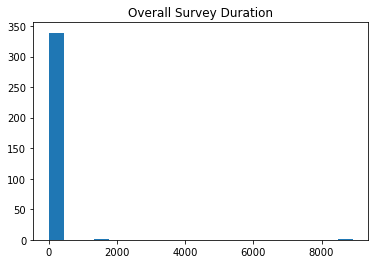

________________________________________________________________________________


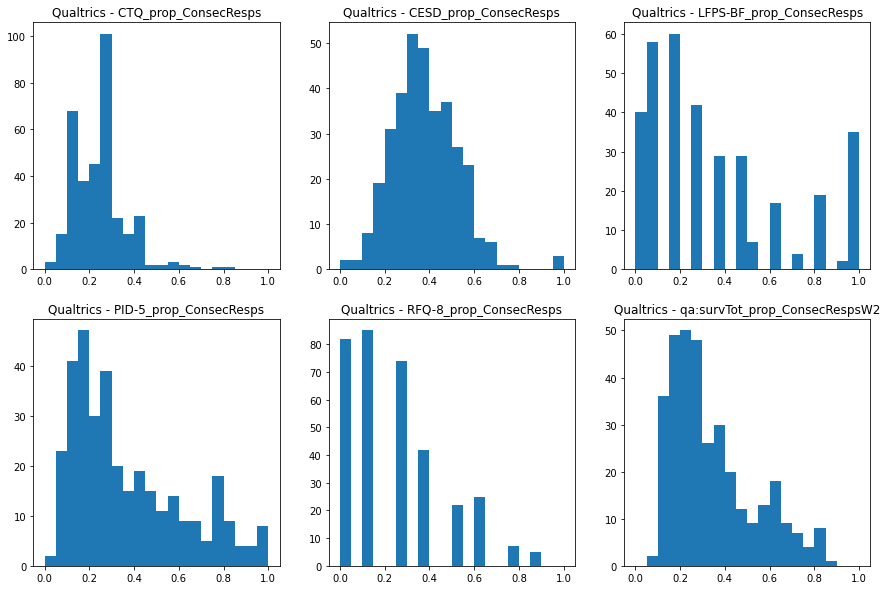

________________________________________________________________________________


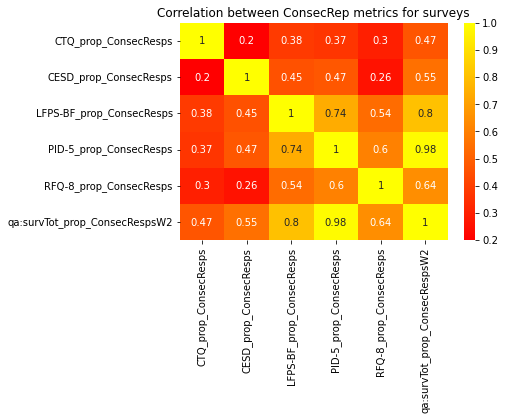

In [ ]:
print('Overall Survey Time:')
print('Mean/Median Duration (mins): {:0.2f}/{:0.2f}'.format(qSummW2.totalTimeW2.mean()/60,qSummW2.totalTimeW2.median()/60))
print('Min/Max Duration (mins): {:0.2f}/{:0.2f}'.format(qSummW2.totalTimeW2.min()/60, qSummW2.totalTimeW2.max()/60))
maxBin=np.ceil(qSummW2.totalTimeW2.max()/60/5)*5
binStep=np.ceil(maxBin/20)
plt.hist(qSummW2.totalTimeW2/60, bins=np.arange(0,maxBin+binStep,binStep))
plt.title('Overall Survey Duration')
plt.savefig('results/Overall_Survey_Duration.png')
plt.show()

print('_' * term_size)

fig,axs=plt.subplots(2,int(np.ceil(np.sum(qSummW2.columns.str.contains('prop_ConsecResps'))/2)), figsize=(np.sum(qSummW2.columns.str.contains('prop_ConsecResps'))/2*5,10))
for col, ax in zip(qSummW2.columns[qSummW2.columns.str.contains('prop_ConsecResps')],axs.flatten()):
    if 'Dur' in col:
        ax.hist(qSummW2[col], bins=25)
    else:
        ax.hist(qSummW2[col], bins=np.arange(0,1.01,.05))
    ax.set(title='Qualtrics - '+col)
plt.savefig('results/Qualtrics_Survey_QAmetrics.png')
plt.show()
print('_' * term_size)

qCorrDfW2=qSummW2.loc[:,qSummW2.columns.str.contains('prop_ConsecResps')].corr()
sns.heatmap(qCorrDfW2, xticklabels=qCorrDfW2.columns, yticklabels=qCorrDfW2.columns, annot=True, cmap='autumn')
plt.title('Correlation between ConsecRep metrics for surveys')
plt.savefig('results/qa_survey_consecRep_correlations.png')
plt.show()
# [print(i) for i in qDatW2.columns]
# qDatW2.loc[:,'Gender':'Colorblind_2_TEXT']

In [ ]:
# READ IN CB DATA
cbDat=[]
for subj in subjsW2:
    # for fname in glob.iglob('data/tf/tf_app_'+subj+'*2022*.csv'):
    for fname in glob.iglob('/Users/dstanley/Dropbox/gitlab/Pavlovia_curr_active/bpd_cybrbll/data/bpd_cybrbll_'+subj+'*2023*.csv'):
        cbDat.append(pd.read_csv(fname).apply(pd.to_numeric, errors='ignore'))

# Calculate Summary and Quality Assurance Metrics
cbMeanResp=pd.DataFrame(index=subjsW2, columns=np.r_[:225])
cbSumm=pd.DataFrame(index=subjsW2)
for i,dat in enumerate(cbDat):
    # print(i)
    PID=dat.subject_id[0]
    currDat=dat.query('trialtype=="choice" | trialtype=="observe"').copy()
    currDat.loc[currDat.key_press==2,'key_press']=3
    currDat.loc[currDat.key_press==currDat.unfairPartner.iloc[0],'key_press']=-1
    currDat.loc[currDat.key_press==currDat.fairPartner.iloc[0],'key_press']=1

    # currDat.loc[:,'fairPartner':'unfairPartner']=currDat.loc[:,'fairPartner':'unfairPartner'].replace()
    cbMeanResp.loc[PID,:]=currDat.key_press.transpose()
    cbSumm.loc[PID,'totalTime']=dat.totalTime[0]/1000
    cbSumm.loc[PID,'qa:prop_rt<300']=np.sum(currDat.rt<300)/currDat.rt.count()
    cbSumm.loc[PID,'qa:prop_ConsecResps']=(currDat.query('trialtype=="choice"').key_press.shift(-1)==currDat.query('trialtype=="choice"').key_press).sum()/(currDat.query('trialtype=="choice"').shape[0]-1)
    cbSumm.loc[PID,'qa:instruxDur']=np.round(dat[dat.trial_type=='instructions'].iloc[1].rt/1000,2)
    cbSumm.loc[PID,'qa:blurEv']=np.sum([dat.trialtype=='blurevent'])


In [ ]:
# READ IN LOTT DATA
lottDat=[]
for subj in subjsW2:
    # for fname in glob.iglob('data/tf/tf_app_'+subj+'*2022*.csv'):
    for fname in glob.iglob('/Users/dstanley/Dropbox/gitlab/Pavlovia_curr_active/bpd_lott/data/bpd_lott_'+subj+'*2023*.csv'):
        lottDat.append(pd.read_csv(fname).apply(pd.to_numeric, errors='ignore'))

# Calculate Summary and Quality Assurance Metrics
lottMeanResp=pd.DataFrame(index=subjsW2, columns=np.r_[:225])
lottSumm=pd.DataFrame(index=subjsW2)
for i,dat in enumerate(lottDat):
    # print(i)
    PID=dat.subject_id[0]
    currDat=dat.query('trialtype=="choice"').copy()
    # currDat.loc[currDat.key_press==2,'key_press']=3
    currDat.loc[currDat.chosen==currDat.unfairMachine.iloc[0],'key_press']=-1
    currDat.loc[currDat.chosen==currDat.fairMachine.iloc[0],'key_press']=1

    # currDat.loc[:,'fairPartner':'unfairPartner']=currDat.loc[:,'fairPartner':'unfairPartner'].replace()
    lottMeanResp.loc[PID,:]=currDat.key_press.transpose()
    lottSumm.loc[PID,'totalTime']=dat.totalTime[0]/1000
    lottSumm.loc[PID,'qa:prop_rt<300']=np.sum(currDat.rt<300)/currDat.rt.count()
    lottSumm.loc[PID,'qa:prop_ConsecResps']=(currDat.key_press.shift(-1)==currDat.key_press).sum()/(currDat.shape[0]-1)
    lottSumm.loc[PID,'qa:instruxDur']=np.round(dat[dat.trial_type=='instructions'].iloc[1].rt/1000,2)
    lottSumm.loc[PID,'qa:blurEv']=np.sum([dat.trialtype=='blurevent'])


In [ ]:
# READ IN TEMPORAL DISCOUNTING DATA
tdDat=[]
for subj in subjsW2:
    # for fname in glob.iglob('data/tf/tf_app_'+subj+'*2022*.csv'):
    for fname in glob.iglob('/Users/dstanley/Dropbox/gitlab/Pavlovia_curr_active/bpd_td/data/bpd_td_'+subj+'*2023*.csv'):
        tdDat.append(pd.read_csv(fname).apply(pd.to_numeric, errors='ignore'))

# Calculate Summary and Quality Assurance Metrics
tdSumm=pd.DataFrame(index=subjsW2)
for i,dat in enumerate(tdDat):
    # print(i)
    PID=dat.subject_id[0]
    currDat=dat.query('trialtype=="offer"').copy()
    tdSumm.loc[PID,'totalTime']=dat.totalTime[0]/1000
    tdSumm.loc[PID,'qa:prop_rt<300']=np.sum(currDat.rt<300)/currDat.rt.count()
    tdSumm.loc[PID,'qa:prop_ConsecResps']=(currDat.key_press.shift(-1)==currDat.key_press).sum()/(currDat.shape[0]-1)
    tdSumm.loc[PID,'qa:instruxDur']=np.round(dat[dat.trial_type=='instructions'].iloc[1].rt/1000,2)
    tdSumm.loc[PID,'qa:blurEv']=np.sum([dat.trialtype=='blurevent'])


In [ ]:
# READ IN SOCIAL DISCOUNTING DATA
sdDat=[]
for subj in subjsW2:
    # for fname in glob.iglob('data/tf/tf_app_'+subj+'*2022*.csv'):
    for fname in glob.iglob('/Users/dstanley/Dropbox/gitlab/Pavlovia_curr_active/bpd_sd/data/bpd_sd_'+subj+'*2023*.csv'):
        sdDat.append(pd.read_csv(fname).apply(pd.to_numeric, errors='ignore'))

# Calculate Summary and Quality Assurance Metrics
sdSumm=pd.DataFrame(index=subjsW2)
for i,dat in enumerate(sdDat):
    # print(i)
    PID=dat.subject_id[0]
    currDat=dat.query('trialtype=="offer"').copy()
    sdSumm.loc[PID,'totalTime']=dat.totalTime[0]/1000
    sdSumm.loc[PID,'qa:prop_rt<300']=np.sum(currDat.rt<300)/currDat.rt.count()
    sdSumm.loc[PID,'qa:prop_ConsecResps']=(currDat.key_press.shift(-1)==currDat.key_press).sum()/(currDat.shape[0]-1)
    sdSumm.loc[PID,'qa:instruxDur']=np.round(dat[dat.trial_type=='instructions'].iloc[1].rt/1000,2)
    sdSumm.loc[PID,'qa:blurEv']=np.sum([dat.trialtype=='blurevent'])


In [ ]:
# READ IN RISKY DECISION-MAKING DATA
rdDat=[]
for subj in subjsW2:
    # for fname in glob.iglob('data/tf/tf_app_'+subj+'*2022*.csv'):
    for fname in glob.iglob('/Users/dstanley/Dropbox/gitlab/Pavlovia_curr_active/bpd_rd/data/bpd_rd_'+subj+'*2023*.csv'):
        rdDat.append(pd.read_csv(fname).apply(pd.to_numeric, errors='ignore'))

# Calculate Summary and Quality Assurance Metrics
rdSumm=pd.DataFrame(index=subjsW2)
for i,dat in enumerate(rdDat):
    # print(i)
    PID=dat.subject_id[0]
    currDat=dat.query('trialtype=="offer"').copy()
    rdSumm.loc[PID,'totalTime']=dat.totalTime[0]/1000
    rdSumm.loc[PID,'qa:prop_rt<300']=np.sum(currDat.rt<300)/currDat.rt.count()
    rdSumm.loc[PID,'qa:prop_ConsecResps']=(currDat.key_press.shift(-1)==currDat.key_press).sum()/(currDat.shape[0]-1)
    rdSumm.loc[PID,'qa:instruxDur']=np.round(dat[dat.trial_type=='instructions'].iloc[1].rt/1000,2)
    rdSumm.loc[PID,'qa:blurEv']=np.sum([dat.trialtype=='blurevent'])


In [ ]:
# READ IN BEAUTY CONTEST DATA
bcDat=[]
for subj in subjsW2:
    # for fname in glob.iglob('data/tf/tf_app_'+subj+'*2022*.csv'):
    for fname in glob.iglob('/Users/dstanley/Dropbox/gitlab/Pavlovia_curr_active/bpd_bc/data/bpd_bc_'+subj+'*2023*.csv'):
        bcDat.append(pd.read_csv(fname).apply(pd.to_numeric, errors='ignore'))

# Calculate Summary and Quality Assurance Metrics
bcSumm=pd.DataFrame(index=subjsW2)
upper=['dec']*5+['%']*5+['abilRat']*5+['similRat']*5
lower =['complete strangers', 'other prolific workers', 'your acquaintances', 'your closest friends', 'your high school classmates']*4
multiCols=pd.MultiIndex.from_arrays([upper, lower], names=['varType', 'group'])
bcBehav=pd.DataFrame(index=subjsW2, columns=multiCols)

for i,dat in enumerate(bcDat):
    # print(i)
    PID=dat.subject_id[0]
    currDat=dat.query('trialtype=="decision" | trialtype=="simRating" | trialtype=="abilRating"').copy()
    bcSumm.loc[PID,'totalTime']=dat.totalTime[0]/1000
    bcSumm.loc[PID,'qa:prop_rt<300']=np.sum(currDat.rt<300)/currDat.rt.count()
    bcSumm.loc[PID,'qa:prop_ConsecResps']=(currDat.response.shift(-1)==currDat.response).sum()/(currDat.shape[0]-1)
    bcSumm.loc[PID,'qa:instruxDur']=np.round(dat[dat.trial_type=='instructions'].iloc[1:].rt.sum()/1000,2)
    bcSumm.loc[PID,'qa:blurEv']=np.sum([dat.trialtype=='blurevent'])
    tmp1=list(dat[dat.trial_type=='html-slider-response'].sort_values(['trialtype', 'group']).response)
    tmp2=list(dat[dat.trialtype=='decision'].sort_values(['group']).fraction.str[-3:].str.rstrip('%').astype(float)/100)
    bcBehav.loc[PID,:]=tmp1[5:10]+tmp2+tmp1[:5]+tmp1[10:]
    
# bcSumm.to_csv('bcQASumm_for_Jack.csv')
# bcBehav.to_csv('bcBehavDat_for_Jack.csv')

Dimensionality reduced to 75.76%


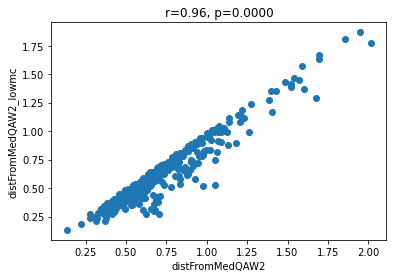

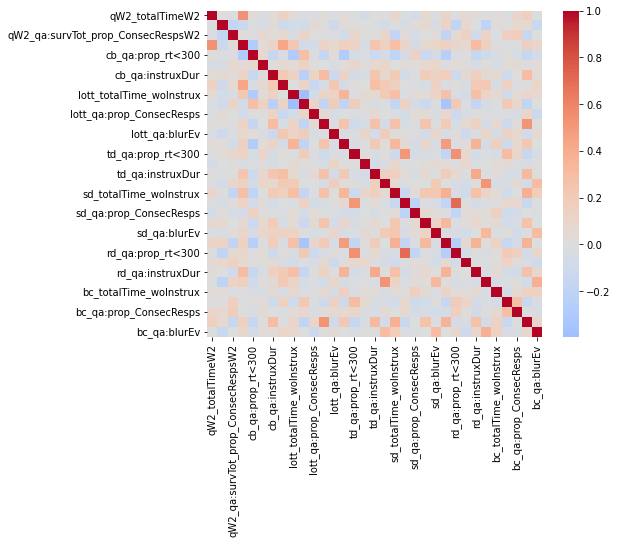

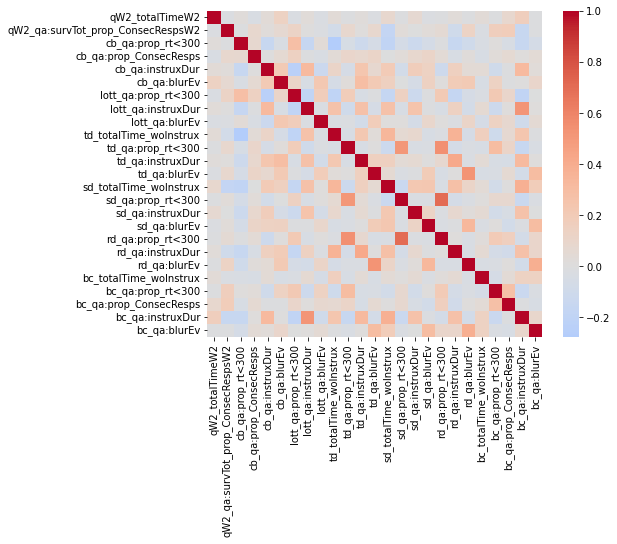

In [ ]:
# AGGREGATE QA METRICS INTO A SINGLE DF qaSumm

tmp=qSummW2[qSummW2.columns[qSummW2.columns.str.contains('Time') | qSummW2.columns.str.startswith('qa:')]]
tmp.columns=['qW2_{}'.format(i) for i in tmp.columns]
qaSummW2=tmp
tmp=cbSumm[cbSumm.columns[cbSumm.columns.str.contains('Time') | cbSumm.columns.str.startswith('qa:')]]
tmp.columns=['cb_{}'.format(i) for i in tmp.columns]
qaSummW2=qaSummW2.join(tmp)
tmp=lottSumm[lottSumm.columns[lottSumm.columns.str.contains('Time') | lottSumm.columns.str.startswith('qa:')]]
tmp.columns=['lott_{}'.format(i) for i in tmp.columns]
qaSummW2=qaSummW2.join(tmp)
tmp=tdSumm[tdSumm.columns[tdSumm.columns.str.contains('Time') | tdSumm.columns.str.startswith('qa:')]]
tmp.columns=['td_{}'.format(i) for i in tmp.columns]
qaSummW2=qaSummW2.join(tmp)
tmp=sdSumm[sdSumm.columns[sdSumm.columns.str.contains('Time') | sdSumm.columns.str.startswith('qa:')]]
tmp.columns=['sd_{}'.format(i) for i in tmp.columns]
qaSummW2=qaSummW2.join(tmp)
tmp=rdSumm[rdSumm.columns[rdSumm.columns.str.contains('Time') | rdSumm.columns.str.startswith('qa:')]]
tmp.columns=['rd_{}'.format(i) for i in tmp.columns]
qaSummW2=qaSummW2.join(tmp)
tmp=bcSumm[bcSumm.columns[bcSumm.columns.str.contains('Time') | bcSumm.columns.str.startswith('qa:')]]
tmp.columns=['bc_{}'.format(i) for i in tmp.columns]
qaSummW2=qaSummW2.join(tmp)

# Remove instruxDur from Total Time Estimates
qaSummW2['cb_totalTime']=qaSummW2['cb_totalTime']-qaSummW2['cb_qa:instruxDur']
qaSummW2['lott_totalTime']=qaSummW2['lott_totalTime']-qaSummW2['lott_qa:instruxDur']
qaSummW2['td_totalTime']=qaSummW2['td_totalTime']-qaSummW2['td_qa:instruxDur']
qaSummW2['sd_totalTime']=qaSummW2['sd_totalTime']-qaSummW2['sd_qa:instruxDur']
qaSummW2['rd_totalTime']=qaSummW2['rd_totalTime']-qaSummW2['rd_qa:instruxDur']
qaSummW2['bc_totalTime']=qaSummW2['bc_totalTime']-qaSummW2['bc_qa:instruxDur']
qaSummW2.rename(columns={'cb_totalTime':'cb_totalTime_woInstrux', 'lott_totalTime':'lott_totalTime_woInstrux', 'td_totalTime':'td_totalTime_woInstrux', 'sd_totalTime':'sd_totalTime_woInstrux', 'rd_totalTime':'rd_totalTime_woInstrux', 'bc_totalTime':'bc_totalTime_woInstrux'}, inplace=True)

# Create normalized (to the maximum value) DataFrame qaSummW2_nrm
qaSummW2_nrm=qaSummW2/qaSummW2.max()


# Calculate Variable Inflation Factors for all Quality Metrics and 
# if any are over 10, iteratively exclude the factor with the max val and recalculate
dropCols=[]
vifDat=qaSummW2_nrm.dropna()
vifMat=pd.DataFrame([[i,variance_inflation_factor(vifDat.values,j)] for i,j in zip(vifDat.columns, range(vifDat.shape[1]))], columns=['qaMeas','VIF'])
while vifMat['VIF'].max()>10:
    dropCols.append(np.array(vifMat.loc[vifMat['VIF']==vifMat['VIF'].max(),'qaMeas'])[0])
    vifDat=qaSummW2_nrm.drop(columns=dropCols).dropna()
    vifMat=pd.DataFrame([[i,variance_inflation_factor(vifDat.values,j)] for i,j in zip(vifDat.columns, range(vifDat.shape[1]))], columns=['qaMeas','VIF'])

qaSummW2_nrm_lowmc = qaSummW2_nrm.loc[:,vifDat.columns]

print('Dimensionality reduced to {:0.2f}%'.format(qaSummW2_nrm_lowmc.shape[1]/qaSummW2_nrm.shape[1]*100))

# Calculate Mean and Median
qaMeanW2=qaSummW2_nrm.mean()
qaMedW2=qaSummW2_nrm.median()
qaMeanW2_lowmc=qaSummW2_nrm_lowmc.mean()
qaMedW2_lowmc=qaSummW2_nrm_lowmc.median()


# Calculate metric of "Bad Subjects" based on Euclidean distance from Median QA metrics
qaSummW2['distFromMedQAW2']=[np.sqrt(np.sum((qaSummW2_nrm.loc[i,:]-qaMedW2)**2)) for i in qaSummW2_nrm.index]
qaSummW2['distFromMedQAW2_lowmc']=[np.sqrt(np.sum((qaSummW2_nrm_lowmc.loc[i,:]-qaMedW2_lowmc)**2)) for i in qaSummW2_nrm_lowmc.index]


r,p=stats.pearsonr(qaSummW2['distFromMedQAW2'], qaSummW2['distFromMedQAW2_lowmc'])
plt.scatter(qaSummW2['distFromMedQAW2'], qaSummW2['distFromMedQAW2_lowmc'])
plt.xlabel('distFromMedQAW2')
plt.ylabel('distFromMedQAW2_lowmc')
plt.title('r={:0.2f}, p={:0.4f}'.format(r,p))
plt.show()

plt.figure(figsize=(7.5, 6))
corr_matrix = qaSummW2_nrm.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.show()

plt.figure(figsize=(7.5, 6))
corr_matrix = qaSummW2_nrm_lowmc.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.show()

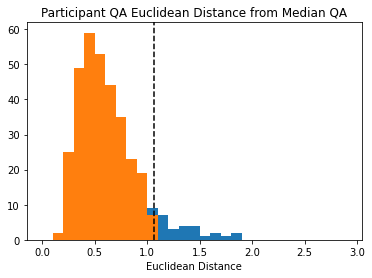

%7.60 removed


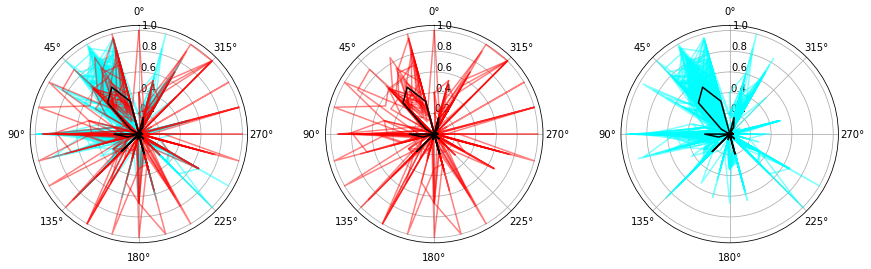

In [ ]:
# Set cutoff for BAD subjs based on distance from Median QA metrics
# IQR=np.diff(qaSumm['distFromMedQA'].quantile([.25, .75]))
# outlier=np.array(qaSumm['distFromMedQA'].quantile([.75])+IQR*1.5)[0]
# # cutoff=outlier
# cutoff=qaSummW2.distFromMedQAW2_lowmc.quantile(.85)
medianDistW2=qaSummW2.distFromMedQAW2_lowmc.median()
cutoffW2=medianDistW2+np.median(np.abs(qaSummW2.distFromMedQAW2_lowmc-medianDistW2))*3

# Histogram of Participant QA Euclidean distances from Median with cutoff illustrated
plt.hist(qaSummW2['distFromMedQAW2_lowmc'], bins=np.arange(0,3,.1))
plt.hist(qaSummW2.loc[qaSummW2['distFromMedQAW2_lowmc']<cutoffW2,'distFromMedQAW2_lowmc'], bins=np.arange(0,3,.1))
plt.axvline(x=cutoffW2, linestyle='--', color='k')
plt.title('Participant QA Euclidean Distance from Median QA')
plt.xlabel('Euclidean Distance')
plt.savefig('results/qaAnalysisW2_ptpDist_from_medQA.png')
plt.show()
print('%{:0.2f} removed'.format((1-np.sum(qaSummW2.distFromMedQAW2_lowmc<cutoffW2)/qaSummW2.shape[0])*100))

pltDatW2=qaSummW2_nrm_lowmc # alt=qaSummW2_nrm
pltDatMedW2=qaMedW2_lowmc # alt=qaMed
pltDatDistMetricW2='distFromMedQAW2_lowmc' # alt='distFromMedQA'

theta=np.linspace(0,2*np.pi,pltDatW2.shape[1])
fig,ax=plt.subplots(1,3,subplot_kw=dict(projection='polar'), figsize=(15,4))

ax[0].plot(theta,pltDatW2[qaSummW2[pltDatDistMetricW2]<cutoffW2].transpose(), color='cyan', alpha=.5)
ax[0].plot(theta,pltDatW2[qaSummW2[pltDatDistMetricW2]>=cutoffW2].transpose(), color='red', alpha=.5)
ax[0].plot(theta,pltDatMedW2, color='black')
ax[0].set_theta_zero_location('N')
ax[0].set_rlabel_position(ax[0].get_rlabel_position()-24)
# ax[0].set_xticks(np.r_[0,7,12,17, 20, 24]/31*2*np.pi)
# ax[0].set_xticklabels(['qual', 'trApp', 'trRat', 'trLrn', 'trFrat', 'wmem'])

ax[1].plot(theta,pltDatW2[qaSummW2[pltDatDistMetricW2]>=cutoffW2].transpose(), color='red', alpha=.5)
ax[1].plot(theta,pltDatMedW2, color='black')
ax[1].set_theta_zero_location('N')
ax[1].set_rlabel_position(ax[1].get_rlabel_position()-24)
# ax[1].set_xticks(np.r_[0,7,12,17, 20, 24]/31*2*np.pi)
# ax[1].set_xticklabels(['qual', 'trApp', 'trRat', 'trLrn', 'trFrat', 'wmem'])

ax[2].plot(theta,pltDatW2[qaSummW2[pltDatDistMetricW2]<cutoffW2].transpose(), color='cyan', alpha=.5)
# ax.plot(theta,qaSummW2_nrm.transpose(), alpha=.75)
ax[2].plot(theta,pltDatMedW2, color='black')
ax[2].set_theta_zero_location('N')
ax[2].set_rlabel_position(ax[2].get_rlabel_position()-24)
# ax[2].set_xticks(np.r_[0,7,12,17, 20, 24]/31*2*np.pi)
# ax[2].set_xticklabels(['qual', 'trApp', 'trRat', 'trLrn', 'trFrat', 'wmem'])
# plt.savefig('results/qaAnalysis_ptpDist_from_medQA_polar.png')
plt.show()

(0.4560532383524608, 5.713174249953119e-19)


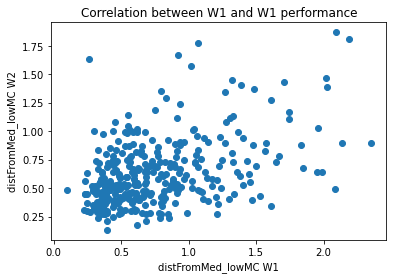

In [ ]:
# Create joined QA metric dataset (qaSummAll)
qaSummAll=qaSumm.join(qaSummW2)

qaSummAll['qAll_totalTime']=qaSummAll.q_totalTime+qaSummAll.qW2_totalTimeW2;
qaSummAll['qAll_qa:attChks']=qaSummAll['q_qa:attChks']+qaSummAll['qW2_qa:attChks'];
qaSummAll['qAll_qa:survTot_prop_ConsecResps']=(LEC_Atmp.sum()+BSItmp.sum()+CTQtmp.sum()+CESDtmp.sum()+LFPSBFtmp.sum()+PID5tmp.sum()+RFQ8tmp.sum())/(LEC_Atmp.shape[0]+BSItmp.shape[0]+CTQtmp.shape[0]+CESDtmp.shape[0]+LFPSBFtmp.shape[0]+PID5tmp.shape[0]+RFQ8tmp.shape[0])


keeprows=~qaSummAll.distFromMedQAW2_lowmc.isna()
print(stats.pearsonr(qaSummAll.distFromMedQA_lowmc[keeprows], qaSummAll.distFromMedQAW2_lowmc[keeprows]))
plt.scatter(qaSummAll.distFromMedQA_lowmc[keeprows], qaSummAll.distFromMedQAW2_lowmc[keeprows])
plt.xlabel('distFromMed_lowMC W1')
plt.ylabel('distFromMed_lowMC W2')
plt.title('Correlation between W1 and W1 performance')
plt.show()

Dimensionality reduced to 75.71%


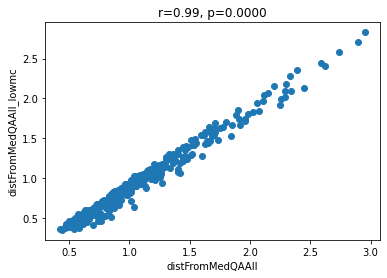

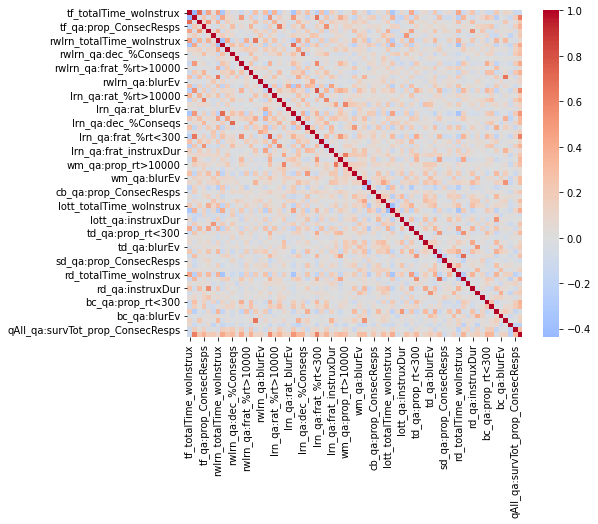

<AxesSubplot:>

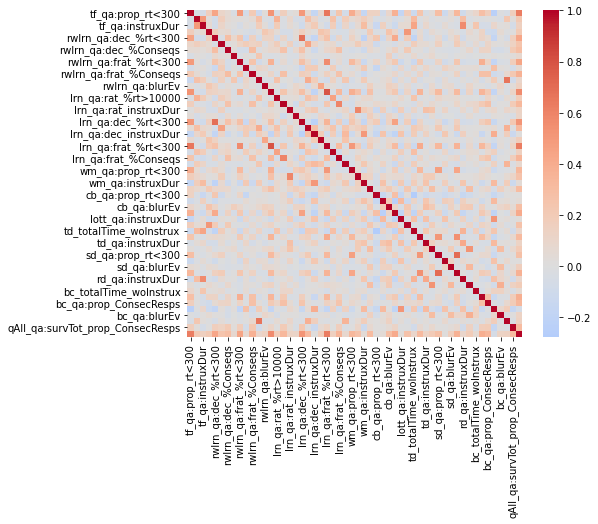

In [ ]:
# Create normalized (to the maximum value) DataFrame qaSummAll_nrm
cols2Drop=qaSummAll.columns[qaSummAll.columns.str.startswith('dist') | qaSummAll.columns.str.startswith('q_') | qaSummAll.columns.str.startswith('qW2_')]
qaSummAll_nrm=qaSummAll[~qaSummAll.qW2_totalTimeW2.isna()].drop(cols2Drop, axis=1)/qaSummAll[~qaSummAll.qW2_totalTimeW2.isna()].dropna().drop(cols2Drop, axis=1).max()

# Calculate Variable Inflation Factors for all Quality Metrics and 
# if any are over 10, iteratively exclude the factor with the max val and recalculate
dropCols=[]
vifDat=qaSummAll_nrm.dropna()
vifMat=pd.DataFrame([[i,variance_inflation_factor(vifDat.values,j)] for i,j in zip(vifDat.columns, range(vifDat.shape[1]))], columns=['qaMeas','VIF'])
while vifMat['VIF'].max()>10:
    dropCols.append(np.array(vifMat.loc[vifMat['VIF']==vifMat['VIF'].max(),'qaMeas'])[0])
    vifDat=qaSummAll_nrm.drop(columns=dropCols).dropna()
    vifMat=pd.DataFrame([[i,variance_inflation_factor(vifDat.values,j)] for i,j in zip(vifDat.columns, range(vifDat.shape[1]))], columns=['qaMeas','VIF'])

qaSummAll_nrm_lowmc = qaSummAll_nrm.loc[:,vifDat.columns]

print('Dimensionality reduced to {:0.2f}%'.format(qaSummAll_nrm_lowmc.shape[1]/qaSummAll_nrm.shape[1]*100))

# Calculate Mean and Median
qaMeanAll=qaSummAll_nrm.mean()
qaMedAll=qaSummAll_nrm.median()
qaMeanAll_lowmc=qaSummAll_nrm_lowmc.mean()
qaMedAll_lowmc=qaSummAll_nrm_lowmc.median()


# Calculate metric of "Bad Subjects" based on Euclidean distance from Median QA metrics
qaSummAll_nrm['distFromMedQAAll']=[np.sqrt(np.sum((qaSummAll_nrm.loc[i,:]-qaMedAll)**2)) for i in qaSummAll_nrm.index]
qaSummAll_nrm_lowmc['distFromMedQAAll_lowmc']=[np.sqrt(np.sum((qaSummAll_nrm_lowmc.loc[i,:]-qaMedAll_lowmc)**2)) for i in qaSummAll_nrm_lowmc.index]

qaSummAll=qaSummAll.join(qaSummAll_nrm['distFromMedQAAll']).join(qaSummAll_nrm_lowmc['distFromMedQAAll_lowmc'])


r,p=stats.pearsonr(qaSummAll['distFromMedQAAll'].dropna(), qaSummAll['distFromMedQAAll_lowmc'].dropna())
plt.scatter(qaSummAll['distFromMedQAAll'], qaSummAll['distFromMedQAAll_lowmc'])
plt.xlabel('distFromMedQAAll')
plt.ylabel('distFromMedQAAll_lowmc')
plt.title('r={:0.2f}, p={:0.4f}'.format(r,p))
plt.show()

plt.figure(figsize=(7.5, 6))
corr_matrix = qaSummAll_nrm.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.show()

plt.figure(figsize=(7.5, 6))
corr_matrix = qaSummAll_nrm_lowmc.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
# plt.show()scatter_plot_with_correlation(qaSummAll.distFromMedQAAll_lowmc, qaSummAll.distFromMedQAAll_lowmc, 'W1 v W2 lowmcMedDist')

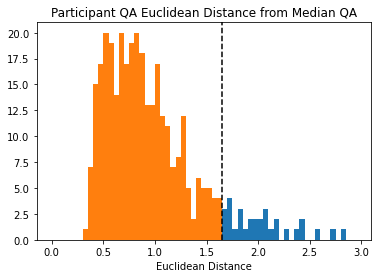

%9.06 removed


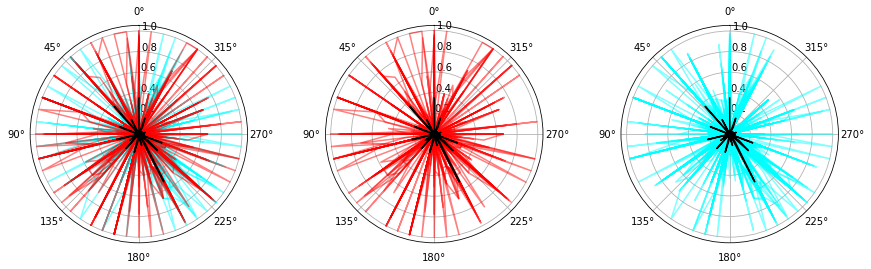

In [ ]:
# Set cutoff for BAD subjs based on distance from Median QA metrics
# IQR=np.diff(qaSumm['distFromMedQA'].quantile([.25, .75]))
# outlier=np.array(qaSumm['distFromMedQA'].quantile([.75])+IQR*1.5)[0]
# # cutoff=outlier
# cutoff=qaSummAll.distFromMedQAAll_lowmc.quantile(.85)
medianDistAll=qaSummAll.distFromMedQAAll_lowmc.median()
cutoffAll=medianDistAll+(np.abs(qaSummAll.distFromMedQAAll_lowmc-medianDistAll).median())*3

# Histogram of Participant QA Euclidean distances from Median with cutoff illustrated
plt.hist(qaSummAll['distFromMedQAAll_lowmc'], bins=np.arange(0,3,.05))
plt.hist(qaSummAll.loc[qaSummAll['distFromMedQAAll_lowmc']<cutoffAll,'distFromMedQAAll_lowmc'], bins=np.arange(0,3,.05))
plt.axvline(x=cutoffAll, linestyle='--', color='k')
plt.title('Participant QA Euclidean Distance from Median QA')
plt.xlabel('Euclidean Distance')
plt.savefig('results/qaAnalysisAll_ptpDist_from_medQA.png')
plt.show()
print('%{:0.2f} removed'.format((1-np.sum(qaSummAll.distFromMedQAAll_lowmc.dropna()<cutoffAll)/qaSummAll.distFromMedQAAll_lowmc.dropna().shape[0])*100))



pltDatAll=qaSummAll_nrm_lowmc.drop(columns=['distFromMedQAAll_lowmc']) # alt=qaSummW2_nrm
pltDatMedAll=qaMedAll_lowmc # alt=qaMed
pltDatDistMetricAll='distFromMedQAAll_lowmc' # alt='distFromMedQA'

theta=np.linspace(0,2*np.pi,pltDatAll.shape[1])
fig,ax=plt.subplots(1,3,subplot_kw=dict(projection='polar'), figsize=(15,4))

ax[0].plot(theta,pltDatAll[qaSummAll_nrm_lowmc[pltDatDistMetricAll]<cutoffAll].transpose(), color='cyan', alpha=.5)
ax[0].plot(theta,pltDatAll[qaSummAll_nrm_lowmc[pltDatDistMetricAll]>=cutoffAll].transpose(), color='red', alpha=.5)
ax[0].plot(theta,pltDatMedAll, color='black')
ax[0].set_theta_zero_location('N')
ax[0].set_rlabel_position(ax[0].get_rlabel_position()-24)
# ax[0].set_xticks(np.r_[0,7,12,17, 20, 24]/31*2*np.pi)
# ax[0].set_xticklabels(['qual', 'trApp', 'trRat', 'trLrn', 'trFrat', 'wmem'])

ax[1].plot(theta,pltDatAll[qaSummAll_nrm_lowmc[pltDatDistMetricAll]>=cutoffAll].transpose(), color='red', alpha=.5)
ax[1].plot(theta,pltDatMedAll, color='black')
ax[1].set_theta_zero_location('N')
ax[1].set_rlabel_position(ax[1].get_rlabel_position()-24)
# ax[1].set_xticks(np.r_[0,7,12,17, 20, 24]/31*2*np.pi)
# ax[1].set_xticklabels(['qual', 'trApp', 'trRat', 'trLrn', 'trFrat', 'wmem'])

ax[2].plot(theta,pltDatAll[qaSummAll_nrm_lowmc[pltDatDistMetricAll]<cutoffAll].transpose(), color='cyan', alpha=.5)
# ax.plot(theta,qaSummW2_nrm.transpose(), alpha=.75)
ax[2].plot(theta,pltDatMedAll, color='black')
ax[2].set_theta_zero_location('N')
ax[2].set_rlabel_position(ax[2].get_rlabel_position()-24)
# ax[2].set_xticks(np.r_[0,7,12,17, 20, 24]/31*2*np.pi)
# ax[2].set_xticklabels(['qual', 'trApp', 'trRat', 'trLrn', 'trFrat', 'wmem'])
# plt.savefig('results/qaAnalysis_ptpDist_from_medQA_polar.png')
plt.show()

In [ ]:
qaSummAll['distFromMedQA_lowMC_gtMADCutOff_badSub']=(qaSummAll['distFromMedQA_lowmc']>cutoffW1).astype(int)
qaSummAll['distFromMedQA_lowMC_ltMADCutOff_goodSub']=(qaSummAll['distFromMedQA_lowmc']<cutoffW1).astype(int)
qaSummAll['distFromMedQAW2_lowMC_gtMADCutOff_badSub']=(qaSummAll['distFromMedQAW2_lowmc']>cutoffW2).astype(int)
qaSummAll['distFromMedQAW2_lowMC_ltMADCutOff_goodSub']=(qaSummAll['distFromMedQAW2_lowmc']<cutoffW2).astype(int)
qaSummAll['distFromMedQAAll_lowMC_gtMADCutOff_badSub']=(qaSummAll['distFromMedQAAll_lowmc']>cutoffAll).astype(int)
qaSummAll['distFromMedQAAll_lowMC_ltMADCutOff_goodSub']=(qaSummAll['distFromMedQAAll_lowmc']<cutoffAll).astype(int)


for col in qaSummAll.columns[qaSummAll.columns.str.endswith('lowmc')]:
    qaSummAll[col+'_top5pct']=(qaSummAll[col]>qaSummAll[col].quantile(.95)).astype(int)
    qaSummAll[col+'_top10pct']=(qaSummAll[col]>qaSummAll[col].quantile(.9)).astype(int)
    qaSummAll[col+'_top15pct']=(qaSummAll[col]>qaSummAll[col].quantile(.85)).astype(int)
    qaSummAll[col+'_bot95pct']=(qaSummAll[col]<qaSummAll[col].quantile(.95)).astype(int)
    qaSummAll[col+'_bot90pct']=(qaSummAll[col]<qaSummAll[col].quantile(.9)).astype(int)
    qaSummAll[col+'_bot85pct']=(qaSummAll[col]<qaSummAll[col].quantile(.85)).astype(int)

qaSummAll_4Exp=qaSummAll.loc[:,qaSummAll.columns.str.startswith('distFromMed')].join(qaSummAll.loc[:,qaSummAll.columns.str.startswith('q')]).join(qaSummAll.loc[:,~(qaSummAll.columns.str.startswith('distFromMed') | qaSummAll.columns.str.startswith('q'))])

# qaSummAll_4Exp.to_csv('allQAMetrics.csv')
[i for i in qaSummAll_4Exp.columns]

['distFromMedQA',
 'distFromMedQA_lowmc',
 'distFromMedQAW2',
 'distFromMedQAW2_lowmc',
 'distFromMedQAAll',
 'distFromMedQAAll_lowmc',
 'distFromMedQA_lowMC_gtMADCutOff_badSub',
 'distFromMedQA_lowMC_ltMADCutOff_goodSub',
 'distFromMedQAW2_lowMC_gtMADCutOff_badSub',
 'distFromMedQAW2_lowMC_ltMADCutOff_goodSub',
 'distFromMedQAAll_lowMC_gtMADCutOff_badSub',
 'distFromMedQAAll_lowMC_ltMADCutOff_goodSub',
 'distFromMedQA_lowmc_top5pct',
 'distFromMedQA_lowmc_top10pct',
 'distFromMedQA_lowmc_top15pct',
 'distFromMedQA_lowmc_bot95pct',
 'distFromMedQA_lowmc_bot90pct',
 'distFromMedQA_lowmc_bot85pct',
 'distFromMedQAW2_lowmc_top5pct',
 'distFromMedQAW2_lowmc_top10pct',
 'distFromMedQAW2_lowmc_top15pct',
 'distFromMedQAW2_lowmc_bot95pct',
 'distFromMedQAW2_lowmc_bot90pct',
 'distFromMedQAW2_lowmc_bot85pct',
 'distFromMedQAAll_lowmc_top5pct',
 'distFromMedQAAll_lowmc_top10pct',
 'distFromMedQAAll_lowmc_top15pct',
 'distFromMedQAAll_lowmc_bot95pct',
 'distFromMedQAAll_lowmc_bot90pct',
 'distFr

In [ ]:
summScores=pd.read_csv('SCIDPCLScores.csv').set_index('PROLIFIC_PID', drop=True)

In [ ]:
BSIDat=qDat.loc[:, qDat.columns.str.contains('BSI')].drop(columns=['BSIDT', 'ACBSI'])

def calcBSIDimScore(BSIDat, inputArray):
    out = ((BSIDat.iloc[:,np.array(inputArray)-1]-1).sum(axis=1)/((BSIDat.iloc[:,np.array(inputArray)-1]-1)>0).sum(axis=1))/12*4
    out[out.isna()]=0
    
    return out


BSIDat['Somatization']=calcBSIDimScore(BSIDat, [2, 7, 23, 29, 30, 33, 37])
BSIDat['Obsession-Compulsion'] =calcBSIDimScore(BSIDat, [5, 15, 26, 27, 32, 36])
BSIDat['Interpersonal Sensitivity'] =calcBSIDimScore(BSIDat, [20, 21, 22, 42])
BSIDat['Depression'] =calcBSIDimScore(BSIDat, [9, 16, 17, 18, 35, 50])
BSIDat['Anxiety'] =calcBSIDimScore(BSIDat, [1, 12, 19, 38, 45, 49])
BSIDat['Hostility'] =calcBSIDimScore(BSIDat, [6, 13, 40, 41, 46])
BSIDat['Phobic'] =calcBSIDimScore(BSIDat, [8, 28, 31, 43, 47])
BSIDat['Paranoid Ideation'] =calcBSIDimScore(BSIDat, [4, 10, 24, 48, 51])
BSIDat['Psychoticism'] =calcBSIDimScore(BSIDat, [3, 14, 34, 44, 53])
BSIDat['GSI']=(BSIDat.loc[:,BSIDat.columns.str.contains('BSI')]-1).mean(axis=1)/12*4
BSIDat['PDT']=((BSIDat.loc[:,BSIDat.columns.str.contains('BSI')]-1)>0).sum(axis=1)
BSIDat['PSDI']=calcBSIDimScore(BSIDat, np.r_[1:54])

summScores=summScores.join(BSIDat.loc[:,'Somatization':].add_prefix('BSI_'))


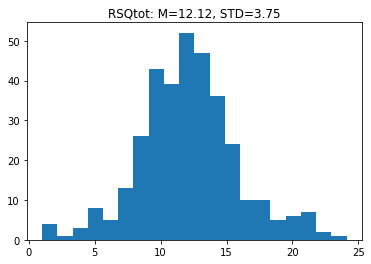

In [ ]:
RSQDat=(qDatW2.loc[:,qDatW2.columns.str.contains('RSQ')].drop(columns=['RSQDT'])-1)/12*5+1
RSQDat=RSQDat.join(pd.DataFrame(np.array(RSQDat.loc[:,RSQDat.columns.str.endswith('.1')])*(7-np.array(RSQDat.loc[:,RSQDat.columns.str.endswith('.2')])), index=RSQDat.index, columns=['RSQ'+str(i) for i in np.r_[1:15]]))

RSQDat['RSQ_total']=RSQDat.loc[:,'RSQ1':].mean(axis=1)
RSQDat['RSQ_Rejection']=RSQDat.loc[:,RSQDat.columns.str.endswith('.1')].mean(axis=1)
RSQDat['RSQ_Expectance']=RSQDat.loc[:,RSQDat.columns.str.endswith('.2')].mean(axis=1)
RSQDat['RSQ_Upset']=RSQDat.loc[:,RSQDat.columns.str.endswith('.3')].mean(axis=1)
plt.hist(RSQDat['RSQ_total'], bins=20)
plt.title(f'RSQtot: M={RSQDat["RSQ_total"].mean():0.2f}, STD={RSQDat["RSQ_total"].std():0.2f}')
plt.show()

summScores=summScores.join(RSQDat.loc[:,'RSQ_total':])


In [ ]:
PID5=(qDatW2.loc[:,qDatW2.columns.str.startswith('PID-5')].drop(columns=['PID-5-FBF_66'])-1)/12*3
PID5['fAnhedonia']= PID5.iloc[:,np.r_[ 9, 11, 43, 65]-1].mean(axis=1)
PID5['fAnxiousness']= PID5.iloc[:,np.r_[ 24, 36, 48, 78]-1].mean(axis=1)
PID5['fAttention_Seeking']= PID5.iloc[:,np.r_[ 23, 77, 87, 97]-1].mean(axis=1)
PID5['fCallousness']= PID5.iloc[:,np.r_[ 7, 62, 72, 82]-1].mean(axis=1)
PID5['fDeceitfulness']= PID5.iloc[:,np.r_[ 18, 51, 95, 99]-1].mean(axis=1)
PID5['fDepressivity']= PID5.iloc[:,np.r_[ 26, 60, 70, 74]-1].mean(axis=1)
PID5['fDistractability']= PID5.iloc[:,np.r_[ 39, 49, 55, 91]-1].mean(axis=1)
PID5['fEccentricity']= PID5.iloc[:,np.r_[ 10, 22, 61, 94]-1].mean(axis=1)
PID5['fEmotional_Lability']= PID5.iloc[:,np.r_[ 41, 53, 71, 81]-1].mean(axis=1)
PID5['fGrandiosity']= PID5.iloc[:,np.r_[ 14, 37, 85, 90]-1].mean(axis=1)
PID5['fHostility']= PID5.iloc[:,np.r_[ 12, 31, 66, 75]-1].mean(axis=1)
PID5['fImpulsivity']= PID5.iloc[:,np.r_[ 2, 5, 6, 8]-1].mean(axis=1)
PID5['fIntimacy_Avoidance']= PID5.iloc[:,np.r_[ 29, 40, 56, 93]-1].mean(axis=1)
PID5['fIrresponsibility']= PID5.iloc[:,np.r_[ 47, 64, 68, 76]-1].mean(axis=1)
PID5['fManipulativeness']= PID5.iloc[:,np.r_[ 35, 44, 69, 100]-1].mean(axis=1)
PID5['fPerceptual_Dysregulation']= PID5.iloc[:,np.r_[ 15, 63, 88, 98]-1].mean(axis=1)
PID5['fPerseveration']= PID5.iloc[:,np.r_[ 19, 25, 32, 46]-1].mean(axis=1)
PID5['fRestricted_Affectivity']= PID5.iloc[:,np.r_[ 28, 30, 73, 83]-1].mean(axis=1)
PID5['fRigid_Perfectionism']= PID5.iloc[:,np.r_[ 33, 42, 80, 89]-1].mean(axis=1)
PID5['fRisk_Taking']= PID5.iloc[:,np.r_[ 13, 16, 21, 67]-1].mean(axis=1)
PID5['fSeparation_Insecurity']= PID5.iloc[:,np.r_[ 17, 45, 58, 79]-1].mean(axis=1)
PID5['fSubmissiveness']= PID5.iloc[:,np.r_[ 3, 4, 20, 92]-1].mean(axis=1)
PID5['fSuspiciousness']= PID5.iloc[:,np.r_[ 1, 38, 50, 86]-1].mean(axis=1)
PID5['fUnusual_Beliefs_and_Experiences']= PID5.iloc[:,np.r_[ 34, 54, 59, 96]-1].mean(axis=1)
PID5['fWithdrawal']= PID5.iloc[:,np.r_[27, 52, 57, 84]-1].mean(axis=1)
PID5['dNegative_Affect']= PID5.loc[:, ['fEmotional_Lability', 'fAnxiousness', 'fSeparation_Insecurity']].mean(axis=1)
PID5['dDetachment']= PID5.loc[:, ['fWithdrawal', 'fAnhedonia', 'fIntimacy_Avoidance']].mean(axis=1)
PID5['dAntagonism']= PID5.loc[:, ['fManipulativeness', 'fDeceitfulness', 'fGrandiosity']].mean(axis=1)
PID5['dDisinhibition']= PID5.loc[:, ['fIrresponsibility', 'fImpulsivity', 'fDistractability']].mean(axis=1)
PID5['dPsychoticism']= PID5.loc[:, ['fUnusual_Beliefs_and_Experiences', 'fEccentricity', 'fPerceptual_Dysregulation']].mean(axis=1)

summScores=summScores.join(PID5.loc[:,'fAnhedonia':].add_prefix('PID5_'))


In [ ]:
# print((qDatW2.loc[:,qDatW2.columns.str.contains('RFQ-8_')].loc[:,:'RFQ-8_6']-1)/12*6+1)
RFQ_C=4-((qDatW2.loc[:,qDatW2.columns.str.contains('RFQ-8_')].loc[:,:'RFQ-8_6']-1)/12*6+1)
RFQ_C[RFQ_C<0]=0
RFQ_C=RFQ_C.mean(axis=1)

# print((qDatW2.loc[:,qDatW2.columns.str.contains('RFQ-8_')].loc[:,['RFQ-8_2', 'RFQ-8_4', 'RFQ-8_5', 'RFQ-8_6', 'RFQ-8_8', 'RFQ-8_7']]-1)/12*6+1)
RFQ_U=((qDatW2.loc[:,qDatW2.columns.str.contains('RFQ-8_')].loc[:,['RFQ-8_2', 'RFQ-8_4', 'RFQ-8_5', 'RFQ-8_6', 'RFQ-8_8']]-1)/12*6+1-4)
RFQ_U=RFQ_U.join(4-((qDatW2.loc[:,'RFQ-8_7']-1)/12*6+1))
RFQ_U[RFQ_U<0]=0
RFQ_U=RFQ_U.mean(axis=1)

summScores=summScores.join(pd.concat({'RFQ_C':RFQ_C, 'RFQ_U':RFQ_U}, axis=1))


In [ ]:
CESD=(qDatW2.loc[:,qDatW2.columns.str.startswith('CES_D')]-1)
CESD.loc[:,['CES_D_4','CES_D_8','CES_D_12','CES_D_16']]=3-CESD.loc[:,['CES_D_4','CES_D_8','CES_D_12','CES_D_16']]
CESD['CESDtot']=CESD.sum(axis=1)
# CES_D_tot.name='CES_D_tot'

summScores=summScores.join(CESD['CESDtot'])

In [ ]:
LPFS_BF2=(qDatW2.loc[:,qDatW2.columns.str.startswith('LPFS-')]-1)/12*3
LPFS_BF2['LPFS_BF2_total']=LPFS_BF2.loc[:,:'LPFS-BF 2.0_12'].mean(axis=1)
LPFS_BF2['LPFS_BF2_SF']=LPFS_BF2.loc[:,:'LPFS-BF 2.0_6'].mean(axis=1)
LPFS_BF2['LPFS_BF2_IF']=LPFS_BF2.loc[:,'LPFS-BF 2.0_7':'LPFS-BF 2.0_12'].mean(axis=1)


summScores=summScores.join(LPFS_BF2.loc[:, 'LPFS_BF2_total':])

In [ ]:
CTQ=(qDatW2.loc[:,qDatW2.columns.str.startswith('CTQ')].drop(columns='CTQDT')-1)/12*4+1
# print(CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1])
CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1]=6-CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1]
# print(CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1])
CTQ['CTQ_total']=CTQ.sum(axis=1)
CTQ['CTQ_emotAb']=CTQ.iloc[:,np.r_[3,8,14,18,25]-1].sum(axis=1)
CTQ['CTQ_physAb']=CTQ.iloc[:,np.r_[9,11,12,15,17]-1].sum(axis=1)
CTQ['CTQ_sexAb']=CTQ.iloc[:,np.r_[20,21,23,24,27]-1].sum(axis=1)
CTQ['CTQ_emotNeg']=CTQ.iloc[:,np.r_[5,7,13,19,28]-1].sum(axis=1)
CTQ['CTQ_physNeg']=CTQ.iloc[:,np.r_[1,2,4,6,26]-1].sum(axis=1)
CTQ['CTQ_minDen']=(CTQ.iloc[:,np.r_[10,16,22]-1]>4).sum(axis=1)

summScores=summScores.join(CTQ.loc[:, 'CTQ_total':])

In [ ]:
UCLA_LS3=(qDatW2.loc[:,qDatW2.columns.str.startswith('UCLA-LS3-')]-1)/12*2+1
UCLA_LS3['UCLA_LS3_total']=UCLA_LS3.sum(axis=1)

summScores=summScores.join(UCLA_LS3.loc[:, 'UCLA_LS3_total':])

STOP HERE

In [ ]:
bcBehav['dec'].loc[qaSummW2.distFromMedQAW2_lowmc<cutoffW2,['complete strangers', 'other prolific workers', 'your acquaintances', 'your high school classmates', 'your closest friends']].mean()
bcBehav.columns
# bcBehav['%'].loc[qaSummW2.distFromMedQAW2_lowmc<cutoffW2,['complete strangers', 'other prolific workers', 'your acquaintances', 'your high school classmates', 'your closest friends']].mean()
# bcBehav['abilRat'].loc[qaSummW2.distFromMedQAW2_lowmc<cutoffW2,['complete strangers', 'other prolific workers', 'your acquaintances', 'your high school classmates', 'your closest friends']].mean()
# bcBehav['similRat'].loc[qaSummW2.distFromMedQAW2_lowmc<cutoffW2,['complete strangers', 'other prolific workers', 'your acquaintances', 'your high school classmates', 'your closest friends']].mean()
bcBehav[['dec','%']].stack()

varType                                                  %   dec
PROLIFIC_PID             group                                  
63d6873b65a6170d64a652f6 complete strangers           0.67  60.0
                         other prolific workers        0.5  54.0
                         your acquaintances           0.33  40.0
                         your closest friends         0.25  37.0
                         your high school classmates  0.75  39.0
...                                                    ...   ...
611343092396f1d9ed7018ad complete strangers            0.5  50.0
                         other prolific workers       0.75  57.0
                         your acquaintances           0.67  37.0
                         your closest friends         0.25  14.0
                         your high school classmates  0.33  21.0

[1690 rows x 2 columns]

In [ ]:
cbSumm

totalTime  qa:prop_rt<300  qa:prop_ConsecResps  \
PROLIFIC_PID                                                               
63d6873b65a6170d64a652f6    460.064        0.385714             0.608696   
572041d6fd3a5200093c1295    438.740        0.477612             0.469697   
58016c9f551314000145af58    656.532        0.171429             0.231884   
63d41088860131e49a85cfac    631.776        0.089552             0.515152   
63d881ab484805569b553bd8    424.700        0.585714             0.347826   
...                             ...             ...                  ...   
60fcd9368e8d2b8740cf9251    459.362        0.578125             0.365079   
5d69d7e23aed95001b1aa05c    459.587        0.347826             0.411765   
63eeaedb26e599e86e8f7929    520.422        0.109589             0.555556   
62acc04d0a7788636b0e9915    434.811        0.555556             0.370968   
611343092396f1d9ed7018ad    452.613        0.671429             0.492754   

                          qa:instruxDur  qa:blurEv  
PROLIFIC_PID                                        
63d6873b65a6170d64a652f6          36.96        0.0  
572041d6fd3a5200093c1295          26.74        0.0  
58016c9f551314000145af58         180.07        1.0  
63d41088860131e49a85cfac          12.23        0.0  
63d881ab484805569b553bd8          24.69        0.0  
...                                 ...        ...  
60fcd9368e8d2b8740cf9251          50.25        0.0  
5d69d7e23aed95001b1aa05c          25.65        0.0  
63eeaedb26e599e86e8f7929          51.55        0.0  
62acc04d0a7788636b0e9915          29.44        0.0  
611343092396f1d9ed7018ad          38.09        0.0  

[342 rows x 5 columns]

In [ ]:
datForAndrea=pd.DataFrame(index=qDat.index)
datForAndrea=datForAndrea.join(qaSummAll.loc[:,['distFromMedQA_lowMC_ltMADCutOff_goodSub','distFromMedQAAll_lowMC_ltMADCutOff_goodSub',]])
datForAndrea=datForAndrea.join(demoG.loc[:,['Age','Race','HLS_ethnicity','BirthSex','Education',]])
datForAndrea=datForAndrea.join(qDat.loc[:,['LEC-A_6','LEC-A_7','LEC-A_8','LEC-A_9','LEC-A_10','LEC-A_11','LEC-A_17','LEC-6-FU-Age','LEC-7-FU-Age','LEC-8-FU-Age','LEC-9-FU-Age','LEC-10-FU-Age','LEC-11-FU-Age','LEC-16-FU-Age',]])
tmp=lrnSumm[['rat_mean', 'rat_std',]+list(lrnSumm.columns[lrnSumm.columns.str.startswith('subj')])+list(lrnSumm.columns[lrnSumm.columns.str.startswith('BIC')])]
tmp.columns=['trust_{}'.format(i) for i in tmp.columns]
datForAndrea=datForAndrea.join(tmp)
tmp=rwlrnSumm[list(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('subj')])+list(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('BIC')])]
tmp.columns=['lott_{}'.format(i) for i in tmp.columns]
datForAndrea=datForAndrea.join(tmp)
tmp=tfSumm[list(tfSumm.columns[tfSumm.columns.str.startswith('fit')])]
tmp.columns=['trustDiscrim_{}'.format(i) for i in tmp.columns]
datForAndrea=datForAndrea.join(tmp)
datForAndrea.to_csv('datForAndreaMerged.csv')
datForAndrea.columns

Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'Age', 'Race',
       'HLS_ethnicity', 'BirthSex', 'Education', 'LEC-A_6', 'LEC-A_7',
       'LEC-A_8', 'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_17',
       'LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age',
       'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-16-FU-Age', 'trust_rat_mean',
       'trust_rat_std', 'trustDiscrim_fitOffset', 'trustDiscrim_fitScale',
       'trustDiscrim_fitSlope'],
      dtype='object')

In [ ]:
tmp=datForAndrea.loc[:,datForAndrea.columns.str.contains('LEC-A')]

In [ ]:
datForAndrea.loc[:,datForAndrea.columns.str.contains('LEC-A')]=tmp.applymap(lambda x: 1 if '1' in str(x) else 0)

In [ ]:
datForAndrea.to_csv('datForAndreaMerged_qDat.csv')

In [ ]:
# lrnSumm.columns
# demoG.columns
# rwlrnSumm.columns
# tfSumm

Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'Age', 'Race',
       'HLS_ethnicity', 'BirthSex', 'Education', 'LEC-A_6', 'LEC-A_7',
       'LEC-A_8', 'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_16',
       'LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age',
       'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-16-FU-Age', 'trust_rat_mean',
       'trust_rat_std', 'trust_subjLR_bOC', 'trust_subjD_bOC',
       'trust_subjNLL_bOC', 'trust_subjLRTp_bOC', 'trust_subjLR_3prm',
       'trust_subjD_3prm', 'trust_subjp0_3prm', 'trust_subjNLL_3prm',
       'trust_subjLRTp_3prm', 'trust_BIC_bOC', 'trust_BIC_3prm',
       'lott_subjLR_bOC', 'lott_subjD_bOC', 'lott_subjNLL_bOC',
       'lott_subjLRTp_bOC', 'lott_subjLR_3prm', 'lott_subjD_3prm',
       'lott_subjp0_3prm', 'lott_subjNLL_3prm', 'lott_subjLRTp_3prm',
       'lott_BIC_bOC', 'lott_BIC_3prm', 'trustDiscrim_fitOffset',
       'trustDiscrim_fitScale', 'trustDiscrim_fitSlope'],
     

In [ ]:
# allLrnSumm.loc[:,['tr_rat_mean', 'tr_rat_std',]]
allLrnSumm.columns
tmp=wmemSumm[wmemSumm.columns[wmemSumm.columns.str.contains('Time') | wmemSumm.columns.str.startswith('qa:')]]
tmp.columns=['wm_{}'.format(i) for i in tmp.columns]
qaSumm=qaSumm.join(tmp)

NameError: name 'allLrnSumm' is not defined

In [ ]:
qaSummAll.to_csv('dataQAMetrics_4Andrea.csv')
summScores.to_csv('summaryScores_4Andrea.csv')
demoG.to_csv('demographics_4Andrea.csv')
qDat.to_csv('session1_QualtricsData_4Andrea.csv')
qDatW2.to_csv('session2_QualtricsData_4Andrea.csv')

'PROLIFIC_PID',          
datForAndrea=pd.DataFrame(index=qDat.index)        
qaSummAll.loc[:,['distFromMedQA_lowMC_ltMADCutOff_goodSub','distFromMedQAAll_lowMC_ltMADCutOff_goodSub',]].join


In [ ]:
def plot_demographics_v6(data, title="Demographic Distribution", labels=None, colors=None, explode=None, order=None, loc=None, bboxAnchor=None):
    """
    Generate a pie plot for demographic data with percentage text appearing directly under the label text.

    Parameters:
    - data: A list of counts for each demographic group.
    - title: The title for the plot.
    - labels: A list of labels for each demographic group.
    - colors: A list of colors for each demographic group. If None, it will default to the ColorBrewer2 set.
    - explode: A list of how far to offset each slice.
    """
    # Default ColorBrewer2 set for color-blind friendly colors
    default_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
    
    # Reorder data, labels, colors, and explode values by ascending data values
    if order is None:
        sorted_indices = np.argsort(data)[::-1]
    else:
        sorted_indices=order
        
    data = [np.array(data)[i] for i in sorted_indices]
    
    
    if labels is not None:
        labels = [labels[i] for i in sorted_indices]
    if colors is None:
        colors = default_colors[:len(data)]
    else:
        colors = [colors[i] for i in sorted_indices]
    if explode is not None:
        explode = [explode[i] for i in sorted_indices]
    if loc is None:
        loc="best"

    # Function to format labels and autopct together

    labelsWPct=["{} ({:.1f}%)".format(i, j/np.sum(data)*100) for i,j in zip(labels, data)]
    
    # rel_values = [val/sum(data) * 100 for val in data]
    
    # Plot
    plt.figure(figsize=(12, 7))
    wedges, texts, autotexts=plt.pie(data, labels=None, colors=colors, explode=explode, autopct='%1.1f%%',
            pctdistance=.8, startangle=140, wedgeprops=dict(width=0.3),
            textprops=dict(size=14), radius=0.75, labeldistance=1.05)
    plt.title(title, size=16)
    plt.legend(labelsWPct, loc=loc, bbox_to_anchor=bboxAnchor)
    plt.setp(autotexts, size=14, weight='bold')  # Adjusting the autopct size and weight
    plt.show()

# # Plotting using the updated function
# plot_demographics_v6(demographic_counts, "Race of Participants", demographic_labels, explode=explode)

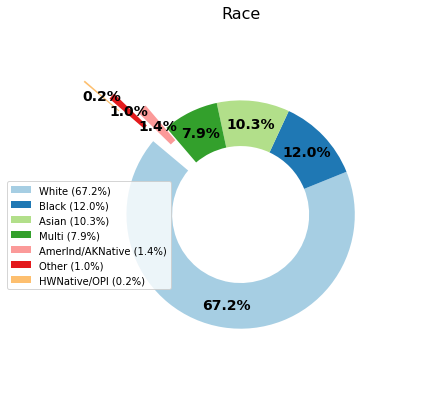

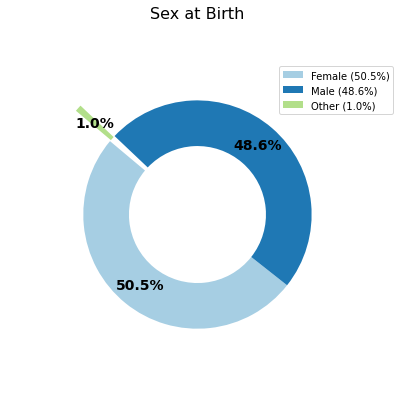

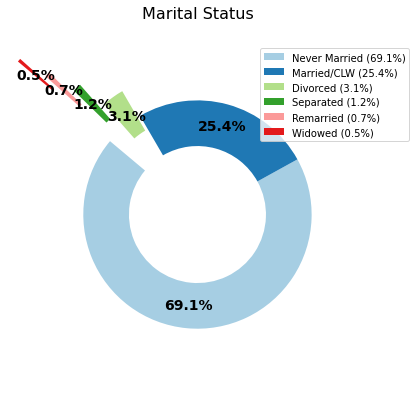

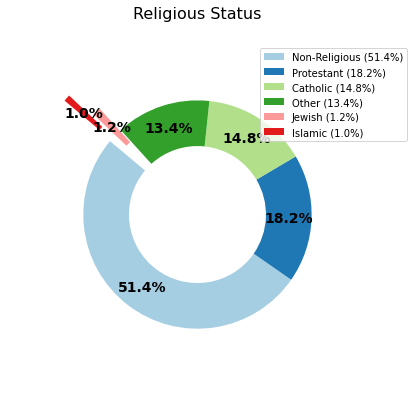

In [ ]:
raceLabels=['AmerInd/AKNative', 'Asian', 'Black', 'HWNative/OPI', 'White', 'Multi', 'Other']
explode=[.2, 0, 0, .6, 0, 0, .4]
plot_demographics_v6(demoG.groupby('Race').Age.count(), title='Race', labels=raceLabels, explode=explode, bboxAnchor=(0.33,.6))

SABlabels=['Male', 'Female', 'Other']
explode=[0,0,.3]
plot_demographics_v6(demoG.groupby('BirthSex').count().Age, title='Sex at Birth', labels=SABlabels, explode=explode, bboxAnchor=(.7,.75))

HLSlabels=['Hispanic/Latine', 'Not Hispanic/Latine']
explode=[0,0]
plot_demographics_v6(demoG.groupby('HLS_ethnicity').count().Age, title='HLS Ethnicity', labels=HLSlabels, explode=explode, bboxAnchor=(.7,.75), order=[0,1])

MaritStatlabels=['Married/CLW', 'Remarried', 'Widowed', 'Separated', 'Divorced', 'Never Married']
explode=[0,.6, .8, .4, .2, 0]
plot_demographics_v6(demoG.groupby('Marital_Status').count().Age, title='Marital Status', labels=MaritStatlabels, explode=explode, loc='upper left', bboxAnchor=(.65,.95))

Emplabels=['Full Time (35+)', 'Part Time (Reg)', 'Part Time (Irreg)', 'Student', 'Military', 'Ret/Disab', 'Unemployed']
explode=[0, 0, 0, 0, .3, 0, 0]
plot_demographics_v6(demoG.groupby('Employment').count().Age, title='Employment Status', labels=Emplabels, explode=explode, loc='upper left', bboxAnchor=(.65,.95))

Rellabels=['Catholic', 'Protestant', 'Jewish', 'Islamic', 'Other', 'Non-Religious']
explode=[0, 0, .2, .4, 0, 0]
plot_demographics_v6(demoG.groupby('Religion').count().Age, title='Religious Status', labels=Rellabels, explode=explode, loc='upper left', bboxAnchor=(.65,.95))


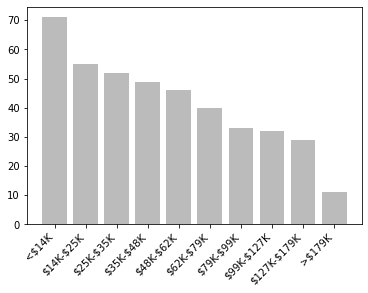

In [ ]:
counts=demoG.Income.reset_index(drop=True).value_counts()
order=np.r_[:counts.index.shape[0]]
labels=['<$14K', '\$14K-\$25K', '\$25K-\$35K', '\$35K-\$48K', '\$48K-\$62K', '\$62K-\$79K', '\$79K-\$99K', '\$99K-\$127K', '\$127K-\$179K', '>$179K']
plt.bar(labels, np.array(counts)[order], align='center', alpha=1, color='#bbbbbb')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# plot_bar_counts(demoG.Income.reset_index(drop=True))
plot_histogram(demoG.Age, bin_start=18, bin_end=61, bin_step=2)
print('Age: Mean={:.2f}, Median={:.2f}, STD={:.2f}'.format(demoG.Age.mean(), demoG.Age.median(), demoG.Age.std()))

Age: Mean=29.94, Median=29.00, STD=7.38


In [ ]:
plot_histogram(qaSummAll.distFromMedQA_lowmc[qaSummAll['distFromMedQAAll_lowmc'].isna()])
plot_histogram(qaSummAll.distFromMedQA_lowmc[~qaSummAll.distFromMedQAAll_lowmc.isna()])

In [ ]:
qSummAll=qSumm.join(qSummW2.rename(columns={'qa:attChks': 'qa:attChksW2'}), how='inner')
# qaSummAll=qaSumm.loc[qSummAll.index,:]

In [ ]:
plt.hist(qDat.Age.astype(int), bins=np.r_[16:60])
plt.title('Age of Participants')
plt.axvline(x=18, linestyle='--', color='k')
plt.axvline(x=45, linestyle='--', color='k')
# plt.savefig('final/results/Overall_Survey_Duration.png')
plt.show()
print('Mean/Med: {:0.2f}/{:0.2f}'.format(np.mean(qDat.Age.astype(int)), np.median(qDat.Age.astype(int))))
print()

# plt.hist(qDat.BirthSex.astype(int))
# plt.title('Birth Sex of Participants')
print(qDat['BirthSex'].value_counts())

Mean/Med: 29.94/29.00

2.0    211
1.0    203
4.0      4
Name: BirthSex, dtype: int64


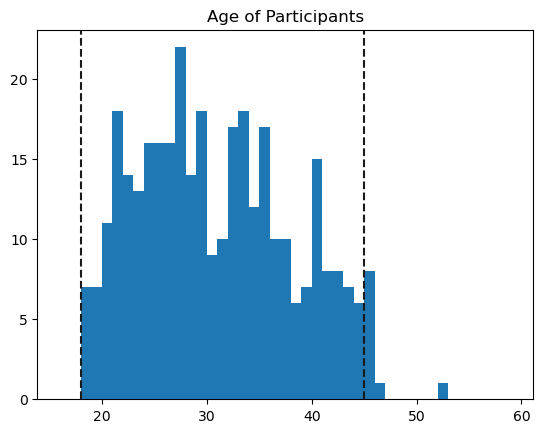

Mean/Med: 30.44/29.00

1.0    171
2.0    167
4.0      4
Name: BirthSex, dtype: int64


In [ ]:
plt.hist(qDat.loc[qSummAll.index,'Age'].astype(int), bins=np.r_[16:60])
plt.title('Age of Participants')
plt.axvline(x=18, linestyle='--', color='k')
plt.axvline(x=45, linestyle='--', color='k')
# plt.savefig('final/results/Overall_Survey_Duration.png')
plt.show()
print('Mean/Med: {:0.2f}/{:0.2f}'.format(np.mean(qDat.loc[qSummAll.index,:].Age.astype(int)), np.median(qDat.loc[qSummAll.index,:].Age.astype(int))))
print()

# plt.hist(qDat.BirthSex.astype(int))
# plt.title('Birth Sex of Participants')
print(qDat.loc[qSummAll.index,'BirthSex'].value_counts())

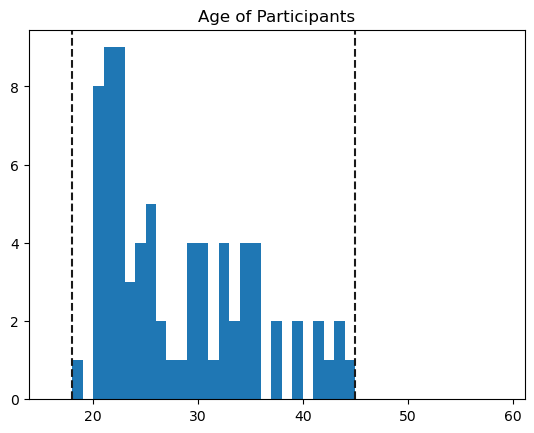

Mean/Med: 27.70/25.00

2.0    44
1.0    32
Name: BirthSex, dtype: int64


In [ ]:
plt.hist(qDat.loc[~qaSumm.index.isin(qSummAll.index),'Age'].astype(int), bins=np.r_[16:60])
plt.title('Age of Participants')
plt.axvline(x=18, linestyle='--', color='k')
plt.axvline(x=45, linestyle='--', color='k')
# plt.savefig('final/results/Overall_Survey_Duration.png')
plt.show()
print('Mean/Med: {:0.2f}/{:0.2f}'.format(np.mean(qDat.loc[~qaSumm.index.isin(qSummAll.index),:].Age.astype(int)), np.median(qDat.loc[~qaSumm.index.isin(qSummAll.index),:].Age.astype(int))))
print()

# plt.hist(qDat.BirthSex.astype(int))
# plt.title('Birth Sex of Participants')
print(qDat.loc[~qaSumm.index.isin(qSummAll.index),'BirthSex'].value_counts())

In [ ]:
print(f'Mean Age: {qDat.Age.mean():.02f} StDev: {qDat.Age.std():.02f}')
print('\n')
print(qDat.Race.value_counts())
print('\n')
print(qDat.BirthSex.value_counts())
print('\n')
print(qDat.HLS_ethnicity.value_counts())
print('\n')
print(qDat.Education.value_counts())
print('\n')
print(qDat.Income.value_counts())

Mean Age: 29.94 StDev: 7.38


5.0    281
3.0     50
2.0     43
6.0     33
1.0      6
7.0      4
4.0      1
Name: Race, dtype: int64


2.0    211
1.0    203
4.0      4
Name: BirthSex, dtype: int64


2.0    361
1.0     57
Name: HLS_ethnicity, dtype: int64


16.0    128
12.0     99
13.0     70
14.0     42
18.0     33
15.0     20
20.0      9
19.0      6
11.0      5
10.0      2
7.0       2
17.0      2
Name: Education, dtype: int64


5.0     71
4.0     55
1.0     52
6.0     49
3.0     46
2.0     40
7.0     33
9.0     32
8.0     29
10.0    11
Name: Income, dtype: int64


In [ ]:
print(qDat.StartDate.min())
print(qDat.StartDate.max())
print(qDatW2.StartDate.min())
print(qDatW2.StartDate.max())

2023-03-10 14:04:21
2023-04-08 12:59:28
2023-03-24 19:10:51
2023-04-16 21:30:59


RESTART

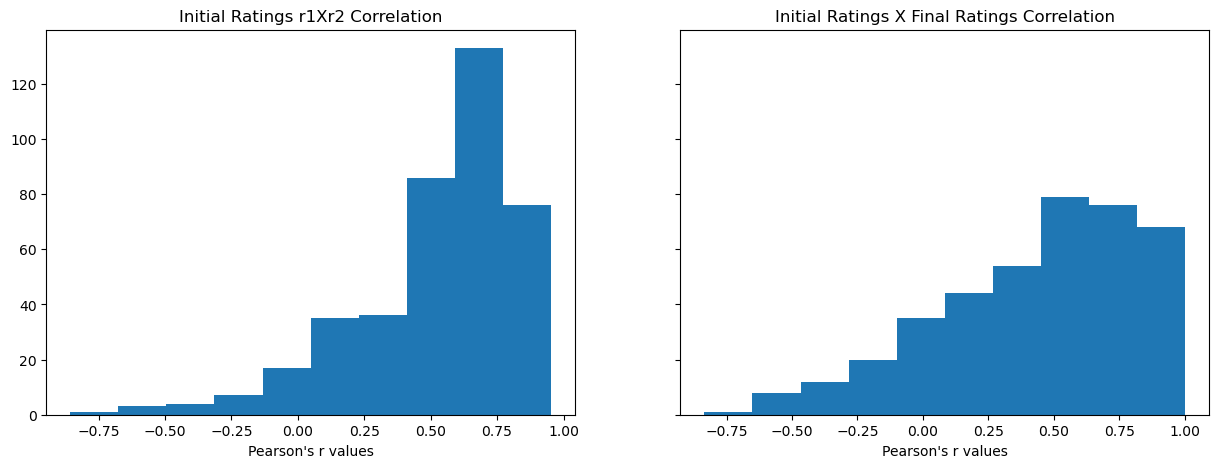

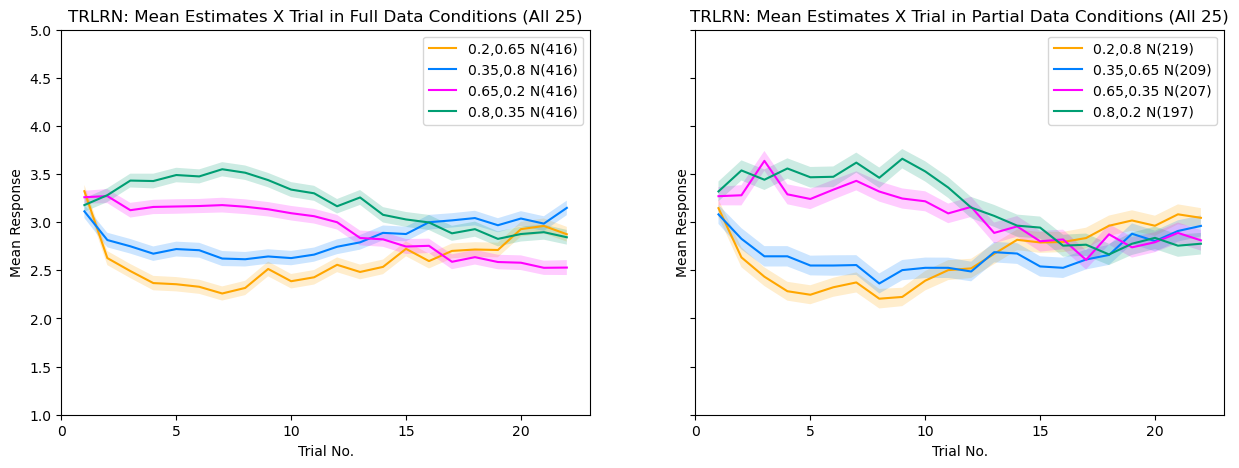

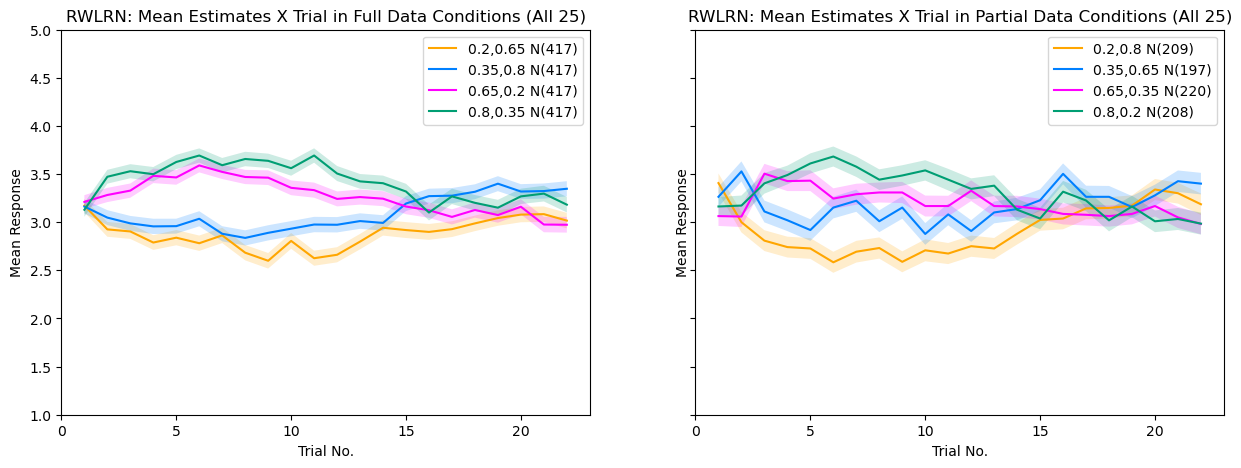

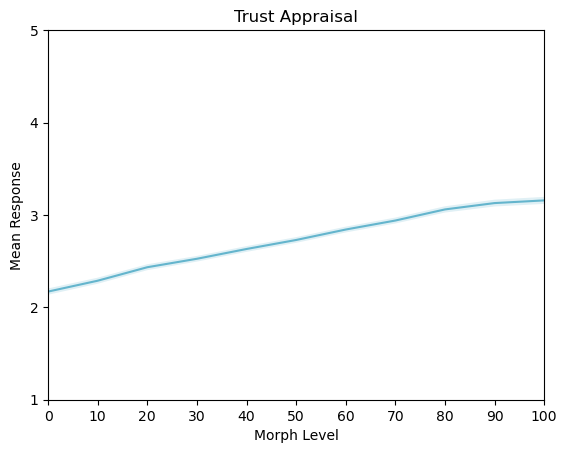

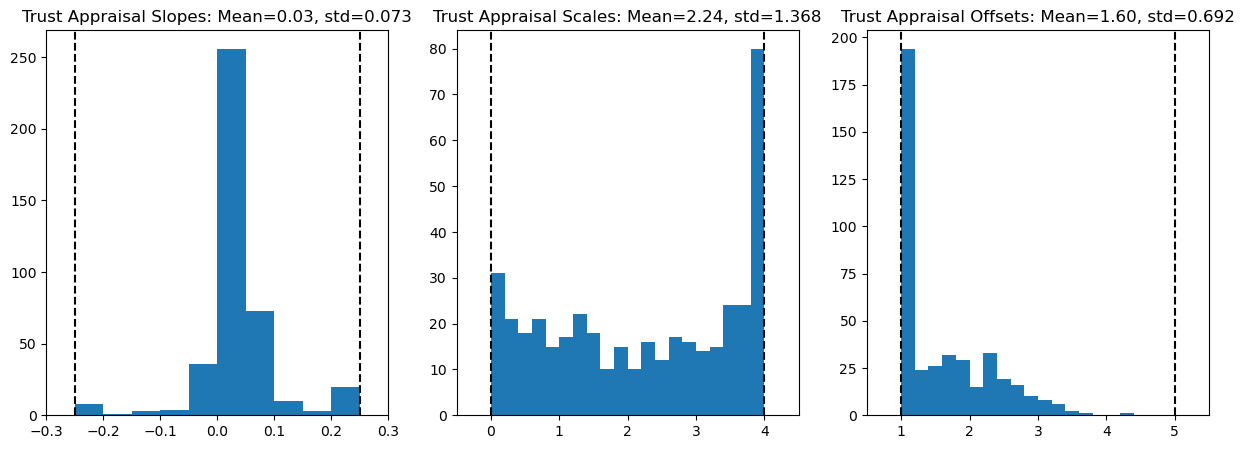

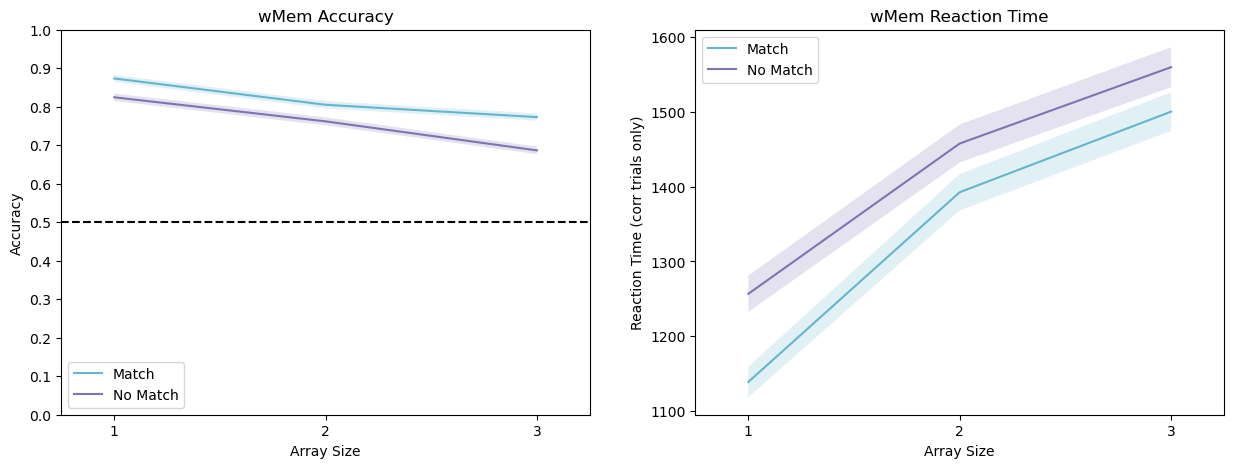

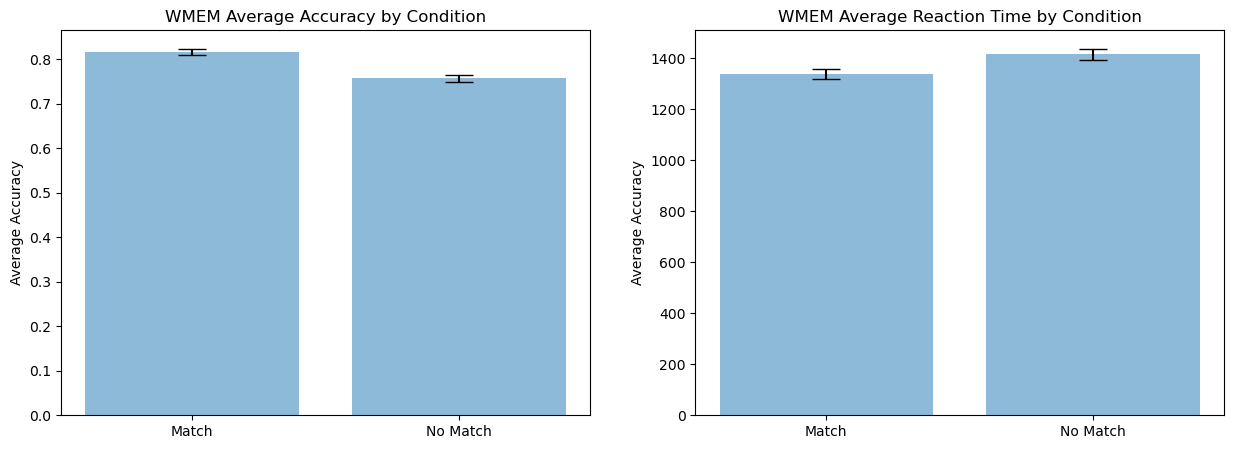

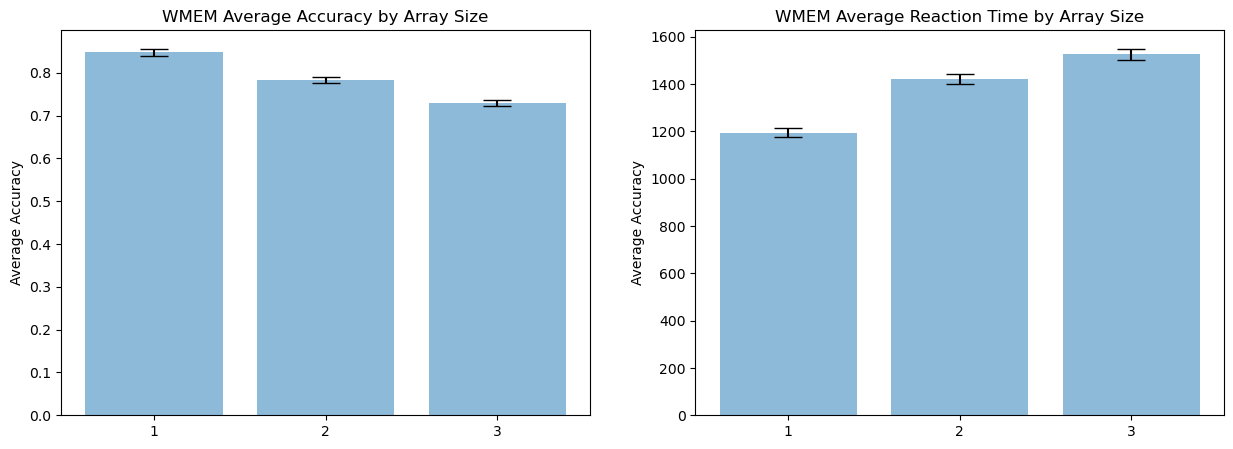

In [ ]:
# PLOT TRUST RATING AND LEARNING PERFORMANCE
plt.rcdefaults()
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)

ax[0].hist(lrnSumm.rat_r1r2_corr_r)
ax[0].set(title='Initial Ratings r1Xr2 Correlation',
         xlabel='Pearson\'s r values')
ax[1].hist(lrnSumm.frat_r1r2_corr_r)
ax[1].set(title='Initial Ratings X Final Ratings Correlation',
         xlabel='Pearson\'s r values')
plt.savefig('final/results/Trust_interrating_correalation.png')
plt.show()

fullCols=['0.2,0.65', '0.35,0.8', '0.65,0.2', '0.8,0.35'] 
subsetCols=['0.2,0.8', '0.35,0.65', '0.65,0.35', '0.8,0.2']
trials=np.r_[1:23]
colors=np.array([[1,.65,0], [0,.5,1], [1,0,1], [0,158/255,115/255]])

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
for col, color in zip(fullCols,colors):
    ax[0].plot(trials,meanSumm.loc[:,col],color=color, label=col+' N({:d})'.format(cntSumm.loc[0,col]))
    ax[0].fill_between(trials,meanSumm.loc[:,col]-steSumm.loc[:,col],meanSumm.loc[:,col]+steSumm.loc[:,col], facecolor=color, alpha=0.2)
ax[0].set(xlim=[0,23],
        ylim=[1,5],
        title='TRLRN: Mean Estimates X Trial in Full Data Conditions (All 25)',
        xlabel='Trial No.',
        ylabel='Mean Response',)
ax[0].legend(loc='best')

for col, color in zip(subsetCols,colors):
    ax[1].plot(trials,meanSumm.loc[:,col],color=color, label=col+' N({:d})'.format(cntSumm.loc[0,col]))
    ax[1].fill_between(trials,meanSumm.loc[:,col]-steSumm.loc[:,col],meanSumm.loc[:,col]+steSumm.loc[:,col], facecolor=color, alpha=0.2)
ax[1].set(xlim=[0,23],
        ylim=[1,5],
        title='TRLRN: Mean Estimates X Trial in Partial Data Conditions (All 25)',
        xlabel='Trial No.',
        ylabel='Mean Response',)
ax[1].legend(loc='best')

plt.savefig('final/results/TRLRN_Mean_Estimates_all.png')
plt.show()

# PLOT LOTTERY LEARNING PERFORMANCE
fullCols=['0.2,0.65', '0.35,0.8', '0.65,0.2', '0.8,0.35'] 
subsetCols=['0.2,0.8', '0.35,0.65', '0.65,0.35', '0.8,0.2']
trials=np.r_[1:23]
colors=np.array([[1,.65,0], [0,.5,1], [1,0,1], [0,158/255,115/255]])

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
for col, color in zip(fullCols,colors):
    ax[0].plot(trials,rwmeanSumm.loc[:,col],color=color, label=col+' N({:d})'.format(rwcntSumm.loc[0,col]))
    ax[0].fill_between(trials,rwmeanSumm.loc[:,col]-rwsteSumm.loc[:,col],rwmeanSumm.loc[:,col]+rwsteSumm.loc[:,col], facecolor=color, alpha=0.2)
ax[0].set(xlim=[0,23],
        ylim=[1,5],
        title='RWLRN: Mean Estimates X Trial in Full Data Conditions (All 25)',
        xlabel='Trial No.',
        ylabel='Mean Response',)
ax[0].legend(loc='best')

for col, color in zip(subsetCols,colors):
    ax[1].plot(trials,rwmeanSumm.loc[:,col],color=color, label=col+' N({:d})'.format(rwcntSumm.loc[0,col]))
    ax[1].fill_between(trials,rwmeanSumm.loc[:,col]-rwsteSumm.loc[:,col],rwmeanSumm.loc[:,col]+rwsteSumm.loc[:,col], facecolor=color, alpha=0.2)
ax[1].set(xlim=[0,23],
        ylim=[1,5],
        title='RWLRN: Mean Estimates X Trial in Partial Data Conditions (All 25)',
        xlabel='Trial No.',
        ylabel='Mean Response',)
ax[1].legend(loc='best')

plt.savefig('final/results/RWLRN_Mean_Estimates_all.png')
plt.show()

# PLOT TRUST APPRAISAL PERFORMANCE
plotSubjCurves=False;

fig, ax = plt.subplots()
ax.plot(np.arange(0,101,10),tfMeanResp.mean(),'c-')
ax.fill_between(np.arange(0,101,10),tfMeanResp.mean()-tfMeanResp.std()/np.sqrt(len(tfDat)),tfMeanResp.mean()+tfMeanResp.std()/np.sqrt(len(tfDat)), facecolor='c', alpha=0.2)
ax.set(xlim=[0,100],
        ylim=[1,5],
        title='Trust Appraisal',
        xlabel='Morph Level',
        ylabel='Mean Response',
        yticks=np.arange(1,6),
        xticks=np.arange(0,101,10),
      )
plt.savefig('final/results/Trust_Appraisal_Mean_Performance.png')
plt.show()

if plotSubjCurves:
    fig,axs=plt.subplots(ncols=10, nrows=int(np.floor(len(subjs)/10)+1), figsize=(25,150), sharey=True, sharex=True, facecolor='white')
    for PID,ax  in zip(subjs,axs.flatten()):
        # PID='6282571cf39cd89341a474e9'
        ax.plot(tfMeanResp.loc[PID,:], '.')
        ax.plot(np.arange(0,101,1),sigmoid(np.arange(0,101,1),tfSumm.loc[PID,'fitOffset'], tfSumm.loc[PID,'fitScale'], tfSumm.loc[PID,'fitSlope']))
        ax.set(title='{}:\noffset={:0.4f}, scale={:0.4f}, slope={:0.4f}'.format(PID[:5],tfSumm.loc[PID,'fitOffset'], tfSumm.loc[PID,'fitScale'], tfSumm.loc[PID,'fitSlope']),
               ylim=[1,5],
              yticks=[1,2,3,4,5],
              xticks=[0,25,50,75,100],)

    plt.savefig('final/results/Trust_Appraisal_Sigmoid_Fits.png')
    plt.show()

fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].hist(tfSumm.fitSlope, bins=np.r_[tfSlopeBounds[0]:tfSlopeBounds[1]+.02:.05])
ax[0].axvline(tfSlopeBounds[0], linestyle='dashed', color='black')
ax[0].axvline(tfSlopeBounds[1], linestyle='dashed', color='black')
ax[0].set(title='Trust Appraisal Slopes: Mean={:.02f}, std={:.03f}'.format(tfSumm.fitSlope.mean(), tfSumm.fitSlope.std()),
      xlim=[tfSlopeBounds[0]-.05, tfSlopeBounds[1]+.05])

ax[1].hist(tfSumm.fitScale, bins=np.r_[tfScaleBounds[0]:tfScaleBounds[1]+.2:.2])
ax[1].axvline(tfScaleBounds[0], linestyle='dashed', color='black')
ax[1].axvline(tfScaleBounds[1], linestyle='dashed', color='black')
ax[1].set(title='Trust Appraisal Scales: Mean={:.02f}, std={:.03f}'.format(tfSumm.fitScale.mean(), tfSumm.fitScale.std()),
      xlim=[tfScaleBounds[0]-.5, tfScaleBounds[1]+.5])

ax[2].hist(tfSumm.fitOffset, bins=np.r_[tfOffsetBounds[0]:tfOffsetBounds[1]+.2:.2])
ax[2].axvline(tfOffsetBounds[0], linestyle='dashed', color='black')
ax[2].axvline(tfOffsetBounds[1], linestyle='dashed', color='black')
ax[2].set(title='Trust Appraisal Offsets: Mean={:.02f}, std={:.03f}'.format(tfSumm.fitOffset.mean(), tfSumm.fitOffset.std()),
      xlim=[tfOffsetBounds[0]-.5, tfOffsetBounds[1]+.5])

plt.savefig('final/results/Trust_Appraisal_Sigmoid_Fit_Param_Dists.png')
plt.show()

# PLOT WMEM PERFORMANCE

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(wmAcc_mu['Match'], color='c', label='Match')
ax[0].fill_between(np.arange(1,4),wmAcc_mu['Match']-wmAcc_ste['Match'],wmAcc_mu['Match']+wmAcc_ste['Match'], facecolor='c', alpha=0.2)
ax[0].plot(wmAcc_mu['No Match'], color='m', label='No Match')
ax[0].fill_between(np.arange(1,4),wmAcc_mu['No Match']-wmAcc_ste['No Match'],wmAcc_mu['No Match']+wmAcc_ste['No Match'], facecolor='m', alpha=0.2)
ax[0].set(xlim=[0.75,3.25],
        ylim=[0,1],
        title='wMem Accuracy',
        xlabel='Array Size',
        ylabel='Accuracy',
        yticks=np.arange(0,1.01,.1),
        xticks=np.arange(1,4),
      )
ax[0].hlines([.5], .75,3.25, linestyles='dashed', color='black')
ax[0].legend(loc='lower left')

ax[1].plot(wmRt_mu['Match'], color='c', label='Match')
ax[1].fill_between(np.arange(1,4),wmRt_mu['Match']-wmRt_ste['Match'],wmRt_mu['Match']+wmRt_ste['Match'], facecolor='c', alpha=0.2)
ax[1].plot(wmRt_mu['No Match'], color='m', label='No Match')
ax[1].fill_between(np.arange(1,4),wmRt_mu['No Match']-wmRt_ste['No Match'],wmRt_mu['No Match']+wmRt_ste['No Match'], facecolor='m', alpha=0.2)
ax[1].set(xlim=[0.75,3.25],
        # ylim=[0,1],
        title='wMem Reaction Time',
        xlabel='Array Size',
        ylabel='Reaction Time (corr trials only)',
        # yticks=np.arange(0,1.01,.1),
        xticks=np.arange(1,4),
      )
ax[1].legend(loc='upper left')
plt.savefig('results/wmem_Performance_condXArrSize.png')
plt.show()


# build the plot
fig, ax = plt.subplots(1,2,figsize=(15,5))
labels=['Match', 'No Match']
dat=wmemSumm.loc[:,wmemSumm.columns.str.startswith('cond acc:')]
ax[0].bar(np.arange(len(labels)),dat.mean(), yerr=dat.std()/np.sqrt(dat.count()), align='center', alpha=0.5, ecolor='black', capsize=10)
ax[0].set_ylabel('Average Accuracy')
ax[0].set_xticks(np.arange(len(labels)))
ax[0].set_xticklabels(labels)
ax[0].set_title('WMEM Average Accuracy by Condition')

dat=wmemSumm.loc[:,wmemSumm.columns.str.startswith('cond rt:')]
ax[1].bar(np.arange(len(labels)),dat.mean(), yerr=dat.std()/np.sqrt(dat.count()), align='center', alpha=0.5, ecolor='black', capsize=10)
ax[1].set_ylabel('Average Accuracy')
ax[1].set_xticks(np.arange(len(labels)))
ax[1].set_xticklabels(labels)
ax[1].set_title('WMEM Average Reaction Time by Condition')
plt.savefig('results/wmem_Performance_Xcond.png')
plt.show()

# build the plot
fig, ax = plt.subplots(1,2,figsize=(15,5))
labels=['1', '2', '3']
dat=wmemSumm.loc[:,wmemSumm.columns.str.startswith('arrSz acc:')]
ax[0].bar(np.arange(len(labels)),dat.mean(), yerr=dat.std()/np.sqrt(dat.count()), align='center', alpha=0.5, ecolor='black', capsize=10)
ax[0].set_ylabel('Average Accuracy')
ax[0].set_xticks(np.arange(len(labels)))
ax[0].set_xticklabels(labels)
ax[0].set_title('WMEM Average Accuracy by Array Size')

dat=wmemSumm.loc[:,wmemSumm.columns.str.startswith('arrSz rt:')]
ax[1].bar(np.arange(len(labels)),dat.mean(), yerr=dat.std()/np.sqrt(dat.count()), align='center', alpha=0.5, ecolor='black', capsize=10)
ax[1].set_ylabel('Average Accuracy')
ax[1].set_xticks(np.arange(len(labels)))
ax[1].set_xticklabels(labels)
ax[1].set_title('WMEM Average Reaction Time by Array Size')
plt.savefig('results/wmem_Performance_XarrSz.png')
plt.show()

In [ ]:
# # FIT THE LOTTERY DATA WITH A SINGLE LEARNING RATE MODEL (posNeg OC)
# smax=1
# lrRange=np.linspace(-10,10,5)
# # fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

# print('FITTING...')
# for PID in rwlrnEstArr.PID.unique():
#     # print('subj: {}'.format(PID))
#     rwestDat=rwlrnEstArr.loc[(rwlrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
#     rwestDat.columns=['ch_{:02d}'.format(i) for i in rwestDat.columns+1]
#     rwocDat=rwlrnOCArr.loc[(rwlrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)*2-1
#     rwlrs_nll=np.inf
#     for lrs in lrRange:
#         result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC, (lrs,),(rwestDat, rwocDat),bounds=((-10,10),))
#         if result_s.fun < rwlrs_nll:
#             rwlrs_nll = result_s.fun
#             rwlrs_val = result_s.x[0]
 
#     rwlrnSumm.loc[PID,'subjLR']=np.exp(rwlrs_val)/(np.exp(rwlrs_val)+1)
#     rwlrnSumm.loc[PID,'subjNLL']=rwlrs_nll
#     rwchncNLL=np.sum(chanceLikelihood(rwestDat))
#     rwlrnSumm.loc[PID, 'subjLRTp']=stats.chi2.sf(2*(rwchncNLL-rwlrnSumm.loc[PID,'subjNLL']),1)

# rwlrnSumm=rwlrnSumm.loc[:,rwlrnSumm.columns[~rwlrnSumm.columns.str.startswith('qa:')].append(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('qa:')])]
    
    
# print('DONE')

# # build the plot
# fig, ax = plt.subplots()
# ax.hist(rwlrnSumm['subjLR'], bins=np.arange(0,1.01,.02))
# ax.set(title='RWLRN Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(rwlrnSumm.subjLR.mean(), rwlrnSumm.subjLR.std()/np.sqrt(rwlrnSumm.subjLR.count())))
# plt.savefig('final/results/RWLRN_Learning_Rates_hist.png')
# plt.show()

# # for hierarchical fitting later must reshape array
# # PID=lrnEstArr['PID'].iloc[0]
# # tmp=lrnEstArr.loc[lrnEstArr['PID']==PID,:].dropna(axis=1).drop(columns=['PID']).transpose().reset_index(drop=True)
# # tmp['PID']=PID
# # tmp

In [ ]:
# # FIT THE Trust Learning DATA WITH A SINGLE LEARNING RATE MODEL (posNeg OC)
# smax=1
# lrRange=np.linspace(-10,10,5)
# # fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

# print('FITTING...')
# for PID in lrnEstArr.PID.unique():
#     # print('subj: {}'.format(PID))
#     estDat=lrnEstArr.loc[(lrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
#     estDat.columns=['ch_{:02d}'.format(i) for i in estDat.columns+1]
#     ocDat=lrnOCArr.loc[(lrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)*2-1
#     lrs_nll=np.inf
#     for lrs in lrRange:
#         result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC, (lrs,),(estDat, ocDat),bounds=((-10,10),))
#         if result_s.fun < lrs_nll:
#             lrs_nll = result_s.fun
#             lrs_val = result_s.x[0]
 
#     lrnSumm.loc[PID,'subjLR']=np.exp(lrs_val)/(np.exp(lrs_val)+1)
#     lrnSumm.loc[PID,'subjNLL']=lrs_nll
#     chncNLL=np.sum(chanceLikelihood(estDat))
#     lrnSumm.loc[PID, 'subjLRTp']=stats.chi2.sf(2*(chncNLL-lrnSumm.loc[PID,'subjNLL']),1)

# lrnSumm=lrnSumm.loc[:,lrnSumm.columns[~lrnSumm.columns.str.startswith('qa:')].append(lrnSumm.columns[lrnSumm.columns.str.startswith('qa:')])]
    
    
# print('DONE')

# # build the plot
# fig, ax = plt.subplots()
# ax.hist(lrnSumm['subjLR'], bins=np.arange(0,1.01,.02))
# ax.set(title='TRLRN Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(lrnSumm.subjLR.mean(), lrnSumm.subjLR.std()/np.sqrt(lrnSumm.subjLR.count())))
# plt.savefig('final/results/TRLRN_Learning_Rates_hist.png')
# plt.show()

# # for hierarchical fitting later must reshape array
# # PID=lrnEstArr['PID'].iloc[0]
# # tmp=lrnEstArr.loc[lrnEstArr['PID']==PID,:].dropna(axis=1).drop(columns=['PID']).transpose().reset_index(drop=True)
# # tmp['PID']=PID
# # tmp

In [ ]:
start_time = datetime.now()

smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
allLrnSumm=lrnSumm.add_prefix('tr_').join(rwlrnSumm.add_prefix('rw_'))
PID='5f2f86864fd821374b4367bc'
tmpDat=lrnEstArr.query(f'PID==\"{PID}\"')
tmpDat.transpose().dropna().drop('PID').astype(int)

0   1   2   3   4   5   6   7   8   9   ...  12  13  14  15  16  \
0.2,0.65    5   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   
0.2,0.8     1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   
0.35,0.65   5   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   
0.35,0.8    1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   
0.65,0.2    1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   
0.8,0.35    1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   

           17  18  19  20  21  
0.2,0.65    1   1   1   1   1  
0.2,0.8     1   1   1   1   1  
0.35,0.65   1   1   1   1   1  
0.35,0.8    1   1   1   1   1  
0.65,0.2    1   1   1   1   1  
0.8,0.35    1   1   1   1   5  

[6 rows x 22 columns]

In [ ]:
tmpDat

PID  0.2,0.65  0.2,0.8  0.35,0.65  0.35,0.8  \
0   5f2f86864fd821374b4367bc         5      1.0        5.0         1   
1   5f2f86864fd821374b4367bc         1      1.0        1.0         1   
2   5f2f86864fd821374b4367bc         1      1.0        1.0         1   
3   5f2f86864fd821374b4367bc         1      1.0        1.0         1   
4   5f2f86864fd821374b4367bc         1      1.0        1.0         1   
5   5f2f86864fd821374b4367bc         1      1.0        1.0         1   
6   5f2f86864fd821374b4367bc         1      1.0        1.0         1   
7   5f2f86864fd821374b4367bc         1      1.0        1.0         1   
8   5f2f86864fd821374b4367bc         1      1.0        1.0         1   
9   5f2f86864fd821374b4367bc         1      1.0        1.0         1   
10  5f2f86864fd821374b4367bc         1      2.0        1.0         2   
11  5f2f86864fd821374b4367bc         1      1.0        1.0         1   
12  5f2f86864fd821374b4367bc         1      1.0        1.0         1   
13  5f2f86864fd821374b4367bc         1      1.0        1.0         1   
14  5f2f86864fd821374b4367bc         1      1.0        1.0         1   
15  5f2f86864fd821374b4367bc         1      1.0        1.0         1   
16  5f2f86864fd821374b4367bc         1      1.0        1.0         1   
17  5f2f86864fd821374b4367bc         1      1.0        1.0         1   
18  5f2f86864fd821374b4367bc         1      1.0        1.0         1   
19  5f2f86864fd821374b4367bc         1      1.0        1.0         1   
20  5f2f86864fd821374b4367bc         1      1.0        1.0         1   
21  5f2f86864fd821374b4367bc         1      1.0        1.0         1   

    0.65,0.2  0.8,0.35  0.65,0.35  0.8,0.2  
0          1         1        NaN      NaN  
1          1         1        NaN      NaN  
2          1         1        NaN      NaN  
3          1         1        NaN      NaN  
4          1         1        NaN      NaN  
5          1         1        NaN      NaN  
6          1         1        NaN      NaN  
7          1         1        NaN      NaN  
8          1         1        NaN      NaN  
9          1         1        NaN      NaN  
10         1         1        NaN      NaN  
11         1         1        NaN      NaN  
12         1         1        NaN      NaN  
13         1         1        NaN      NaN  
14         1         1        NaN      NaN  
15         1         1        NaN      NaN  
16         1         1        NaN      NaN  
17         1         1        NaN      NaN  
18         1         1        NaN      NaN  
19         1         1        NaN      NaN  
20         1         1        NaN      NaN  
21         1         5        NaN      NaN

In [ ]:
# FIT THE LOTTERY and TRUST DATA TOGETHER WITH BIASED OUTCOME (d) single LR MODEL
start_time = datetime.now()

smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
allLrnSumm=lrnSumm.add_prefix('tr_').join(rwlrnSumm.add_prefix('rw_'))

print('FITTING...')
fitCount=0;
for PID in lrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    tmpDat=lrnEstArr.query(f'PID==\"{PID}\"').join(rwlrnEstArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
    allestDat=tmpDat.transpose().dropna().drop('PID').astype(int)
    allestDat.columns=['ch_{:02d}'.format(i) for i in allestDat.columns+1]
    tmpDat=lrnOCArr.query(f'PID==\"{PID}\"').join(rwlrnOCArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
    allocDat=tmpDat.transpose().dropna().drop('PID').astype(int)*2-1
    all_lrs_nll=np.inf
    for lrs, ds in zip(lrRange,dRange):
        result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC, (lrs,ds,),(allestDat, allocDat),bounds=((-10,10),(-10,10),))
        if result_s.fun < all_lrs_nll:
            all_lrs_nll = result_s.fun
            all_lrs_val = result_s.x[0]
            all_lrs_d = result_s.x[1]


    allLrnSumm.loc[PID,'subjLR_bOC']=np.exp(all_lrs_val)/(np.exp(all_lrs_val)+1)
    allLrnSumm.loc[PID,'subjD_bOC']=np.exp(all_lrs_d)/(np.exp(all_lrs_d)+1)
    allLrnSumm.loc[PID,'subjNLL_bOC']=all_lrs_nll
    allchncNLL=np.sum(chanceLikelihood(allestDat))
    allLrnSumm.loc[PID, 'subjLRTp_bOC']=stats.chi2.sf(2*(allchncNLL-allLrnSumm.loc[PID,'subjNLL_bOC']),1)

allLrnSumm=allLrnSumm.loc[:,allLrnSumm.columns[~allLrnSumm.columns.str.startswith('qa:')].append(allLrnSumm.columns[allLrnSumm.columns.str.startswith('qa:')])]


print('DONE')

# # build the plot
# fig, ax = plt.subplots()
# ax.hist(allLrnSumm['subjLR'], bins=np.arange(0,1.01,.02))
# ax.set(title='ALL LRN Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(allLrnSumm.subjLR.mean(), allLrnSumm.subjLR.std()/np.sqrt(allLrnSumm.subjLR.count())))
# plt.savefig('final/results/ALLLRN_Learning_Rates_hist.png')
# plt.show()

# # for hierarchical fitting later must reshape array
# # PID=lrnEstArr['PID'].iloc[0]
# # tmp=lrnEstArr.loc[lrnEstArr['PID']==PID,:].dropna(axis=1).drop(columns=['PID']).transpose().reset_index(drop=True)
# # tmp['PID']=PID
# # tmp

FITTING...
subj_001 (0:00:00.002262:0.2f): 5f2f86864fd821374b4367bc
subj_002 (0:00:03.299268:0.2f): 61492ac26b91b5b11ba2c88b
subj_003 (0:00:07.526440:0.2f): 60234c1d5a0cf81cba76ce5d
subj_004 (0:00:10.794737:0.2f): 6362aca86b740b1ec4cb6efb
subj_005 (0:00:14.443675:0.2f): 60fcd2b146529d02f1566012
subj_006 (0:00:17.780854:0.2f): 63ed12d2c25b08ba24fe8a41
subj_007 (0:00:20.733954:0.2f): 5d412a9013864b0015b14b31
subj_008 (0:00:26.921661:0.2f): 62ec219e5f3634408fb35580
subj_009 (0:00:29.612670:0.2f): 594936ad4152bf0001bfd5cd
subj_010 (0:00:33.096239:0.2f): 63d842d3e9626bd5fe5c17b1
subj_011 (0:00:38.169273:0.2f): 631bc422eec20143118ad66b
subj_012 (0:00:41.835951:0.2f): 58016c9f551314000145af58
subj_013 (0:00:45.817150:0.2f): 63d1c10210ce566ce71616e8
subj_014 (0:00:48.478314:0.2f): 5e55e83cc65ccb5ed547cb04
subj_015 (0:00:51.165405:0.2f): 63e5b3e89a3823139cb9d35e
subj_016 (0:00:55.789778:0.2f): 6400ea4cec0b310140841b2d
subj_017 (0:00:59.947599:0.2f): 6352b3c968388ef86f3556db
subj_018 (0:01:03.80

In [ ]:
# FIT THE LOTTERY and TRUST DATA TOGETHER WITH A BIASED OUTCOME (d) single LR MODEL and initialEstimate
start_time = datetime.now()

smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
p0Range=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
# allLrnSumm=lrnSumm.add_prefix('tr_').join(rwlrnSumm.add_prefix('rw_'))

print('FITTING...')
fitCount=0;
for PID in lrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    tmpDat=lrnEstArr.query(f'PID==\"{PID}\"').join(rwlrnEstArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
    allestDat=tmpDat.transpose().dropna().drop('PID').astype(int)
    allestDat.columns=['ch_{:02d}'.format(i) for i in allestDat.columns+1]
    tmpDat=lrnOCArr.query(f'PID==\"{PID}\"').join(rwlrnOCArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
    allocDat=tmpDat.transpose().dropna().drop('PID').astype(int)*2-1
    all_lrs_nll=np.inf
    for lrs, ds, p0s in zip(lrRange,dRange, p0Range):
        result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC_p0, (lrs,ds,p0s,),(allestDat, allocDat),bounds=((-10,10),(-10,10),(-1,1)))
        if result_s.fun < all_lrs_nll:
            all_lrs_nll = result_s.fun
            all_lrs_val = result_s.x[0]
            all_lrs_d = result_s.x[1]
            all_lrs_p0 = result_s.x[2]


    allLrnSumm.loc[PID,'subjLR_3prm']=np.exp(all_lrs_val)/(np.exp(all_lrs_val)+1)
    allLrnSumm.loc[PID,'subjD_3prm']=np.exp(all_lrs_d)/(np.exp(all_lrs_d)+1)
    allLrnSumm.loc[PID,'subjp0_3prm']=all_lrs_p0
    allLrnSumm.loc[PID,'subjNLL_3prm']=all_lrs_nll
    allchncNLL=np.sum(chanceLikelihood(allestDat))
    allLrnSumm.loc[PID, 'subjLRTp_3prm']=stats.chi2.sf(2*(allchncNLL-allLrnSumm.loc[PID,'subjNLL_3prm']),1)

allLrnSumm=allLrnSumm.loc[:,allLrnSumm.columns[~allLrnSumm.columns.str.startswith('qa:')].append(allLrnSumm.columns[allLrnSumm.columns.str.startswith('qa:')])]

print('DONE')

# # build the plot
# fig, ax = plt.subplots()
# ax.hist(allLrnSumm['subjLR'], bins=np.arange(0,1.01,.02))
# ax.set(title='ALL LRN Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(allLrnSumm.subjLR.mean(), allLrnSumm.subjLR.std()/np.sqrt(allLrnSumm.subjLR.count())))
# plt.savefig('final/results/ALLLRN_Learning_Rates_hist.png')
# plt.show()

# # for hierarchical fitting later must reshape array
# # PID=lrnEstArr['PID'].iloc[0]
# # tmp=lrnEstArr.loc[lrnEstArr['PID']==PID,:].dropna(axis=1).drop(columns=['PID']).transpose().reset_index(drop=True)
# # tmp['PID']=PID
# # tmp

FITTING...
subj_001 (0:00:00.002510:0.2f): 5f2f86864fd821374b4367bc
subj_002 (0:00:04.780973:0.2f): 61492ac26b91b5b11ba2c88b
subj_003 (0:00:09.525982:0.2f): 60234c1d5a0cf81cba76ce5d
subj_004 (0:00:15.404017:0.2f): 6362aca86b740b1ec4cb6efb
subj_005 (0:00:19.380497:0.2f): 60fcd2b146529d02f1566012
subj_006 (0:00:23.956124:0.2f): 63ed12d2c25b08ba24fe8a41
subj_007 (0:00:27.513580:0.2f): 5d412a9013864b0015b14b31
subj_008 (0:00:31.877813:0.2f): 62ec219e5f3634408fb35580
subj_009 (0:00:37.904376:0.2f): 594936ad4152bf0001bfd5cd
subj_010 (0:00:44.514730:0.2f): 63d842d3e9626bd5fe5c17b1
subj_011 (0:00:49.647995:0.2f): 631bc422eec20143118ad66b
subj_012 (0:00:56.288401:0.2f): 58016c9f551314000145af58
subj_013 (0:01:02.872980:0.2f): 63d1c10210ce566ce71616e8
subj_014 (0:01:11.050970:0.2f): 5e55e83cc65ccb5ed547cb04
subj_015 (0:01:19.746306:0.2f): 63e5b3e89a3823139cb9d35e
subj_016 (0:01:31.299231:0.2f): 6400ea4cec0b310140841b2d
subj_017 (0:01:34.778142:0.2f): 6352b3c968388ef86f3556db
subj_018 (0:01:39.86

In [ ]:
   
# FIT THE LOTTERY DATA WITH A BIASED OUTCOME (d) single LR MODEL
start_time = datetime.now()
smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

print('FITTING...')
fitCount=0;
for PID in rwlrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    # print('subj: {}'.format(PID))
    rwestDat=rwlrnEstArr.loc[(rwlrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    rwestDat.columns=['ch_{:02d}'.format(i) for i in rwestDat.columns+1]
    rwocDat=rwlrnOCArr.loc[(rwlrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)*2-1
    rwlrs_nll=np.inf
    for lrs, ds in zip(lrRange,dRange):
            result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC, (lrs,ds,),(rwestDat, rwocDat),bounds=((-10,10),(-10,10),))
            if result_s.fun < rwlrs_nll:
                rwlrs_nll = result_s.fun
                rwlrs_lr = result_s.x[0]
                rwlrs_d = result_s.x[1]
 
    rwlrnSumm.loc[PID,'subjLR_bOC']=np.exp(rwlrs_lr)/(np.exp(rwlrs_lr)+1)
    rwlrnSumm.loc[PID,'subjD_bOC']=np.exp(rwlrs_d)/(np.exp(rwlrs_d)+1)
    rwlrnSumm.loc[PID,'subjNLL_bOC']=rwlrs_nll
    rwchncNLL=np.sum(chanceLikelihood(rwestDat))
    rwlrnSumm.loc[PID, 'subjLRTp_bOC']=stats.chi2.sf(2*(rwchncNLL-rwlrnSumm.loc[PID,'subjNLL_bOC']),1)

rwlrnSumm=rwlrnSumm.loc[:,rwlrnSumm.columns[~rwlrnSumm.columns.str.startswith('qa:')].append(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('qa:')])]
    
    
print('DONE')

FITTING...
subj_001 (0:00:00.001923:0.2f): 5f2f86864fd821374b4367bc
subj_002 (0:00:01.737777:0.2f): 61492ac26b91b5b11ba2c88b
subj_003 (0:00:04.708944:0.2f): 60234c1d5a0cf81cba76ce5d
subj_004 (0:00:09.116599:0.2f): 6362aca86b740b1ec4cb6efb
subj_005 (0:00:11.834828:0.2f): 60fcd2b146529d02f1566012
subj_006 (0:00:14.818383:0.2f): 63ed12d2c25b08ba24fe8a41
subj_007 (0:00:16.748979:0.2f): 5d412a9013864b0015b14b31
subj_008 (0:00:20.733796:0.2f): 62ec219e5f3634408fb35580
subj_009 (0:00:25.577202:0.2f): 594936ad4152bf0001bfd5cd
subj_010 (0:00:29.607019:0.2f): 63d842d3e9626bd5fe5c17b1
subj_011 (0:00:33.089242:0.2f): 631bc422eec20143118ad66b
subj_012 (0:00:35.409735:0.2f): 58016c9f551314000145af58
subj_013 (0:00:38.505603:0.2f): 63d1c10210ce566ce71616e8
subj_014 (0:00:44.151315:0.2f): 5e55e83cc65ccb5ed547cb04
subj_015 (0:00:50.148952:0.2f): 63e5b3e89a3823139cb9d35e
subj_016 (0:00:53.120059:0.2f): 6400ea4cec0b310140841b2d
subj_017 (0:00:56.298400:0.2f): 6352b3c968388ef86f3556db
subj_018 (0:01:00.56

In [ ]:
   
# FIT THE TRUST DATA WITH A BIASED OUTCOME (d) single LR MODEL
start_time = datetime.now()
smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

print('FITTING...')
fitCount=0;
for PID in lrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    # print('subj: {}'.format(PID))
    estDat=lrnEstArr.loc[(lrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    estDat.columns=['ch_{:02d}'.format(i) for i in estDat.columns+1]
    ocDat=lrnOCArr.loc[(lrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)*2-1
    lrs_nll=np.inf
    for lrs, ds in zip(lrRange,dRange):
            result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC, (lrs,ds,),(estDat, ocDat),bounds=((-10,10),(-10,10),))
            if result_s.fun < lrs_nll:
                lrs_nll = result_s.fun
                lrs_lr = result_s.x[0]
                lrs_d = result_s.x[1]
 
    lrnSumm.loc[PID,'subjLR_bOC']=np.exp(lrs_lr)/(np.exp(lrs_lr)+1)
    lrnSumm.loc[PID,'subjD_bOC']=np.exp(lrs_d)/(np.exp(lrs_d)+1)
    lrnSumm.loc[PID,'subjNLL_bOC']=lrs_nll
    chncNLL=np.sum(chanceLikelihood(estDat))
    lrnSumm.loc[PID, 'subjLRTp_bOC']=stats.chi2.sf(2*(chncNLL-lrnSumm.loc[PID,'subjNLL_bOC']),1)

lrnSumm=lrnSumm.loc[:,lrnSumm.columns[~lrnSumm.columns.str.startswith('qa:')].append(lrnSumm.columns[lrnSumm.columns.str.startswith('qa:')])]
    
    
print('DONE')

FITTING...
subj_001 (0:00:00.002303:0.2f): 5f2f86864fd821374b4367bc
subj_002 (0:00:02.718964:0.2f): 61492ac26b91b5b11ba2c88b
subj_003 (0:00:06.543065:0.2f): 60234c1d5a0cf81cba76ce5d
subj_004 (0:00:09.579205:0.2f): 6362aca86b740b1ec4cb6efb
subj_005 (0:00:12.494091:0.2f): 60fcd2b146529d02f1566012
subj_006 (0:00:15.552159:0.2f): 63ed12d2c25b08ba24fe8a41
subj_007 (0:00:19.038903:0.2f): 5d412a9013864b0015b14b31
subj_008 (0:00:21.142105:0.2f): 62ec219e5f3634408fb35580
subj_009 (0:00:23.555561:0.2f): 594936ad4152bf0001bfd5cd
subj_010 (0:00:25.772433:0.2f): 63d842d3e9626bd5fe5c17b1
subj_011 (0:00:29.071793:0.2f): 631bc422eec20143118ad66b
subj_012 (0:00:30.761777:0.2f): 58016c9f551314000145af58
subj_013 (0:00:37.821673:0.2f): 63d1c10210ce566ce71616e8
subj_014 (0:00:43.260380:0.2f): 5e55e83cc65ccb5ed547cb04
subj_015 (0:00:47.890462:0.2f): 63e5b3e89a3823139cb9d35e
subj_016 (0:00:56.129812:0.2f): 6400ea4cec0b310140841b2d
subj_017 (0:01:01.241698:0.2f): 6352b3c968388ef86f3556db
subj_018 (0:01:04.73

In [ ]:
   
# FIT THE LOTTERY DATA WITH A BIASED OUTCOME (d) single LR MODEL and initialEstimate
start_time = datetime.now()
smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
p0Range=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

print('FITTING...')
fitCount=0;
for PID in rwlrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    # print('subj: {}'.format(PID))
    rwestDat=rwlrnEstArr.loc[(rwlrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    rwestDat.columns=['ch_{:02d}'.format(i) for i in rwestDat.columns+1]
    rwocDat=rwlrnOCArr.loc[(rwlrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)*2-1
    rwlrs_nll=np.inf
    for lrs, ds, p0s in zip(lrRange,dRange, p0Range):
            result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC_p0, (lrs,ds,p0s),(rwestDat, rwocDat),bounds=((-10,10),(-10,10),(-1,1)))
            if result_s.fun < rwlrs_nll:
                rwlrs_nll = result_s.fun
                rwlrs_lr = result_s.x[0]
                rwlrs_d = result_s.x[1]
                rwlrs_p0 = result_s.x[2]
 
    rwlrnSumm.loc[PID,'subjLR_3prm']=np.exp(rwlrs_lr)/(np.exp(rwlrs_lr)+1)
    rwlrnSumm.loc[PID,'subjD_3prm']=np.exp(rwlrs_d)/(np.exp(rwlrs_d)+1)
    rwlrnSumm.loc[PID,'subjp0_3prm']=rwlrs_p0
    rwlrnSumm.loc[PID,'subjNLL_3prm']=rwlrs_nll
    rwchncNLL=np.sum(chanceLikelihood(rwestDat))
    rwlrnSumm.loc[PID, 'subjLRTp_3prm']=stats.chi2.sf(2*(rwchncNLL-rwlrnSumm.loc[PID,'subjNLL_3prm']),1)

    # print(rwlrnSumm.loc[PID,'subjLR_3prm'])
    # print(rwlrnSumm.loc[PID,'subjD_3prm'])
    # print(rwlrnSumm.loc[PID,'subjp0_3prm'])    
    
rwlrnSumm=rwlrnSumm.loc[:,rwlrnSumm.columns[~rwlrnSumm.columns.str.startswith('qa:')].append(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('qa:')])]
    
    
print('DONE')

FITTING...
subj_001 (0:00:00.003157:0.2f): 5f2f86864fd821374b4367bc
subj_002 (0:00:04.568874:0.2f): 61492ac26b91b5b11ba2c88b
subj_003 (0:00:08.226784:0.2f): 60234c1d5a0cf81cba76ce5d
subj_004 (0:00:15.981901:0.2f): 6362aca86b740b1ec4cb6efb
subj_005 (0:00:19.936228:0.2f): 60fcd2b146529d02f1566012
subj_006 (0:00:24.662289:0.2f): 63ed12d2c25b08ba24fe8a41
subj_007 (0:00:28.239071:0.2f): 5d412a9013864b0015b14b31
subj_008 (0:00:35.219163:0.2f): 62ec219e5f3634408fb35580
subj_009 (0:00:41.402091:0.2f): 594936ad4152bf0001bfd5cd
subj_010 (0:00:47.381913:0.2f): 63d842d3e9626bd5fe5c17b1
subj_011 (0:00:52.842384:0.2f): 631bc422eec20143118ad66b
subj_012 (0:00:57.647652:0.2f): 58016c9f551314000145af58
subj_013 (0:01:03.560257:0.2f): 63d1c10210ce566ce71616e8
subj_014 (0:01:09.914314:0.2f): 5e55e83cc65ccb5ed547cb04
subj_015 (0:01:17.331926:0.2f): 63e5b3e89a3823139cb9d35e
subj_016 (0:01:22.642953:0.2f): 6400ea4cec0b310140841b2d
subj_017 (0:01:26.242463:0.2f): 6352b3c968388ef86f3556db
subj_018 (0:01:32.82

In [ ]:
# FIT THE TRUST DATA WITH A BIASED OUTCOME (d) single LR MODEL and initialEstimate
start_time = datetime.now()
smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
p0Range=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

print('FITTING...')
fitCount=0;
for PID in lrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    # print('subj: {}'.format(PID))
    estDat=lrnEstArr.loc[(lrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    estDat.columns=['ch_{:02d}'.format(i) for i in estDat.columns+1]
    ocDat=lrnOCArr.loc[(lrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)*2-1
    lrs_nll=np.inf
    for lrs, ds, p0s in zip(lrRange,dRange, p0Range):
            result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC_p0, (lrs,ds,p0s),(estDat, ocDat),bounds=((-10,10),(-10,10),(-1,1)))
            if result_s.fun < lrs_nll:
                lrs_nll = result_s.fun
                lrs_lr = result_s.x[0]
                lrs_d = result_s.x[1]
                lrs_p0 = result_s.x[2]
 
    lrnSumm.loc[PID,'subjLR_3prm']=np.exp(lrs_lr)/(np.exp(lrs_lr)+1)
    lrnSumm.loc[PID,'subjD_3prm']=np.exp(lrs_d)/(np.exp(lrs_d)+1)
    lrnSumm.loc[PID,'subjp0_3prm']=lrs_p0
    lrnSumm.loc[PID,'subjNLL_3prm']=lrs_nll
    chncNLL=np.sum(chanceLikelihood(estDat))
    lrnSumm.loc[PID, 'subjLRTp_3prm']=stats.chi2.sf(2*(chncNLL-lrnSumm.loc[PID,'subjNLL_3prm']),1)

lrnSumm=lrnSumm.loc[:,lrnSumm.columns[~lrnSumm.columns.str.startswith('qa:')].append(lrnSumm.columns[lrnSumm.columns.str.startswith('qa:')])]
    
    
print('DONE')

FITTING...
subj_001 (0:00:00.002063:0.2f): 5f2f86864fd821374b4367bc
subj_002 (0:00:03.382869:0.2f): 61492ac26b91b5b11ba2c88b
subj_003 (0:00:08.991675:0.2f): 60234c1d5a0cf81cba76ce5d
subj_004 (0:00:14.864433:0.2f): 6362aca86b740b1ec4cb6efb
subj_005 (0:00:18.735709:0.2f): 60fcd2b146529d02f1566012
subj_006 (0:00:23.842985:0.2f): 63ed12d2c25b08ba24fe8a41
subj_007 (0:00:30.764864:0.2f): 5d412a9013864b0015b14b31
subj_008 (0:00:37.791308:0.2f): 62ec219e5f3634408fb35580
subj_009 (0:00:42.001050:0.2f): 594936ad4152bf0001bfd5cd
subj_010 (0:00:46.243511:0.2f): 63d842d3e9626bd5fe5c17b1
subj_011 (0:00:49.864491:0.2f): 631bc422eec20143118ad66b
subj_012 (0:00:54.195264:0.2f): 58016c9f551314000145af58
subj_013 (0:00:59.530035:0.2f): 63d1c10210ce566ce71616e8
subj_014 (0:01:08.676165:0.2f): 5e55e83cc65ccb5ed547cb04
subj_015 (0:01:14.755772:0.2f): 63e5b3e89a3823139cb9d35e
subj_016 (0:01:25.230949:0.2f): 6400ea4cec0b310140841b2d
subj_017 (0:01:30.808516:0.2f): 6352b3c968388ef86f3556db
subj_018 (0:01:33.82

In [ ]:
goodLearners=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).query('subjLRTp_bOC<0.05').index
subjs2Use=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).query('distFromMedQA_lowMC_ltMADCutOff_goodSub==1').index
lrnSubjs2Use=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).query('subjLRTp_bOC<0.05 & distFromMedQA_lowMC_ltMADCutOff_goodSub==1').index

subjs2Use_M=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).join(demoG.BirthSex).query('distFromMedQA_lowMC_ltMADCutOff_goodSub==1 & BirthSex==1').index
lrnSubjs2Use_M=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).join(demoG.BirthSex).query('subjLRTp_bOC<0.05 & distFromMedQA_lowMC_ltMADCutOff_goodSub==1 & BirthSex==1').index

subjs2Use_F=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).join(demoG.BirthSex).query('distFromMedQA_lowMC_ltMADCutOff_goodSub==1 & BirthSex==2').index
lrnSubjs2Use_F=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).join(demoG.BirthSex).query('subjLRTp_bOC<0.05 & distFromMedQA_lowMC_ltMADCutOff_goodSub==1 & BirthSex==2').index

In [ ]:
print(goodLearners.shape)
print(subjs2Use.shape)
print(lrnSubjs2Use.shape)

(385,)
(365,)
(336,)


In [ ]:
n=subjs2Use.size
print(likelihood_ratio_test(allLrnSumm.loc[subjs2Use].subjNLL_bOC.sum(), allLrnSumm.loc[subjs2Use].subjNLL_3prm.sum(), 2*n, 3*n))
for subj in subjs2Use:
    allLrnSumm.loc[subj,'BIC_bOC']=calculate_bic(allLrnSumm.loc[subj, 'subjNLL_bOC'], 2,44*6)
    allLrnSumm.loc[subj,'BIC_3prm']=calculate_bic(allLrnSumm.loc[subj, 'subjNLL_3prm'], 3,44*6)
    lrnSumm.loc[subj,'BIC_bOC']=calculate_bic(lrnSumm.loc[subj, 'subjNLL_bOC'], 2,22*6)
    lrnSumm.loc[subj,'BIC_3prm']=calculate_bic(lrnSumm.loc[subj, 'subjNLL_3prm'], 3,22*6)
    rwlrnSumm.loc[subj,'BIC_bOC']=calculate_bic(rwlrnSumm.loc[subj, 'subjNLL_bOC'], 2,22*6)
    rwlrnSumm.loc[subj,'BIC_3prm']=calculate_bic(rwlrnSumm.loc[subj, 'subjNLL_3prm'], 3,22*6)
    allLrnSumm.loc[subj,'BIC_6prm']=calculate_bic(lrnSumm.loc[subj, 'subjNLL_3prm']+rwlrnSumm.loc[subj, 'subjNLL_3prm'], 6,44*6)



(3354.9892326715635, 365, 0.0)


In [ ]:
print(allLrnSumm.BIC_bOC.sum())
print(allLrnSumm.BIC_3prm.sum())
print(allLrnSumm.BIC_6prm.sum())
# lrnSumm.BIC_3prm.sum()+rwlrnSumm.BIC_3prm.sum()

285246.4377520478
283915.5180438183
283432.4826941382


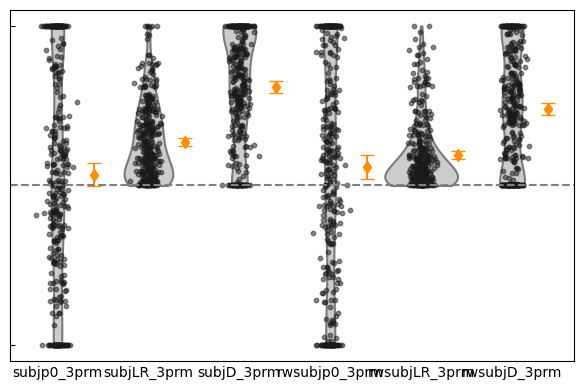

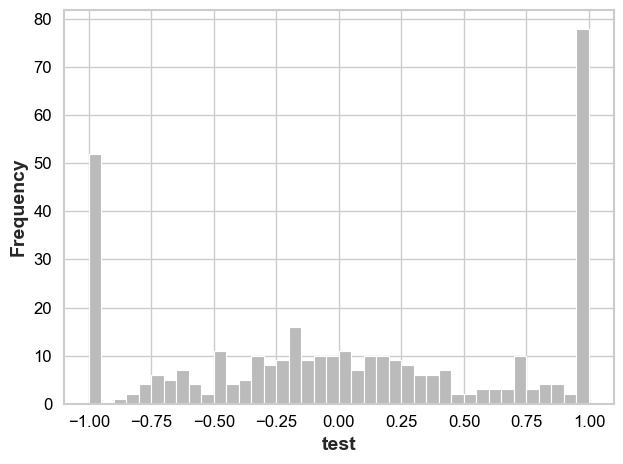

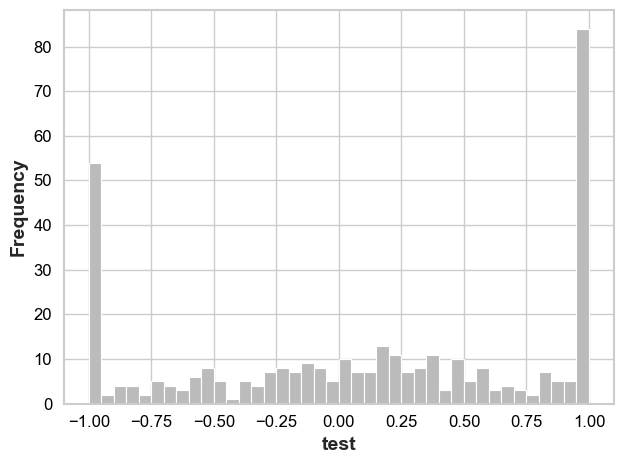

y = 3.54e-01x + 5.899e-02


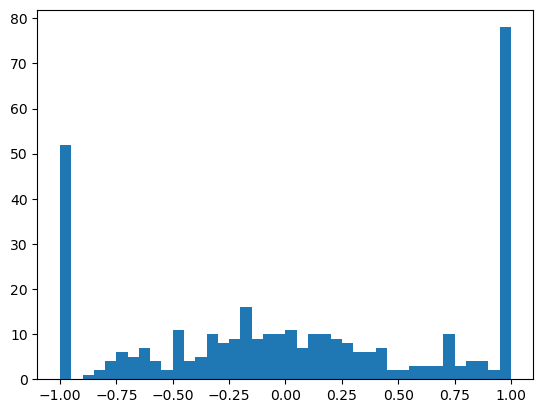

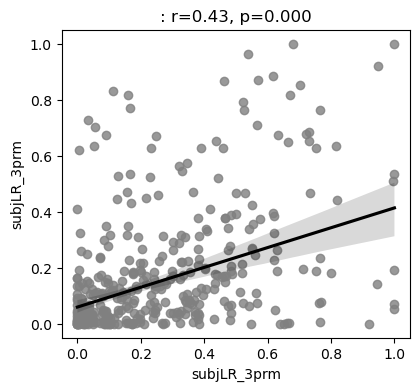

In [ ]:
# scatter_plot_with_correlation(lrnSumm.loc[,:].subjD_bOC, lrnSumm.loc[lrnSubjs2Use,:].subjD_3prm, title='') 
# lrnSubjs2Use
# plot_violin_with_jitter_and_ci(sldmModFits.loc[subjs2Use,['subjLR_bOC','rwsubjLR_bOC','subjLRDiff_bOC']].dropna(), ylim=[-1.1,1.1], yticks=[-1,0,1], figsize=(6,4))
plot_violin_with_jitter_and_ci(lrnSumm.loc[subjs2Use,['subjp0_3prm', 'subjLR_3prm','subjD_3prm']].join(rwlrnSumm.loc[subjs2Use,['subjp0_3prm', 'subjLR_3prm','subjD_3prm']].add_prefix('rw')).dropna(), ylim=[-1.1,1.1], yticks=[-1,0,1], figsize=(6,4))
plot_violin_with_jitter_and_ci((lrnSumm.loc[subjs2Use,['subjp0_3prm']]-rwlrnSumm.loc[subjs2Use,['subjp0_3prm']]).dropna(), ylim=[-1.1,1.1], yticks=[-1,0,1], figsize=(6,4))
# scatter_plot_with_correlation(lrnSumm.loc[subjs2Use,['subjp0_3prm']]-rwlrnSumm.loc[subjs2Use,['subjp0_3prm']], summScores.RSQ_total, '')
summScores.RSQ_total
plot_histogram(lrnSumm.loc[subjs2Use,'subjp0_3prm'].rename('test'), bin_start=-1, bin_end=1.04, bin_step=.05)
plot_histogram(rwlrnSumm.loc[subjs2Use,'subjp0_3prm'].rename('test'), bin_start=-1, bin_end=1.04, bin_step=.05)
np.sum([rwlrnSumm.loc[subjs2Use,'subjp0_3prm']==1])
plt.hist(lrnSumm.loc[subjs2Use,'subjp0_3prm'].rename('test'), bins=np.r_[-1:1.04:.05])
scatter_plot_with_correlation(lrnSumm.loc[subjs2Use,:].subjLR_3prm, rwlrnSumm.loc[subjs2Use,:].subjLR_3prm, title='') 
# scatter_plot_with_correlation(lrnSumm.loc[subjs2Use,:].subjp0_3prm, corrAnalysis.loc[subjs2Use,:].lrn_Est0, title='') 
# scatter_plot_with_correlation(rwlrnSumm.loc[subjs2Use,:].subjp0_3prm, corrAnalysis.loc[subjs2Use,:].rwlrn_Est0, title='') 

In [ ]:
# FIT THE LOTTERY DATA WITH A SINGLE LEARNING RATE MODEL
# smax=1
# lrRange=np.linspace(-10,10,5)
# # fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

# print('FITTING...')
# for PID in rwlrnEstArr.PID.unique():
#     # print('subj: {}'.format(PID))
#     rwestDat=rwlrnEstArr.loc[(rwlrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
#     rwestDat.columns=['ch_{:02d}'.format(i) for i in rwestDat.columns+1]
#     rwocDat=rwlrnOCArr.loc[(rwlrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
#     rwlrs_nll=np.inf
#     for lrs in lrRange:
#         result_optimizeLR_sft_fixedSM_posNegOCoptimizeLR_sft_fixedSM, (lrs,),(rwestDat, rwocDat),bounds=((-10,10),))
#         if result_s.fun < rwlrs_nll:
#             rwlrsp0Rangel = result_s.fun
#             rwlrs_val = result_s.x[0]
 
#     rwlrnSumm.loc[PID,'subjLR']=np.exp(rwlrs_val)/(np.exp(rwlrs_val)+1)
#     rwlrnSumm.loc[PID,'subjNLL']=rwlrs_nll
#     rwchncNLL=np.sum(chanceLikelihood(rwestDat))
#     rwlrnSumm.loc[PID, 'subjLRTp']=stats.chi2.sf(2*(rwchncNLL-rwlrnSumm.loc[PID,'subjNLL']),1)

# rwlrnSumm=rwlrnSumm.loc[:,rwlrnSumm.columns[~rwlrnSumm.columns.str.startswith('qa:')].append(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('qa:')])]
    
    
# print('DONE')

# # build the plot
# fig, ax = plt.subplots()
# ax.hist(rwlrnSumm['subjLR'], bins=np.arange(0,1.01,.02))
# ax.set(title='RWLRN Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(rwlrnSumm.subjLR.mean(), rwlrnSumm.subjLR.std()/np.sqrt(rwlrnSumm.subjLR.count())))
# plt.savefig('final/results/RWLRN_Learning_Rates_hist.png')
# plt.show()

# # for hierarchical fitting later must reshape array
# # PID=lrnEstArr['PID'].iloc[0]
# # tmp=lrnEstArr.loc[lrnEstArr['PID']==PID,:].dropna(axis=1).drop(columns=['PID']).transpose().reset_index(drop=True)
# # tmp['PID']=PID
# # tmp

In [ ]:
    
# # FIT THE LOTTERY DATA WITH A BIASED OUTCOME TWO LEARNING RATE MODEL
# smax=1
# lrRange=np.linspace(-10,10,5)
# # fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

# print('FITTING...')
# for PID in rwlrnEstArr.PID.unique():
#     # print('subj: {}'.format(PID))
#     rwestDat=rwlrnEstArr.loc[(rwlrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
#     rwestDat.columns=['ch_{:02d}'.format(i) for i in rwestDat.columns+1]
#     rwocDat=rwlrnOCArr.loc[(rwlrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
#     rwlrs_nll=np.inf
#     for lrs in lrRange:
#         result_s=sp.optimize.minimize(optimize2LR_sft_fixedSM, (lrs,lrs,),(rwestDat, rwocDat),bounds=((-10,10),(-10,10),))
#         if result_s.fun < rwlrs_nll:
#             rwlrs_nll = result_s.fun
#             rwlrs_pos_val = result_s.x[0]
#             rwlrs_neg_val = result_s.x[1]
 
#     rwlrnSumm.loc[PID,'subjLR_posOC']=np.exp(rwlrs_pos_val)/(np.exp(rwlrs_pos_val)+1)
#     rwlrnSumm.loc[PID,'subjLR_negOC']=np.exp(rwlrs_neg_val)/(np.exp(rwlrs_neg_val)+1)
#     rwlrnSumm.loc[PID,'subjLR_biasedOC']=rwlrnSumm.loc[PID,'subjLR_posOC']-rwlrnSumm.loc[PID,'subjLR_negOC']
#     rwlrnSumm.loc[PID,'subjNLL_biasedOC']=rwlrs_nll
#     rwchncNLL=np.sum(chanceLikelihood(rwestDat))
#     rwlrnSumm.loc[PID, 'subjLRTp_biasedOC']=stats.chi2.sf(2*(rwchncNLL-rwlrnSumm.loc[PID,'subjNLL_biasedOC']),1)

# rwlrnSumm=rwlrnSumm.loc[:,rwlrnSumm.columns[~rwlrnSumm.columns.str.startswith('qa:')].append(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('qa:')])]
    
    
# print('DONE')

In [ ]:
# # FIT THE Trust Learning DATA WITH A SINGLE LEARNING RATE MODEL
# smax=1
# lrRange=np.linspace(-10,10,5)
# # fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

# print('FITTING...')
# for PID in lrnEstArr.PID.unique():
#     # print('subj: {}'.format(PID))
#     estDat=lrnEstArr.loc[(lrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
#     estDat.columns=['ch_{:02d}'.format(i) for i in estDat.columns+1]
#     ocDat=lrnOCArr.loc[(lrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
#     lrs_nll=np.inf
#     for lrs in lrRange:
#         result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM, (lrs,),(estDat, ocDat),bounds=((-10,10),))
#         if result_s.fun < lrs_nll:
#             lrs_nll = result_s.fun
#             lrs_val = result_s.x[0]
 
#     lrnSumm.loc[PID,'subjLR']=np.exp(lrs_val)/(np.exp(lrs_val)+1)
#     lrnSumm.loc[PID,'subjNLL']=lrs_nll
#     chncNLL=np.sum(chanceLikelihood(estDat))
#     lrnSumm.loc[PID, 'subjLRTp']=stats.chi2.sf(2*(chncNLL-lrnSumm.loc[PID,'subjNLL']),1)

# lrnSumm=lrnSumm.loc[:,lrnSumm.columns[~lrnSumm.columns.str.startswith('qa:')].append(lrnSumm.columns[lrnSumm.columns.str.startswith('qa:')])]
    
    
# print('DONE')

# # build the plot
# fig, ax = plt.subplots()
# ax.hist(lrnSumm['subjLR'], bins=np.arange(0,1.01,.02))
# ax.set(title='TRLRN Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(lrnSumm.subjLR.mean(), lrnSumm.subjLR.std()/np.sqrt(lrnSumm.subjLR.count())))
# plt.savefig('final/results/TRLRN_Learning_Rates_hist.png')
# plt.show()

# # for hierarchical fitting later must reshape array
# # PID=lrnEstArr['PID'].iloc[0]
# # tmp=lrnEstArr.loc[lrnEstArr['PID']==PID,:].dropna(axis=1).drop(columns=['PID']).transpose().reset_index(drop=True)
# # tmp['PID']=PID
# # tmp

In [ ]:
# # FIT THE Trust Learning DATA WITH A Dual LEARNING RATE MODEL
# smax=1
# lrRange=np.linspace(-10,10,5)
# # fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

# print('FITTING...')
# for PID in lrnEstArr.PID.unique():
#     # print('subj: {}'.format(PID))
#     estDat=lrnEstArr.loc[(lrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
#     estDat.columns=['ch_{:02d}'.format(i) for i in estDat.columns+1]
#     ocDat=lrnOCArr.loc[(lrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
#     lrs_nll=np.inf
#     for lrs in lrRange:
#         result_s=sp.optimize.minimize(optimize2LR_sft_fixedSM, (lrs,lrs,),(estDat, ocDat),bounds=((-10,10),(-10,10),))
#         if result_s.fun < lrs_nll:
#             lrs_nll = result_s.fun
#             lrs_pos_val = result_s.x[0]
#             lrs_neg_val = result_s.x[1]
 
#     lrnSumm.loc[PID,'subjLR_posOC']=np.exp(lrs_pos_val)/(np.exp(lrs_pos_val)+1)
#     lrnSumm.loc[PID,'subjLR_negOC']=np.exp(lrs_neg_val)/(np.exp(lrs_neg_val)+1)
#     lrnSumm.loc[PID,'subjLR_biasedOC']=lrnSumm.loc[PID,'subjLR_posOC']-lrnSumm.loc[PID,'subjLR_negOC']
#     lrnSumm.loc[PID,'subjNLL_biasedOC']=lrs_nll
#     chncNLL=np.sum(chanceLikelihood(estDat))
#     lrnSumm.loc[PID, 'subjLRTp_biasedOC']=stats.chi2.sf(2*(chncNLL-lrnSumm.loc[PID,'subjNLL_biasedOC']),1)

# lrnSumm=lrnSumm.loc[:,lrnSumm.columns[~lrnSumm.columns.str.startswith('qa:')].append(lrnSumm.columns[lrnSumm.columns.str.startswith('qa:')])]
    
    
# print('DONE')

# # build the plot
# fig, ax = plt.subplots()
# ax.hist(lrnSumm['subjLR_biasedOC'], bins=np.arange(-1,1.01,.02))
# ax.set(title='TRLRN Bias in OC Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(lrnSumm.subjLR_biasedOC.mean(), lrnSumm.subjLR_biasedOC.std()/np.sqrt(lrnSumm.subjLR_biasedOC.count())))
# # plt.savefig('final/results/TRLRN_Learning_Rates_hist.png')
# plt.show()

# # for hierarchical fitting later must reshape array
# # PID=lrnEstArr['PID'].iloc[0]
# # tmp=lrnEstArr.loc[lrnEstArr['PID']==PID,:].dropna(axis=1).drop(columns=['PID']).transpose().reset_index(drop=True)
# # tmp['PID']=PID
# # tmp

In [ ]:
# lrnSumm=lrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub)
# rwlrnSumm=rwlrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub)

In [ ]:
# # FIT THE LOTTERY and TRUST DATA TOGETHER WITH A SINGLE LEARNING RATE MODEL
# smax=1
# lrRange=np.linspace(-10,10,5)
# # fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
# allLrnSumm=lrnSumm.add_prefix('tr_').join(rwlrnSumm.drop(columns=['distFromMedQA_lowMC_ltMADCutOff_goodSub']).add_prefix('rw_'))

# print('FITTING...')
# fitCount=0;
# for PID in lrnEstArr.PID.unique():
#     fitCount+=1
#     print(f'subj_{fitCount:03.0f}: {PID}')
#     tmpDat=lrnEstArr.query(f'PID==\"{PID}\"').join(rwlrnEstArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
#     allestDat=tmpDat.transpose().dropna().drop('PID').astype(int)
#     allestDat.columns=['ch_{:02d}'.format(i) for i in allestDat.columns+1]
#     tmpDat=lrnOCArr.query(f'PID==\"{PID}\"').join(rwlrnOCArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
#     allocDat=tmpDat.transpose().dropna().drop('PID').astype(int)
#     all_lrs_nll=np.inf
#     for lrs in lrRange:
#         result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM, (lrs,),(allestDat, allocDat),bounds=((-10,10),))
#         if result_s.fun < all_lrs_nll:
#             all_lrs_nll = result_s.fun
#             all_lrs_val = result_s.x[0]

#     allLrnSumm.loc[PID,'subjLR']=np.exp(all_lrs_val)/(np.exp(all_lrs_val)+1)
#     allLrnSumm.loc[PID,'subjNLL']=all_lrs_nll
#     allchncNLL=np.sum(chanceLikelihood(allestDat))
#     allLrnSumm.loc[PID, 'subjLRTp']=stats.chi2.sf(2*(allchncNLL-allLrnSumm.loc[PID,'subjNLL']),1)

# allLrnSumm=allLrnSumm.loc[:,allLrnSumm.columns[~allLrnSumm.columns.str.startswith('qa:')].append(allLrnSumm.columns[allLrnSumm.columns.str.startswith('qa:')])]


# print('DONE')

# # build the plot
# fig, ax = plt.subplots()
# ax.hist(allLrnSumm['subjLR'], bins=np.arange(0,1.01,.02))
# ax.set(title='ALL LRN Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(allLrnSumm.subjLR.mean(), allLrnSumm.subjLR.std()/np.sqrt(allLrnSumm.subjLR.count())))
# plt.savefig('final/results/ALLLRN_Learning_Rates_hist.png')
# plt.show()

# # for hierarchical fitting later must reshape array
# # PID=lrnEstArr['PID'].iloc[0]
# # tmp=lrnEstArr.loc[lrnEstArr['PID']==PID,:].dropna(axis=1).drop(columns=['PID']).transpose().reset_index(drop=True)
# # tmp['PID']=PID
# # tmp

FITTING...
subj_001: 5f2f86864fd821374b4367bc
subj_002: 61492ac26b91b5b11ba2c88b
subj_003: 60234c1d5a0cf81cba76ce5d
subj_004: 6362aca86b740b1ec4cb6efb
subj_005: 60fcd2b146529d02f1566012
subj_006: 63ed12d2c25b08ba24fe8a41
subj_007: 5d412a9013864b0015b14b31
subj_008: 62ec219e5f3634408fb35580
subj_009: 594936ad4152bf0001bfd5cd
subj_010: 63d842d3e9626bd5fe5c17b1
subj_011: 631bc422eec20143118ad66b
subj_012: 58016c9f551314000145af58
subj_013: 63d1c10210ce566ce71616e8
subj_014: 5e55e83cc65ccb5ed547cb04
subj_015: 63e5b3e89a3823139cb9d35e
subj_016: 6400ea4cec0b310140841b2d
subj_017: 6352b3c968388ef86f3556db
subj_018: 63dc7b5bf451a34177b66c66
subj_019: 63d881ab484805569b553bd8
subj_020: 63d43dc4b4b7a0e426a381cd
subj_021: 5e7abb2c6c89e4000a180b4a
subj_022: 63d42c21dc6f4d60e34cc337
subj_023: 62f6bc18e456bdf4bc90dd7b
subj_024: 63d6873b65a6170d64a652f6
subj_025: 633fa968afc8d3d2c0d8745c
subj_026: 5c3161130cfe9a00012f71ff
subj_027: 5f1f3581b5cf3e103cc545c9
subj_028: 63d42387aba51e699ab9ce5c
subj_029:

In [ ]:

# allLrnSumm.subjNLL_bOC
6*22

132

In [ ]:
# save_workspace('snslFitParams_bOC.pkl', variables_to_save=['lrnSumm', 'rwlrnSumm', 'allLrnSumm'], globals_dict=globals())
tmp=load_workspace('snslFitParams_bOC.pkl')
lrnSumm=tmp['lrnSumm']
rwlrnSumm=tmp['rwlrnSumm']
allLrnSumm=tmp['allLrnSumm']

Index(['tr_totalTime', 'tr_rat_mean', 'tr_rat_std', 'tr_rat_r1r2_corr_r',
       'tr_rat_r1r2_corr_p', 'tr_qa:rat_%rt<300', 'tr_qa:rat_%rt>10000',
       'tr_qa:rat_%Conseqs', 'tr_qa:rat_instruxDur', 'tr_qa:rat_blurEv',
       'tr_qa:dec_%rt<300', 'tr_qa:dec_%rt>10000', 'tr_qa:dec_%Conseqs',
       'tr_qa:dec_instruxDur', 'tr_qa:dec_blurEv', 'tr_frat_r1r2_corr_r',
       'tr_frat_r1r2_corr_p', 'tr_qa:frat_%rt<300', 'tr_qa:frat_%rt>10000',
       'tr_qa:frat_%Conseqs', 'tr_qa:frat_instruxDur', 'rw_totalTime',
       'rw_qa:dec_%rt<300', 'rw_qa:dec_%rt>10000', 'rw_qa:dec_%Conseqs',
       'rw_qa:dec_instruxDur', 'rw_qa:frat_%rt<300', 'rw_qa:frat_%rt>10000',
       'rw_qa:frat_%Conseqs', 'rw_qa:frat_instruxDur', 'rw_qa:blurEv',
       'subjLR_bOC', 'subjD_bOC', 'subjNLL_bOC', 'subjLRTp_bOC', 'subjLR_3prm',
       'subjD_3prm', 'subjp0_3prm', 'subjNLL_3prm', 'subjLRTp_3prm', 'BIC_bOC',
       'BIC_3prm', 'BIC_6prm'],
      dtype='object')

In [ ]:
goodLearners=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).query('subjLRTp_bOC<0.05').index
subjs2Use=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).query('distFromMedQA_lowMC_ltMADCutOff_goodSub==1').index
lrnSubjs2Use=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).query('subjLRTp_bOC<0.05 & distFromMedQA_lowMC_ltMADCutOff_goodSub==1').index

subjs2Use_M=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).join(demoG.BirthSex).query('distFromMedQA_lowMC_ltMADCutOff_goodSub==1 & BirthSex==1').index
lrnSubjs2Use_M=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).join(demoG.BirthSex).query('subjLRTp_bOC<0.05 & distFromMedQA_lowMC_ltMADCutOff_goodSub==1 & BirthSex==1').index

subjs2Use_F=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).join(demoG.BirthSex).query('distFromMedQA_lowMC_ltMADCutOff_goodSub==1 & BirthSex==2').index
lrnSubjs2Use_F=allLrnSumm.join(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub).join(demoG.BirthSex).query('subjLRTp_bOC<0.05 & distFromMedQA_lowMC_ltMADCutOff_goodSub==1 & BirthSex==2').index

In [ ]:
print(goodLearners.shape)
print(subjs2Use.shape)
print(lrnSubjs2Use.shape)

(389,)
(365,)
(340,)


In [ ]:
demoG.columns

Index(['BirthSex', 'Age', 'Hand', 'HLS_ethnicity', 'Race', 'Primary_Language',
       'Religion', 'Education', 'Marital_Status', 'Children',
       'How_Many_Children', 'Employment', 'Income', 'Own_Car', 'How_Many_Cars',
       'SleepHours', 'Awake', 'ASD'],
      dtype='object')

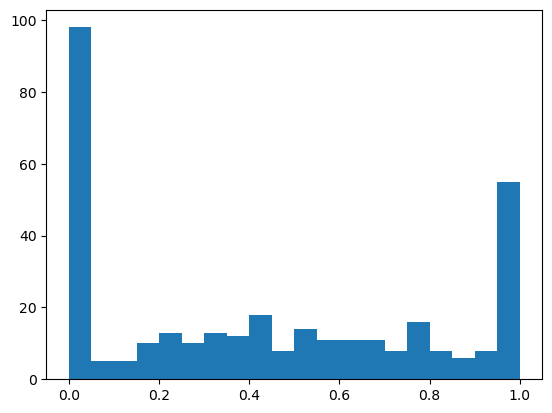

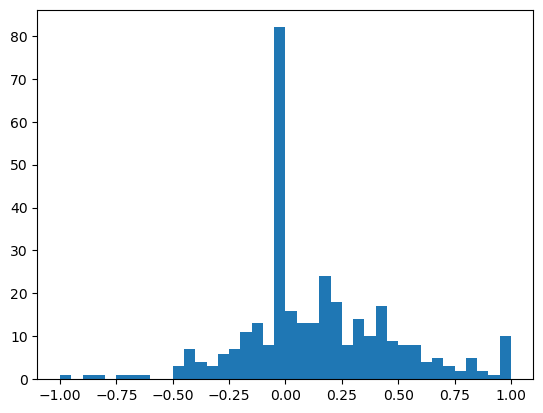

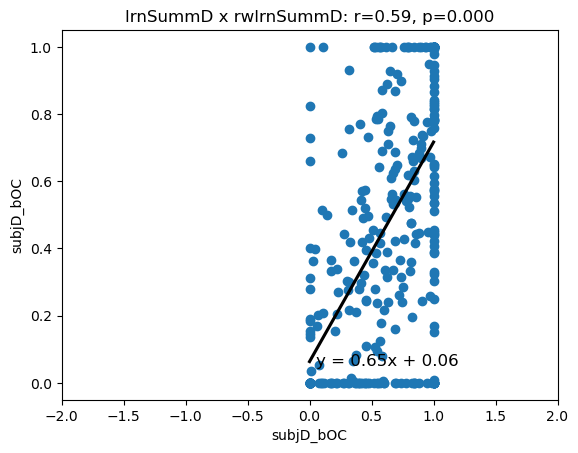

In [ ]:
plt.hist(rwlrnSumm.loc[lrnSubjs2Use,:].subjD_bOC, bins=np.r_[0:1.01:.05])
plt.show()
plt.hist(lrnSumm.loc[lrnSubjs2Use,:].subjD_bOC, bins=np.r_[0:1.01:.05])
plt.show()

plt.hist(lrnSumm.loc[lrnSubjs2Use,:].subjD_bOC-rwlrnSumm.loc[lrnSubjs2Use,:].subjD_bOC, bins=np.r_[-1:1.01:.05])
plt.show()

scatter_plot_with_correlation(lrnSumm.loc[lrnSubjs2Use,:].subjD_bOC,rwlrnSumm.loc[lrnSubjs2Use,:].subjD_bOC, 'lrnSummD x rwlrnSummD')

In [ ]:
# selector=lrnSubjs2Use
# selector=lrnSumm.index
selector=subjs2Use

print(f'Trust LR: {lrnSumm.loc[selector,:].subjLR_bOC.mean():0.2f} SE({lrnSumm.loc[selector,:].subjLR_bOC.std()/np.sqrt(lrnSumm.loc[selector,:].subjLR_bOC.count()):0.2f})')
print(f'Lottery LR: {rwlrnSumm.loc[selector,:].subjLR_bOC.mean():0.2f} SE({rwlrnSumm.loc[selector,:].subjLR_bOC.std()/np.sqrt(rwlrnSumm.loc[selector,:].subjLR_bOC.count()):0.2f})')
# print(f'Trust LR (noBOC): {lrnSumm.loc[selector,:].subjLR.mean():0.2f} SE({lrnSumm.loc[selector,:].subjLR.std()/np.sqrt(lrnSumm.loc[selector,:].subjLR.count()):0.2f})')
# print(f'Lottery LR (noBOC): {rwlrnSumm.loc[selector,:].subjLR.mean():0.2f} SE({rwlrnSumm.loc[selector,:].subjLR.std()/np.sqrt(rwlrnSumm.loc[selector,:].subjLR.count()):0.2f})')

subjLR_bOC_diff=lrnSumm.subjLR_bOC-rwlrnSumm.subjLR_bOC
print(f'Trust-Lottery LR: {subjLR_bOC_diff[selector].mean():0.2f} SE({subjLR_bOC_diff[selector].std()/np.sqrt(subjLR_bOC_diff[selector].count()):0.2f})')



Trust LR: 0.31 SE(0.01)
Lottery LR: 0.23 SE(0.01)
Trust-Lottery LR: 0.08 SE(0.01)


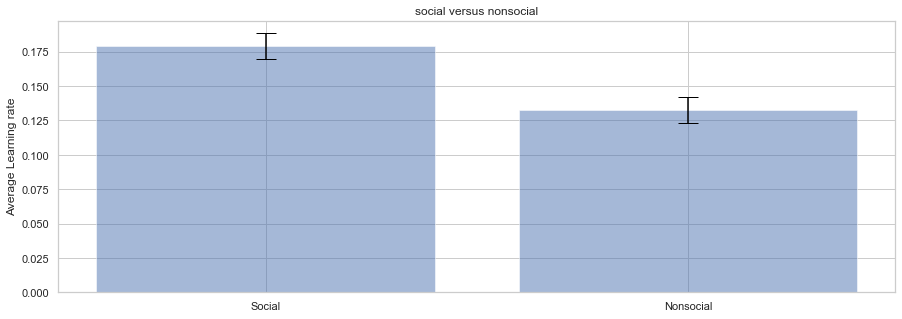

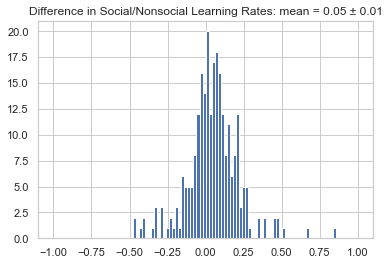

y = 2.56e-01x + 6.152e-02


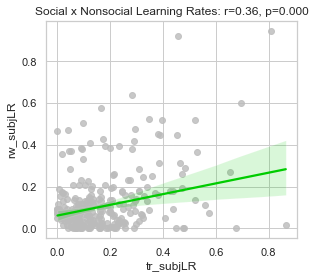

y = 2.56e-01x + 6.152e-02


In [ ]:
tmp=allLrnSumm.loc[lrnSubjs2Use,['tr_subjLR','rw_subjLR']]
# tmp=allLrnSumm.loc[:,['tr_subjLR','rw_subjLR']]
# stats.ttest_rel(tmp.tr_subjLR,tmp.rw_subjLR)
fig, ax = plt.subplots(1,1,figsize=(15,5))
labels=['Social','Nonsocial']
dat=tmp
ax.bar(np.arange(len(labels)),dat.mean(), yerr=dat.std()/np.sqrt(dat.count()), align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average Learning rate')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_title('social versus nonsocial')
# plt.savefig('results/wmem_Performance_XarrSz.png')
plt.show()

# build the plot
fig, ax = plt.subplots()
tmpDiff=tmp.tr_subjLR-tmp.rw_subjLR
ax.hist(tmpDiff, bins=np.arange(-1,1.01,.02))
ax.set(title='Difference in Social/Nonsocial Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(tmpDiff.mean(), tmpDiff.std()/np.sqrt(tmpDiff.count())))
# plt.savefig('final/results/RWLRN_Learning_Rates_hist.png')
plt.show()


# scatter_plot_with_correlation(tmp.tr_subjLR,tmp.rw_subjLR,'Social x Nonsocial')
scatter_plot_with_correlation(tmp.tr_subjLR,tmp.rw_subjLR, 'Social x Nonsocial Learning Rates', figsize=(5,5), linecolor='#00CC00', markercolor='#bbbbbb')
scatter_plot_with_correlation(tmp.tr_subjLR,tmp.rw_subjLR, 'Social x Nonsocial Learning Rates', figsize=(5,5), clean=True, linecolor='#00CC00', markercolor='#bbbbbb')

In [ ]:
# build the plot
fig, ax = plt.subplots()
tmp=allLrnSumm.loc[lrnSubjs2Use,'tr_subjLR_biasedOC']
ax.hist(tmp, bins=np.arange(-1,1.01,.02))
ax.set(title='TRLRN Bias in OC Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(tmp.mean(), tmp.std()/np.sqrt(tmp.count())))
# plt.savefig('final/results/RWLRN_Learning_Rates_hist.png')
plt.show()

# build the plot
fig, ax = plt.subplots()
tmp=allLrnSumm.loc[lrnSubjs2Use,'rw_subjLR_biasedOC']
ax.hist(tmp, bins=np.arange(-1,1.01,.02))
ax.set(title='RWLRN Bias in OC Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(tmp.mean(), tmp.std()/np.sqrt(tmp.count())))
# plt.savefig('final/results/RWLRN_Learning_Rates_hist.png')
plt.show()

# for hierarchical fitting later must reshape array
# PID=lrnEstArr['PID'].iloc[0]
# tmp=lrnEstArr.loc[lrnEstArr['PID']==PID,:].dropna(axis=1).drop(columns=['PID']).transpose().reset_index(drop=True)
# tmp['PID']=PID
# tmp

In [ ]:
sldmModFits=qaSummAll.loc[:,qaSummAll.columns.str.endswith('goodSub')].join(lrnSumm.loc[:,lrnSumm.columns[lrnSumm.columns.str.startswith('subj')]].join(rwlrnSumm.loc[:,rwlrnSumm.columns.str.startswith('subj')].add_prefix('rw')))
sldmModFits['subjLR_Diff_bOC']=sldmModFits['subjLR_bOC']-sldmModFits['rwsubjLR_bOC']
sldmModFits['subjD_Diff_bOC']=sldmModFits.subjD_bOC-sldmModFits.rwsubjD_bOC
sldmModFits['subjLR_Diff_3prm']=sldmModFits['subjLR_3prm']-sldmModFits['rwsubjLR_3prm']
sldmModFits['subjD_Diff_3prm']=sldmModFits.subjD_3prm-sldmModFits.rwsubjD_3prm
sldmModFits['subjp0_Diff_3prm']=sldmModFits.subjp0_3prm-sldmModFits.rwsubjp0_3prm


In [ ]:
sldmModFits.columns

Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAW2_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'subjLR_bOC', 'subjD_bOC',
       'subjNLL_bOC', 'subjLRTp_bOC', 'subjLR_3prm', 'subjD_3prm',
       'subjp0_3prm', 'subjNLL_3prm', 'subjLRTp_3prm', 'rwsubjLR_bOC',
       'rwsubjD_bOC', 'rwsubjNLL_bOC', 'rwsubjLRTp_bOC', 'rwsubjLR_3prm',
       'rwsubjD_3prm', 'rwsubjp0_3prm', 'rwsubjNLL_3prm', 'rwsubjLRTp_3prm',
       'subjLR_Diff_bOC', 'subjD_Diff_bOC', 'subjLR_Diff_3prm',
       'subjD_Diff_3prm', 'subjp0_Diff_3prm'],
      dtype='object')

In [ ]:
corrAnalysis=sldmModFits.join(summScores).loc[lrnSubjs2Use_F,:]
# corrAnalysis=sldmModFits.join(summScores).loc[subjs2Use,:]
# corrAnalysis=sldmModFits.join(summScores).loc[lrnSubjs2Use_M,:]
corrAnalysis=corrAnalysis.join(lrnEstArr.loc[0,:].set_index('PID', drop=True).mean(axis=1).rename('lrn_Est0'))
corrAnalysis=corrAnalysis.join(rwlrnEstArr.loc[0,:].set_index('PID', drop=True).mean(axis=1).rename('rwlrn_Est0'))
corrAnalysis['diff_Est0']=corrAnalysis.lrn_Est0-corrAnalysis.rwlrn_Est0

In [ ]:
# for param in tmp.loc[:,'subjLR':'subjLR_biasedOCDiff'].columns:
corrDF=pd.DataFrame(columns=['modelParam', 'summScore', 'N', 'r', 'p'])
# for param in corrAnalysis.loc[:,(corrAnalysis.columns.str.endswith('Diff') | corrAnalysis.columns.str.endswith('LR') | corrAnalysis.columns.str.endswith('R_bOC') | corrAnalysis.columns.str.endswith('D_bOC') | corrAnalysis.columns.str.endswith('f_bOC'))].columns:
# for param in corrAnalysis.loc[:,(corrAnalysis.columns.str.endswith('R_bOC') | corrAnalysis.columns.str.endswith('D_bOC') | corrAnalysis.columns.str.endswith('f_bOC') | corrAnalysis.columns.str.endswith('R_3prm') | corrAnalysis.columns.str.endswith('D_3prm') | corrAnalysis.columns.str.endswith('f_3prm') | corrAnalysis.columns.str.contains('Est0'))].columns:
# for param in corrAnalysis.loc[:,(corrAnalysis.columns.str.endswith('R_bOC') | corrAnalysis.columns.str.endswith('D_bOC') | corrAnalysis.columns.str.endswith('f_bOC') | corrAnalysis.columns.str.contains('Est0'))].columns:
for param in corrAnalysis.loc[:,(corrAnalysis.columns.str.endswith('p0_3prm') | corrAnalysis.columns.str.endswith('R_3prm') | corrAnalysis.columns.str.endswith('D_3prm') | corrAnalysis.columns.str.endswith('f_3prm'))].columns:
# for param in corrAnalysis.loc[:,(corrAnalysis.columns.str.endswith('f_3prm'))].columns:
# for param in corrAnalysis.loc[:,(corrAnalysis.columns.str.endswith('prm'))].columns:
    print(param)
    # for score in tmp.loc[:,'SCID_Score_Numeric':].columns:
    for score in corrAnalysis.loc[:,(corrAnalysis.columns.str.endswith('Numeric') | corrAnalysis.columns.str.endswith('tot') | corrAnalysis.columns.str.endswith('total') | corrAnalysis.columns.str.startswith('RFQ') | corrAnalysis.columns.str.startswith('CES') | corrAnalysis.columns.str.endswith('PID5_d') | corrAnalysis.columns.str.endswith('GSI') | corrAnalysis.columns.str.endswith('PDT') | corrAnalysis.columns.str.endswith('PSDI'))].columns:
        tmp=corrAnalysis.loc[:,[param,score]].dropna()
        r,p=stats.pearsonr(tmp[param],tmp[score])
        corrDF.loc[corrDF.shape[0],:]=[param, score, tmp.shape[0], r, p]
        
        if p < 0.05:
            print(f'{param} x {score}: r({tmp.shape[0]-2})={r:0.2f}, p={p:0.3f}')
            # sigCorr.append(p)

subjLR_3prm
subjD_3prm
subjD_3prm x CESDtot: r(132)=-0.17, p=0.043
subjp0_3prm
rwsubjLR_3prm
rwsubjLR_3prm x RFQ_U: r(132)=-0.21, p=0.016
rwsubjD_3prm
rwsubjp0_3prm
rwsubjp0_3prm x SCID_Score_Numeric: r(166)=-0.16, p=0.042
subjLR_Diff_3prm
subjD_Diff_3prm
subjp0_Diff_3prm


In [ ]:
if benjamini_hochberg(corrDF.p):
    corrDF[benjamini_hochberg(corrDF.p)]

# corrAnalysis.shape

No tests passed FDR correction


In [ ]:
corrDF.sort_values(['p'])[:15]

modelParam           summScore    N         r         p
43     rwsubjLR_3prm               RFQ_U  134 -0.208465  0.015642
60     rwsubjp0_3prm  SCID_Score_Numeric  168 -0.157202  0.041848
20        subjD_3prm             CESDtot  134 -0.174732  0.043458
79  subjLR_Diff_3prm               RFQ_U  134  0.168542  0.051572
16        subjD_3prm            BSI_PSDI  168 -0.135333  0.080278
35       subjp0_3prm      UCLA_LS3_total  134 -0.142077  0.101511
0        subjLR_3prm  SCID_Score_Numeric  168 -0.126053  0.103497
42     rwsubjLR_3prm               RFQ_C  134  0.132651  0.126533
87   subjD_Diff_3prm             BSI_PDT  168 -0.117457  0.129443
63     rwsubjp0_3prm             BSI_PDT  168 -0.116698  0.131954
45     rwsubjLR_3prm      LPFS_BF2_total  134 -0.130266  0.133561
99  subjp0_Diff_3prm             BSI_PDT  168  0.114237  0.140357
96  subjp0_Diff_3prm  SCID_Score_Numeric  168  0.111831  0.148963
31       subjp0_3prm               RFQ_U  134 -0.124315  0.152393
14        subjD_3prm             BSI_GSI  168 -0.110142  0.155239

In [ ]:
corrDF.modelParam

0     subjLR_Diff_3prm
1     subjLR_Diff_3prm
2     subjLR_Diff_3prm
3     subjLR_Diff_3prm
4     subjLR_Diff_3prm
5     subjLR_Diff_3prm
6     subjLR_Diff_3prm
7     subjLR_Diff_3prm
8     subjLR_Diff_3prm
9     subjLR_Diff_3prm
10    subjLR_Diff_3prm
11    subjLR_Diff_3prm
12     subjD_Diff_3prm
13     subjD_Diff_3prm
14     subjD_Diff_3prm
15     subjD_Diff_3prm
16     subjD_Diff_3prm
17     subjD_Diff_3prm
18     subjD_Diff_3prm
19     subjD_Diff_3prm
20     subjD_Diff_3prm
21     subjD_Diff_3prm
22     subjD_Diff_3prm
23     subjD_Diff_3prm
24    subjp0_Diff_3prm
25    subjp0_Diff_3prm
26    subjp0_Diff_3prm
27    subjp0_Diff_3prm
28    subjp0_Diff_3prm
29    subjp0_Diff_3prm
30    subjp0_Diff_3prm
31    subjp0_Diff_3prm
32    subjp0_Diff_3prm
33    subjp0_Diff_3prm
34    subjp0_Diff_3prm
35    subjp0_Diff_3prm
Name: modelParam, dtype: object

In [ ]:
.05/35

0.0014285714285714286

y = -4.23e-01x + 4.828e-01


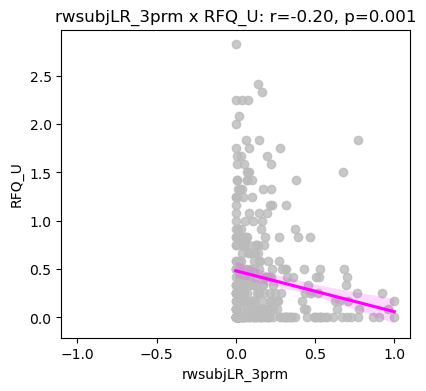

y = -4.23e-01x + 4.828e-01


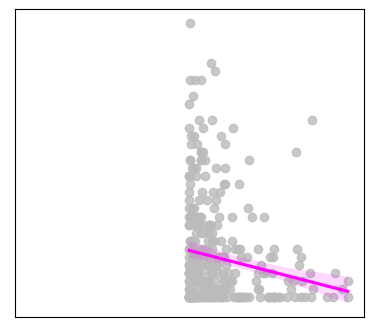

rwsubjLR_3prm RFQ_U


In [ ]:
for param,score in zip(corrDF[benjamini_hochberg(corrDF.p)].modelParam,corrDF[benjamini_hochberg(corrDF.p)].summScore):
    scatter_plot_with_correlation(corrAnalysis[param],corrAnalysis[score],f'{param} x {score}', figsize=(5,5), linecolor='magenta', markercolor='#bbbbbb', xlim=(-1.1,1.1))
    scatter_plot_with_correlation(corrAnalysis[param],corrAnalysis[score],f'{param} x {score}', figsize=(5,5), linecolor='magenta', markercolor='#bbbbbb', xlim=(-1.1,1.1), clean=True)
    print(param,score)
    

y = 1.55e+00x + 1.158e+01


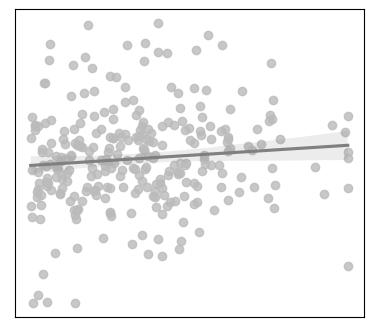

y = -2.17e+00x + 1.260e+01


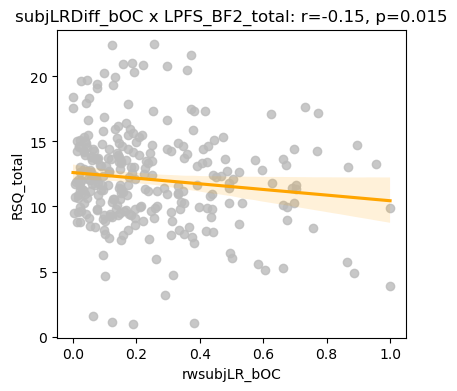

y = 2.31e-01x + 9.579e-01


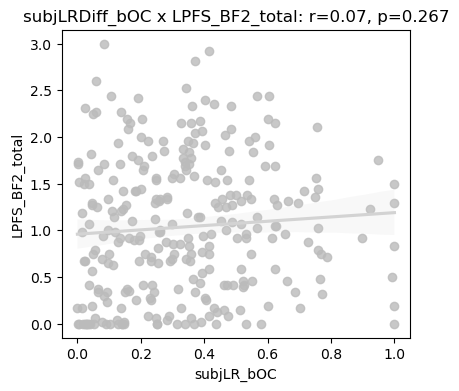

y = -5.42e-01x + 1.164e+00


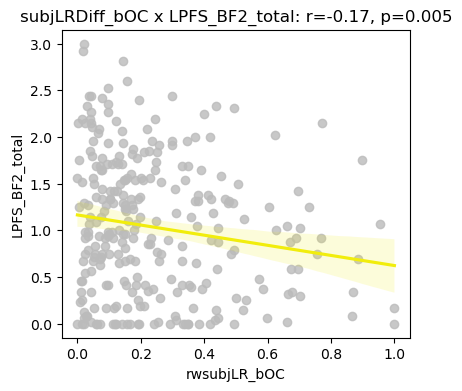

In [ ]:
scatter_plot_with_correlation(corrAnalysis['subjLR_bOC'],corrAnalysis['RSQ_total'],f'{param} x {score}', figsize=(5,5), linecolor='gray', markercolor='#bbbbbb', clean=True)
scatter_plot_with_correlation(corrAnalysis['rwsubjLR_bOC'],corrAnalysis['RSQ_total'],f'{param} x {score}', figsize=(5,5), linecolor='orange', markercolor='#bbbbbb')

scatter_plot_with_correlation(corrAnalysis['subjLR_bOC'],corrAnalysis['LPFS_BF2_total'],f'{param} x {score}', figsize=(5,5), linecolor='lightgray', markercolor='#bbbbbb')
scatter_plot_with_correlation(corrAnalysis['rwsubjLR_bOC'],corrAnalysis['LPFS_BF2_total'],f'{param} x {score}', figsize=(5,5), linecolor='#F1ED0D', markercolor='#bbbbbb')


y = 1.19e+00x + 1.173e+01
subjLR_3prm x RSQ_total: r(274)=0.09, p=0.142


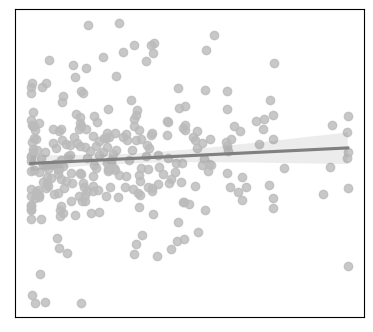

y = -1.59e+00x + 1.239e+01
rwsubjLR_3prm x RSQ_total: r(274)=-0.12, p=0.040


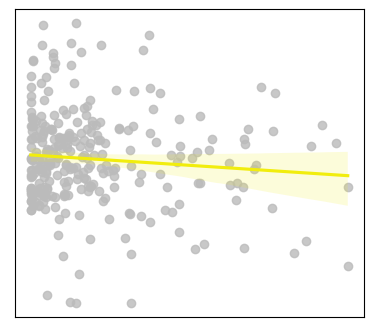

y = 1.60e-01x + 9.823e-01
subjLR_3prm x LPFS_BF2_total: r(274)=0.05, p=0.440


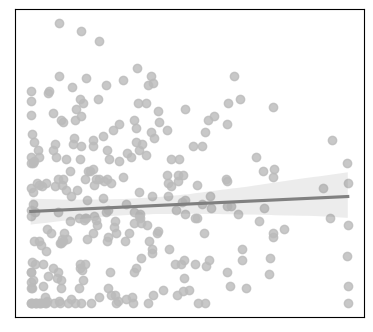

y = -4.87e-01x + 1.121e+00
rwsubjLR_3prm x LPFS_BF2_total: r(274)=-0.15, p=0.010


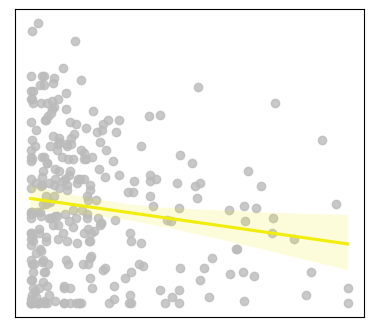

In [ ]:
scatter_plot_with_correlation(corrAnalysis['subjLR_3prm'],corrAnalysis['RSQ_total'],f'{"subjLR_3prm"} x {"RSQ_total"}', figsize=(5,5), linecolor='gray', markercolor='#bbbbbb', clean=True)
scatter_plot_with_correlation(corrAnalysis['rwsubjLR_3prm'],corrAnalysis['RSQ_total'],f'{"rwsubjLR_3prm"} x {"RSQ_total"}', figsize=(5,5), linecolor='#F1ED0D', markercolor='#bbbbbb', clean=True)
scatter_plot_with_correlation(corrAnalysis['subjLR_3prm'],corrAnalysis['LPFS_BF2_total'],f'{"subjLR_3prm"} x {"LPFS_BF2_total"}', figsize=(5,5), linecolor='gray', markercolor='#bbbbbb', clean=True)
scatter_plot_with_correlation(corrAnalysis['rwsubjLR_3prm'],corrAnalysis['LPFS_BF2_total'],f'{"rwsubjLR_3prm"} x {"LPFS_BF2_total"}', figsize=(5,5), linecolor='#F1ED0D', markercolor='#bbbbbb', clean=True)

# scatter_plot_with_correlation(corrAnalysis['subjLR_bOC'],corrAnalysis['LPFS_BF2_total'],f'{param} x {score}', figsize=(5,5), linecolor='lightgray', markercolor='#bbbbbb', clean=True)
# scatter_plot_with_correlation(corrAnalysis['rwsubjLR_bOC'],corrAnalysis['LPFS_BF2_total'],f'{param} x {score}', figsize=(5,5), linecolor='#F1ED0D', markercolor='#bbbbbb', clean=True)


y = 2.16e+00x + 1.185e+01
subjLR_Diff_3prm x RSQ_total: r(274)=0.19, p=0.002


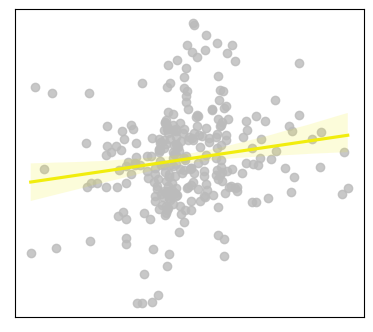

y = 4.95e-01x + 9.798e-01
subjLR_Diff_3prm x LPFS_BF2_total: r(274)=0.17, p=0.004


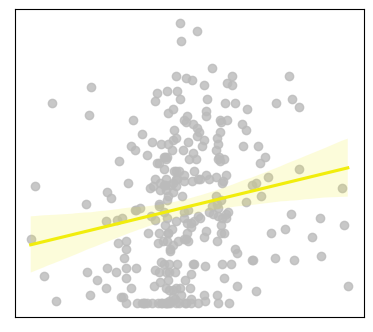

In [ ]:
scatter_plot_with_correlation(corrAnalysis['subjLR_Diff_3prm'],corrAnalysis['RSQ_total'],f'{"subjLR_Diff_3prm"} x {"RSQ_total"}', figsize=(5,5), linecolor='#F1ED0D', markercolor='#bbbbbb', clean=True)
scatter_plot_with_correlation(corrAnalysis['subjLR_Diff_3prm'],corrAnalysis['LPFS_BF2_total'],f'{"subjLR_Diff_3prm"} x {"LPFS_BF2_total"}', figsize=(5,5), linecolor='#F1ED0D', markercolor='#bbbbbb', clean=True)


In [ ]:
corrAnalysis.columns

Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAW2_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'subjLR_bOC', 'subjD_bOC',
       'subjNLL_bOC', 'subjLRTp_bOC', 'subjLR_3prm', 'subjD_3prm',
       'subjp0_3prm', 'subjNLL_3prm', 'subjLRTp_3prm', 'rwsubjLR_bOC',
       'rwsubjD_bOC', 'rwsubjNLL_bOC', 'rwsubjLRTp_bOC', 'rwsubjLR_3prm',
       'rwsubjD_3prm', 'rwsubjp0_3prm', 'rwsubjNLL_3prm', 'rwsubjLRTp_3prm',
       'subjLR_Diff_bOC', 'subjD_Diff_bOC', 'subjLR_Diff_3prm',
       'subjD_Diff_3prm', 'subjp0_Diff_3prm', 'SCID_Score_Numeric',
       'PCL_Score_Numeric', 'SCID_New_Score', 'PCL_New_Score',
       'BSI_Somatization', 'BSI_Obsession-Compulsion',
       'BSI_Interpersonal Sensitivity', 'BSI_Depression', 'BSI_Anxiety',
       'BSI_Hostility', 'BSI_Phobic', 'BSI_Paranoid Ideation',
       'BSI_Psychoticism', 'BSI_GSI', 'BSI_PDT', 'BSI_PSDI', 'RSQ_total',
       'RSQ_Rejection', 'RSQ_Expectance', 'RSQ_Upset', 'PID5_fAnhedon

In [ ]:
corrDF.sort_values('p').loc[corrDF.summScore=='RFQ_U'].head(30)

modelParam summScore    N         r         p
31     rwsubjLR_bOC     RFQ_U  280 -0.181942   0.00224
55   subjLRDiff_bOC     RFQ_U  280  0.134992  0.023878
79         lrn_Est0     RFQ_U  280 -0.112425  0.060274
91       rwlrn_Est0     RFQ_U  280 -0.099066  0.098056
43      rwsubjD_bOC     RFQ_U  280  0.088322  0.140433
67   subjD_Diff_bOC     RFQ_U  280 -0.058661   0.32806
19        subjD_bOC     RFQ_U  280  0.035218  0.557304
7        subjLR_bOC     RFQ_U  280  -0.02057  0.731829
103       diff_Est0     RFQ_U  280 -0.008265  0.890488

In [ ]:
qDatW2.shape

(342, 263)

In [ ]:
# r,p=stats.pearsonr(qaSumm['distFromMedQA'], qaSumm['distFromMedQA_lowmc'])
# print('r({:d})={:0.2f}, p={:0.4E}'.format(qaSumm.shape[0]-2,r,p))
# p

# plt.scatter(qaSumm['distFromMedQA'], qaSumm['distFromMedQA_lowmc'])
# plt.ylim(0, 2.5)
# plt.xlim(0, 2.5)
# plt.xticks([])
# plt.yticks([])
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import pandas as pd

def plot_violin_with_jitter_and_ci(df, n_bootstraps=10000, ci=95, title=None, ylim=None, yticks=None, figsize=(6,6)):
    """
    Plots a violin plot with jittered data, mean, and bootstrapped confidence intervals.
    
    Parameters:
    - df: DataFrame, data to plot with each column being a separate dataset.
    - bootstrap_mean_ci: function, used to calculate mean and CI.
    - n_bootstrap: int, number of bootstrap iterations for CI calculation.
    - ci: float, the confidence interval percentage.
    """
    # Set the figure size and create a violin plot
    plt.figure(figsize=figsize)
    
    # Create violin plots for each column
    sns.violinplot(data=df, inner=None, color="0.8", cut=0)
    
    # Add jittered points
    for i, col in enumerate(df.columns):
        # Jittered x positions
        jittered_x = np.random.normal(i, 0.06, size=len(df))
        plt.scatter(jittered_x, df[col], alpha=0.5, color='k', s=10)
        
        # Calculate mean and CI using the provided function
        lower_ci, upper_ci = bootstrap_mean_ci(df[col], n_bootstraps, ci)
        mean=df[col].mean()
        
        # Plot mean and CI
        plt.errorbar(i+.4, mean, yerr=[[mean - lower_ci], [upper_ci - mean]], fmt='d', color='#FF8F00', capsize=5)
    

    # Set the x-axis labels to the column names
    plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns)
    # Adjust tick parameters to hide tick marks but keep labels
    plt.tick_params(axis='x', length=0)  # Set tick length to 0 for x-axis

    if ylim is not None:
        plt.ylim(ylim)

    # Optionally set custom yticks if provided
    if yticks is not None:
        plt.yticks(yticks)
    
    # Add a horizontal line at zero
    plt.axhline(y=0, color='Gray', linestyle='--')

    # Adjust y-axis ticks to be inside and remove tick labels
    plt.tick_params(axis='y', direction='in', labelleft=False)  # 'labelleft=False' removes the y-axis tick labels
    
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage
# Assume df is your DataFrame and bootstrap_mean_ci is implemented
# plot_violin_with_jitter_and_ci(df, bootstrap_mean_ci, n_bootstrap=1000, ci=95)


In [ ]:
sldmModFits.columns

Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAW2_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'subjLR_bOC', 'subjD_bOC',
       'subjNLL_bOC', 'subjLRTp_bOC', 'subjLR_3prm', 'subjD_3prm',
       'subjp0_3prm', 'subjNLL_3prm', 'subjLRTp_3prm', 'rwsubjLR_bOC',
       'rwsubjD_bOC', 'rwsubjNLL_bOC', 'rwsubjLRTp_bOC', 'rwsubjLR_3prm',
       'rwsubjD_3prm', 'rwsubjp0_3prm', 'rwsubjNLL_3prm', 'rwsubjLRTp_3prm',
       'subjLR_Diff_bOC', 'subjD_Diff_bOC', 'subjLR_Diff_3prm',
       'subjD_Diff_3prm', 'subjp0_Diff_3prm'],
      dtype='object')

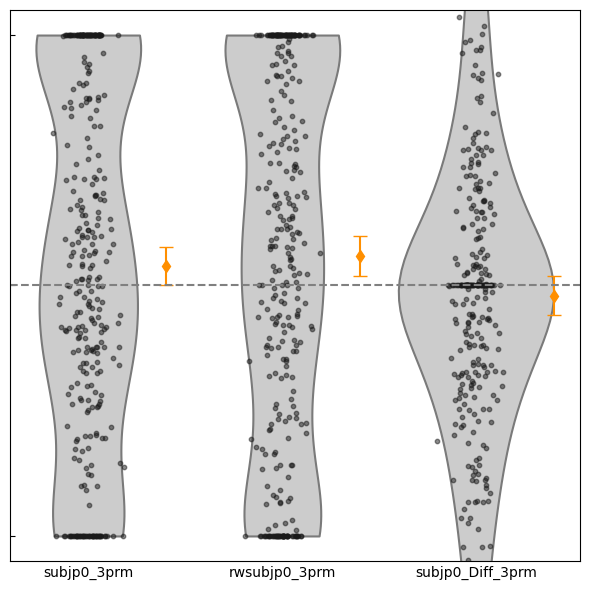

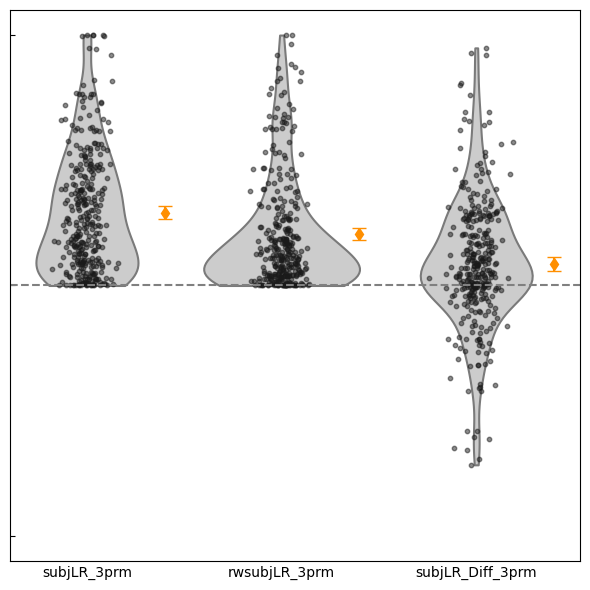

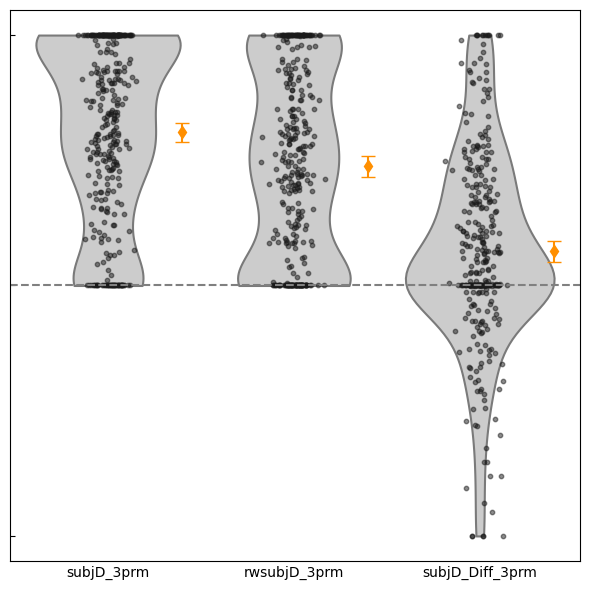

Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAW2_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'subjLR_bOC', 'subjD_bOC',
       'subjNLL_bOC', 'subjLRTp_bOC', 'subjLR_3prm', 'subjD_3prm',
       'subjp0_3prm', 'subjNLL_3prm', 'subjLRTp_3prm', 'rwsubjLR_bOC',
       'rwsubjD_bOC', 'rwsubjNLL_bOC', 'rwsubjLRTp_bOC', 'rwsubjLR_3prm',
       'rwsubjD_3prm', 'rwsubjp0_3prm', 'rwsubjNLL_3prm', 'rwsubjLRTp_3prm',
       'subjLR_Diff_bOC', 'subjD_Diff_bOC', 'subjLR_Diff_3prm',
       'subjD_Diff_3prm', 'subjp0_Diff_3prm'],
      dtype='object')

In [ ]:
# plot_violin_with_jitter_and_ci(sldmModFits.loc[sldmModFits.distFromMedQA_lowMC_ltMADCutOff_goodSub==1,['subjLR_bOC','rwsubjLR_bOC','subjLRDiff_bOC']], ylim=[-1.1,1.1], yticks=[-1,0,1], figsize=(6,4))
# plot_violin_with_jitter_and_ci(sldmModFits.loc[sldmModFits.distFromMedQA_lowMC_ltMADCutOff_goodSub==1,['subjD_bOC','rwsubjD_bOC','subjD_Diff_bOC']], ylim=[-1.1,1.1], yticks=[-1,0,1], figsize=(6,4))
plot_violin_with_jitter_and_ci(sldmModFits.loc[lrnSubjs2Use,['subjp0_3prm','rwsubjp0_3prm','subjp0_Diff_3prm']], ylim=[-1.1,1.1], yticks=[-1,0,1])
plot_violin_with_jitter_and_ci(sldmModFits.loc[lrnSubjs2Use,['subjLR_3prm','rwsubjLR_3prm','subjLR_Diff_3prm']], ylim=[-1.1,1.1], yticks=[-1,0,1])
plot_violin_with_jitter_and_ci(sldmModFits.loc[lrnSubjs2Use,['subjD_3prm','rwsubjD_3prm','subjD_Diff_3prm']], ylim=[-1.1,1.1], yticks=[-1,0,1])
sldmModFits.columns

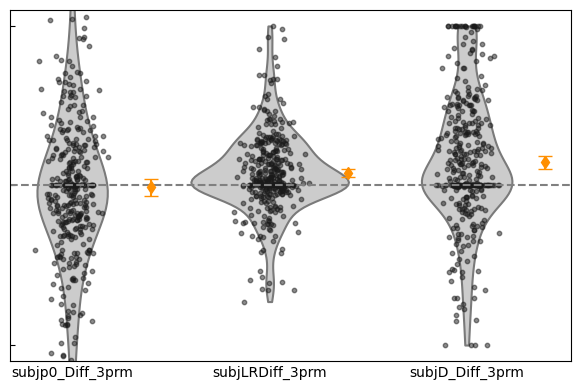

Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAW2_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'subjLR_bOC', 'subjD_bOC',
       'subjNLL_bOC', 'subjLRTp_bOC', 'subjLR_3prm', 'subjD_3prm',
       'subjp0_3prm', 'rwsubjLR_bOC', 'rwsubjD_bOC', 'rwsubjNLL_bOC',
       'rwsubjLRTp_bOC', 'rwsubjLR_3prm', 'rwsubjD_3prm', 'rwsubjp0_3prm',
       'subjLRDiff_3prm', 'subjD_Diff_3prm', 'subjp0_Diff_3prm'],
      dtype='object')

In [ ]:
plot_violin_with_jitter_and_ci(sldmModFits.loc[sldmModFits.distFromMedQA_lowMC_ltMADCutOff_goodSub==1,['subjp0_Diff_3prm','subjLRDiff_3prm','subjD_Diff_3prm']], ylim=[-1.1,1.1], yticks=[-1,0,1], figsize=(6,4))
# plot_violin_with_jitter_and_ci(sldmModFits.loc[sldmModFits.distFromMedQA_lowMC_ltMADCutOff_goodSub==1,['subjD_bOC','rwsubjD_bOC','subjD_Diff_bOC']], ylim=[-1.1,1.1], yticks=[-1,0,1], figsize=(6,4))
# plot_violin_with_jitter_and_ci(sldmModFits.loc[lrnSubjs2Use,['subjLR_bOC','rwsubjLR_bOC','subjLRDiff_bOC']], ylim=[-1.1,1.1], yticks=[-1,0,1])
# plot_violin_with_jitter_and_ci(sldmModFits.loc[lrnSubjs2Use,['subjD_bOC','rwsubjD_bOC','subjD_Diff_bOC']], ylim=[-1.1,1.1], yticks=[-1,0,1])
sldmModFits.columns

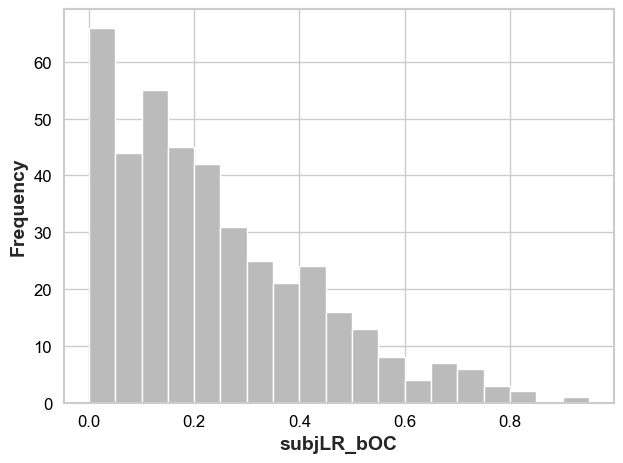

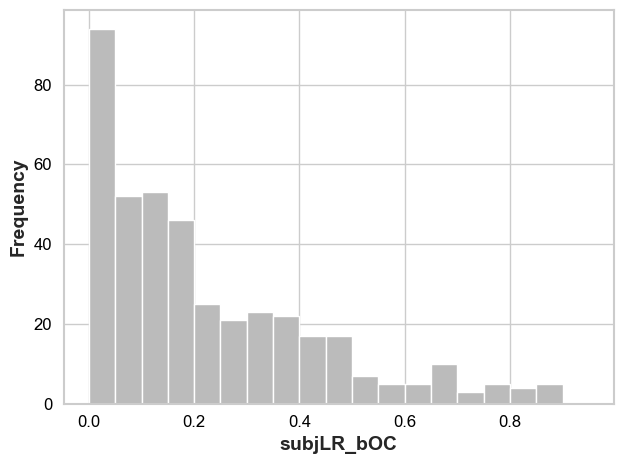

In [ ]:
plot_histogram(allLrnSumm.subjLR_bOC, bin_start=0, bin_end=1, bin_step=.05)
plot_histogram(lrnSumm.subjLR_bOC, bin_start=0, bin_end=1, bin_step=.05)
plot_histogram(rwlrnSumm.subjLR_bOC, bin_start=0, bin_end=1, bin_step=.05)

In [ ]:
from matplotlib.patches import Rectangle
def plot_correlation_heatmap(df,x1, x2, r, title=None, x1_order=None, x2_order=None, figsize=(12, 8), clean=False):
    """
    Plots a heatmap to visualize the Pearson correlation results between learning parameters
    and summary scores.

    Parameters:
    - df: DataFrame containing the Pearson correlation results with columns 'modelParam', 'summScore', 'N', 'r', 'p'.
    - figsize: Tuple, the figure size for the plot. Default is (12, 8).
    """
    df[r]=pd.to_numeric(df[r], errors='coerce')
    df_cleaned=df.dropna(subset=[r])

    # Optional reordering
    if x1_order is not None:
        df_cleaned = df_cleaned[df_cleaned[x1].isin(x1_order)]
        df_cleaned[x1] = pd.Categorical(df_cleaned[x1], categories=x1_order, ordered=True)
    if x2_order is not None:
        df_cleaned = df_cleaned[df_cleaned[x2].isin(x2_order)]
        df_cleaned[x2] = pd.Categorical(df_cleaned[x2], categories=x2_order, ordered=True)
    
    # Pivot the DataFrame
    # pivot_df = df_cleaned.pivot(x1, x2, r)
    pivot_df = df_cleaned.pivot(index=x1, columns=x2, values=r).round(2)
    pivot_p = df_cleaned.pivot(index=x1, columns=x2, values='p')  # Pivot p-values

    # Determine the colormap range
    vmax = np.ceil(np.max(np.abs(pivot_df.values)) / 0.05) * 0.05
    vmin = -vmax

    # Create the heatmap
    plt.figure(figsize=figsize)
    ax=sns.heatmap(pivot_df, cmap="vlag", annot=True, center=0, vmin=vmin, vmax=vmax,
                linewidths=.5, cbar=not(clean), cbar_kws={"shrink": .5}, annot_kws={'size': 12, 'weight': 'bold'})
    if title is not None:
        plt.title(title)
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.yticks(rotation=0)   # Keep y-axis labels horizontal
    plt.tight_layout()       # Adjust layout
    if clean:
        plt.axis('off')
    
    # Adjustments for box line inside cell and thicker line
    line_width = 4  # Making lines thicker
    inset = 0.05  # Small inset to prevent overlap, adjust as needed

    # Iterate through the p-values DataFrame to add boxes
    for i, (x2_val, row) in enumerate(pivot_p.iterrows()):
        for j, p_val in enumerate(row):
            if p_val < 0.001:
                color = 'Magenta'
            elif p_val < 0.01:
                color = '#F1ED0D'
            elif p_val < 0.05:
                color = 'orange'
            else:
                color = None
            
            if color:
                # Adjust rectangle size and position
                ax.add_patch(Rectangle((j + inset, i + inset), 1 - 2 * inset, 1 - 2 * inset, 
                                       fill=False, edgecolor=color, lw=line_width))

    
    plt.show()


def benjamini_hochberg(p_values, alpha=0.05):
    """
    Applies the Benjamini-Hochberg procedure to control the FDR at level alpha.
    
    Parameters:
    - p_values: A list or array of p-values.
    - alpha: The desired FDR control level.
    
    Returns:
    - A boolean array where True indicates that the hypothesis corresponding to that p-value is rejected.
    """
    # Convert the input to a NumPy array, if it isn't already
    p_values = np.array(p_values)
    
    # Number of tests
    m = len(p_values)
    
    # Rank the p-values while preserving their order
    sorted_indices = np.argsort(p_values)
    sorted_p_values = p_values[sorted_indices]
    
    # Calculate the critical value series
    threshold = alpha * np.arange(1, m + 1) / m
    
    # Find where the p-values first exceed the threshold
    rejected = sorted_p_values <= threshold
    max_index = np.where(rejected)[0].max() if rejected.any() else False
    
    if type(max_index) is bool:
        print('No tests passed FDR correction')
        return False
    else:
        # Reject hypotheses up to the last one below the threshold
        reject_mask = np.zeros(m, dtype=bool)
        reject_mask[:max_index + 1] = True
        return reject_mask[np.argsort(sorted_indices)]

In [ ]:
alpha=0.05
p_values=corrDF.p
# Number of tests
m = len(p_values)

# Rank the p-values while preserving their order
sorted_indices = np.argsort(p_values)
sorted_p_values = p_values[sorted_indices]

# Calculate the critical value series
threshold = alpha * np.arange(1, m + 1) / m

# Find where the p-values first exceed the threshold
rejected = sorted_p_values <= threshold
max_index = np.where(rejected)[0].max() if rejected.any() else False

# Reject hypotheses up to the last one below the threshold
if type(max_index) is bool:
    print('No tests passed FDR correction')
else:
    reject_mask = np.zeros(m, dtype=bool)
    reject_mask[:max_index + 1] = True


In [ ]:
print(threshold)
print(sorted_p_values)
print(rejected.any())

[0.00138889 0.00277778 0.00416667 0.00555556 0.00694444 0.00833333
 0.00972222 0.01111111 0.0125     0.01388889 0.01527778 0.01666667
 0.01805556 0.01944444 0.02083333 0.02222222 0.02361111 0.025
 0.02638889 0.02777778 0.02916667 0.03055556 0.03194444 0.03333333
 0.03472222 0.03611111 0.0375     0.03888889 0.04027778 0.04166667
 0.04305556 0.04444444 0.04583333 0.04722222 0.04861111 0.05      ]
5     0.005173
9     0.007393
11    0.037807
10    0.055123
27    0.060115
6     0.071893
7     0.090144
29    0.092003
17    0.121193
18    0.134635
4     0.140631
20    0.148591
23    0.163981
3     0.183532
15    0.212198
21    0.219324
2     0.226906
30    0.230466
28    0.252012
8     0.257341
26    0.265098
14    0.273895
33    0.281793
24     0.28382
34    0.303574
25    0.312807
32    0.334732
16    0.355814
19    0.410197
0     0.534081
1     0.695697
22    0.729802
13    0.827891
35     0.85592
31    0.900012
12    0.961855
Name: p, dtype: object
False


In [ ]:

    print(1)

In [ ]:
corrDF.modelParam.unique()

array(['subjLR_bOC', 'subjD_bOC', 'rwsubjLR_bOC', 'rwsubjD_bOC',
       'lrn_Est0', 'rwlrn_Est0', 'diff_Est0'], dtype=object)

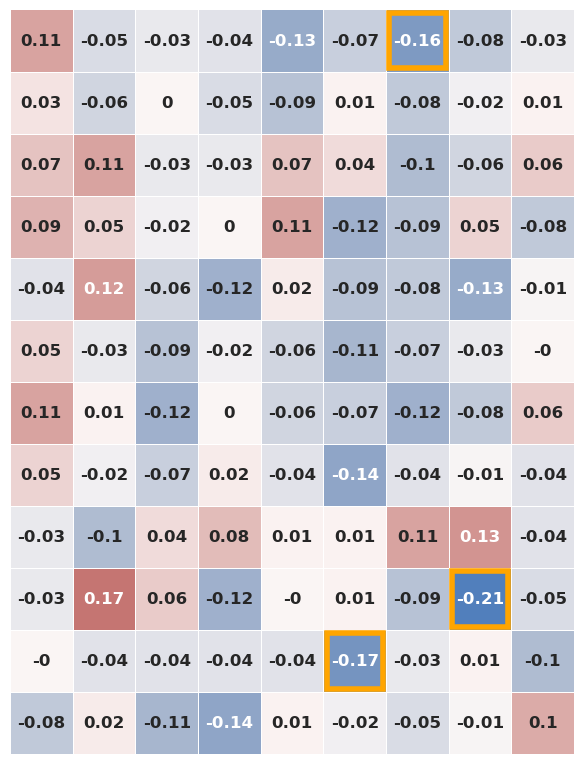

In [ ]:
# x1ord=corrDF.modelParam.unique()[[7,6,8,2,0,4,3,1,5]]
# x2ord=corrDF.summScore.unique()[[0,1,5,10,9,2,3,4,6,7,8,11]]
# x1ord=corrDF.modelParam.unique()[[7,6,8]]
# x2ord=corrDF.summScore.unique()[[0,1,5,10,9,2,3,4,6,7,8,11]]

x1ord=corrDF.modelParam.unique()[[8,6,7,2,0,1,5,3,4]]
x2ord=corrDF.summScore.unique()[[0,1,5,10,9,2,3,4,6,7,8,11]]

# plot_correlation_heatmap(corrDF, 'modelParam', 'summScore', 'r', x1_order=x1ord, x2_order=x2ord, figsize=(9,7.75), clean=False)
plot_correlation_heatmap(corrDF, 'summScore','modelParam', 'r', x1_order=x2ord, x2_order=x1ord, figsize=(9,9), clean=False)
plot_correlation_heatmap(corrDF, 'summScore','modelParam', 'r', x1_order=x2ord, x2_order=x1ord, figsize=(7.75,9), clean=True)
# plot_correlation_heatmap(corrDF, 'modelParam', 'summScore', 'r', figsize=(9,7.75), clean=False)
# plot_correlation_heatmap(corrDF, 'summScore','modelParam', 'r', figsize=(9,9), clean=False)

In [ ]:
print(subjs2Use_F.shape)
print(subjs2Use_M.shape)
print(lrnSubjs2Use_F.shape)
print(lrnSubjs2Use_M.shape)

(193,)
(169,)
(170,)
(163,)


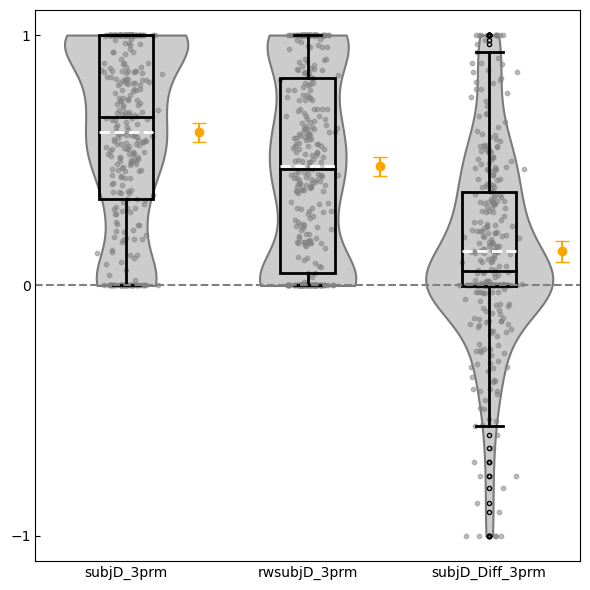

In [ ]:
def plot_violin_with_jitter_and_ci(df, n_bootstraps=10000, ci=95, title=None, ylim=None, yticks=None, figsize=(6,6)):
    plt.figure(figsize=figsize)
    sns.violinplot(data=df, inner=None, color="0.8", cut=0, width=0.7)

    for i, col in enumerate(df.columns):
        jittered_x = np.random.normal(i, 0.06, size=len(df))
        plt.scatter(jittered_x, df[col], alpha=0.5, color='gray', s=10)
        
        lower_ci, upper_ci = bootstrap_mean_ci(df[col], n_bootstraps, ci)
        mean = df[col].mean()

        boxcolor='black'
        boxwidth=2
        # Boxplot overlay
        plt.boxplot(df[col], positions=[i], widths=0.3, patch_artist=True,
                    boxprops=dict(facecolor='none', color=boxcolor, linewidth=boxwidth),
                    whiskerprops=dict(color=boxcolor, linewidth=boxwidth),
                    capprops=dict(color=boxcolor, linewidth=boxwidth),
                    medianprops=dict(color=boxcolor, linewidth=boxwidth),
                    flierprops=dict(marker='.', color=boxcolor, markeredgecolor=boxcolor))

        # Manually add a line for the mean
        plt.plot([i-0.15, i+0.15], [mean, mean], color='white', linestyle='--', linewidth=boxwidth)


        # Mean and CI Error Bar
        plt.errorbar(i+.4, mean, yerr=[[mean - lower_ci], [upper_ci - mean]], fmt='o', color='orange', capsize=5)

    plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns)
    plt.tick_params(axis='x', length=0)  # Hide x-axis tick marks

    if ylim is not None:
        plt.ylim(ylim)
    if yticks is not None:
        plt.yticks(yticks)
    
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.tick_params(axis='y', direction='in', labelleft=True)  # Make sure y-axis labels are visible

    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    
    
# plot_violin_with_jitter_and_ci(sldmModFits.loc[sldmModFits.distFromMedQA_lowMC_ltMADCutOff_goodSub==1,['subjLR_bOC','rwsubjLR_bOC','subjLRDiff_bOC']].dropna(), ylim=[-1.1,1.1], yticks=[-1,0,1])
# plot_violin_with_jitter_and_ci(sldmModFits.loc[sldmModFits.distFromMedQA_lowMC_ltMADCutOff_goodSub==1,['subjD_bOC','rwsubjD_bOC','subjD_Diff_bOC']].dropna(), ylim=[-1.1,1.1], yticks=[-1,0,1])
plot_violin_with_jitter_and_ci(sldmModFits.loc[lrnSubjs2Use,['subjp0_3prm','rwsubjp0_3prm','subjp0_Diff_3prm']], ylim=[-1.1,1.1], yticks=[-1,0,1])
plot_violin_with_jitter_and_ci(sldmModFits.loc[lrnSubjs2Use,['subjLR_3prm','rwsubjLR_3prm','subjLR_Diff_3prm']], ylim=[-1.1,1.1], yticks=[-1,0,1])
plot_violin_with_jitter_and_ci(sldmModFits.loc[lrnSubjs2Use,['subjD_3prm','rwsubjD_3prm','subjD_Diff_3prm']], ylim=[-1.1,1.1], yticks=[-1,0,1])

In [ ]:
corrDF.r.round(2)

0     -0.05
1     -0.02
2      0.01
3     -0.03
4      0.08
       ... 
103   -0.01
104   -0.03
105    0.01
106    0.07
107    0.00
Name: r, Length: 108, dtype: float64

In [ ]:
stats.bootstrap((tmp.subjLRDiff, tmp.UCLA_LS3_total,), my_pearsonr, vectorized=False, paired=True, n_resamples=10000)#.confidence_interval

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.055226138676617444, high=0.3733997022406277), standard_error=0.0818925272236799)

In [ ]:
lrnSumm.columns

Index(['totalTime', 'rat_mean', 'rat_std', 'rat_r1r2_corr_r',
       'rat_r1r2_corr_p', 'frat_r1r2_corr_r', 'frat_r1r2_corr_p', 'subjLR_bOC',
       'subjD_bOC', 'subjNLL_bOC', 'subjLRTp_bOC', 'subjLR_3prm', 'subjD_3prm',
       'subjp0_3prm', 'qa:rat_%rt<300', 'qa:rat_%rt>10000', 'qa:rat_%Conseqs',
       'qa:rat_instruxDur', 'qa:rat_blurEv', 'qa:dec_%rt<300',
       'qa:dec_%rt>10000', 'qa:dec_%Conseqs', 'qa:dec_instruxDur',
       'qa:dec_blurEv', 'qa:frat_%rt<300', 'qa:frat_%rt>10000',
       'qa:frat_%Conseqs', 'qa:frat_instruxDur'],
      dtype='object')

In [ ]:
print((tmp.subjLRTp>0.05).sum())
print((tmp.rwsubjLRTp>0.05).sum())
print(((tmp.subjLRTp>0.05) | (tmp.rwsubjLRTp>0.05)).sum())
tmp[((tmp.subjLRTp<0.05) & (tmp.rwsubjLRTp<0.05))]

0
0
0


distFromMedQA_lowMC_ltMADCutOff_goodSub  \
PROLIFIC_PID                                                        
60fcd2b146529d02f1566012                                        1   
62ec219e5f3634408fb35580                                        1   
594936ad4152bf0001bfd5cd                                        1   
6400ea4cec0b310140841b2d                                        1   
6352b3c968388ef86f3556db                                        1   
...                                                           ...   
63eeaedb26e599e86e8f7929                                        1   
62b33e2a447824fbd0770025                                        1   
63b6cc23f13731158517f900                                        1   
63f0fb9941434d10e8e4909b                                        1   
63d2bc12a843f8466a8f83e0                                        1   

                          distFromMedQAW2_lowMC_ltMADCutOff_goodSub  \
PROLIFIC_PID                                                          
60fcd2b146529d02f1566012                                          1   
62ec219e5f3634408fb35580                                          1   
594936ad4152bf0001bfd5cd                                          1   
6400ea4cec0b310140841b2d                                          1   
6352b3c968388ef86f3556db                                          1   
...                                                             ...   
63eeaedb26e599e86e8f7929                                          1   
62b33e2a447824fbd0770025                                          1   
63b6cc23f13731158517f900                                          1   
63f0fb9941434d10e8e4909b                                          1   
63d2bc12a843f8466a8f83e0                                          1   

                          distFromMedQAAll_lowMC_ltMADCutOff_goodSub  \
PROLIFIC_PID                                                           
60fcd2b146529d02f1566012                                           1   
62ec219e5f3634408fb35580                                           1   
594936ad4152bf0001bfd5cd                                           1   
6400ea4cec0b310140841b2d                                           1   
6352b3c968388ef86f3556db                                           1   
...                                                              ...   
63eeaedb26e599e86e8f7929                                           1   
62b33e2a447824fbd0770025                                           1   
63b6cc23f13731158517f900                                           1   
63f0fb9941434d10e8e4909b                                           1   
63d2bc12a843f8466a8f83e0                                           1   

                            subjLR      subjLRTp  subjLR_posOC  subjLR_negOC  \
PROLIFIC_PID                                                                   
60fcd2b146529d02f1566012  0.099838  4.115539e-07      0.000045      0.178944   
62ec219e5f3634408fb35580  0.320513  2.247192e-10      0.168311      0.992592   
594936ad4152bf0001bfd5cd  0.124435  2.776322e-08      0.073533      0.467299   
6400ea4cec0b310140841b2d  0.045016  1.882974e-02      0.070517      0.047363   
6352b3c968388ef86f3556db  0.143697  3.127108e-12      0.127104      0.165789   
...                            ...           ...           ...           ...   
63eeaedb26e599e86e8f7929  0.162202  2.904509e-07      0.081914      0.423611   
62b33e2a447824fbd0770025  0.082762  1.191444e-03      0.091347      0.185706   
63b6cc23f13731158517f900  0.380089  1.085165e-22      0.386427      0.372960   
63f0fb9941434d10e8e4909b  0.197865  8.729649e-16      0.126586      0.279102   
63d2bc12a843f8466a8f83e0  0.457036  2.555788e-08      0.235742      0.999955   

                          subjLR_biasedOC  subjLRTp_biasedOC  rwsubjLR  ...  \
PROLIFIC_PID                                                            ...   
60fcd2b146529d02f1566012        -0.178898       2.522966e-22  0.0305

In [ ]:
from scipy.optimize import minimize

def gaussian_log_likelihood(params, x):
    mean, std = params
    if std <= 0:
        return np.inf  # Return a large value if std is non-positive
    log_likelihood = np.sum(norm.logpdf(x, mean, std))
    return -log_likelihood  # We want to minimize the negative log-likelihood

def fit_gaussian(x):
    # Initial guesses for mean and std
    init_params = [np.mean(x), np.std(x)]
    # Bounds to ensure that std is positive
    bounds = [(None, None), (1e-6, None)]
    result = minimize(gaussian_log_likelihood, init_params, args=(x,), bounds=bounds)
    mean, std = result.x
    return mean, std

def bic_gaussian(x, mean, std):
    n = len(x)
    log_likelihood = np.sum(norm.logpdf(x, mean, std))
    k = 2  # Number of parameters for Gaussian
    bic = -2 * log_likelihood + k * np.log(n)
    return bic

def bic_two_gaussians(x, split_point):
    x1 = x[x <= split_point]
    x2 = x[x > split_point]
    mean1, std1 = fit_gaussian(x1)
    mean2, std2 = fit_gaussian(x2)
    bic1 = bic_gaussian(x1, mean1, std1)
    bic2 = bic_gaussian(x2, mean2, std2)
    return bic1 + bic2 + np.log(len(x))

def compare_fits(x, splitBounds):
    mean, std = fit_gaussian(x)
    bic_single = bic_gaussian(x, mean, std)
    
    # Initialize variables for optimal split point search
    min_bic_two = float('inf')
    optimal_split_point = None

    # Search over possible split points
    for split_point in np.arange(splitBounds[0],splitBounds[1],.01):
        bic_two = bic_two_gaussians(x, split_point)
        if bic_two < min_bic_two:
            min_bic_two = bic_two
            optimal_split_point = split_point

    # Compare BIC values
    if bic_single < min_bic_two:
        return "Single Gaussian is better fit", None
    else:
        return "Two Gaussians are better fit", optimal_split_point
    
    
    
def histWithSplit(x,cutoff, bins=np.arange(0,3,.05)):
    # Histogram of Participant QA Euclidean distances from Median with cutoff illustrated
    plt.hist(x, bins=bins)
    plt.hist(x[x<cutoff], bins=bins)
    plt.axvline(x=cutoff, linestyle='--', color='k')
    # plt.title('Participant QA Euclidean Distance from Median QA')
    # plt.xlabel('Euclidean Distance')
    # plt.savefig('results/qaAnalysisAll_ptpDist_from_medQA.png')
    plt.show()

Two Gaussians are better fit
Optimal split point: 0.9300000000000004
2-Gaussian split excluded: 0.4269


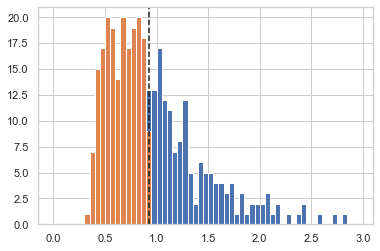

.85 quantile excluded: 0.1520


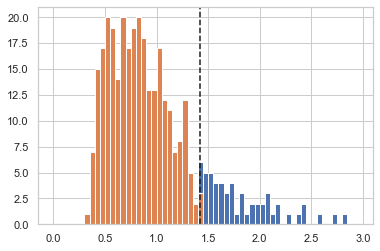

logXform > Z=1.64 excluded: 0.0643


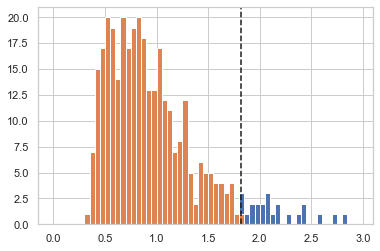

In [ ]:
# Example usage:
x = qaSummAll.distFromMedQAAll_lowmc.dropna()  # Your data here
result, split_point = compare_fits(x,[.5,2.5])
print(result)
if split_point is not None:
    print("Optimal split point:", split_point)

print("2-Gaussian split excluded: {:0.4f}".format(len(x[x>split_point])/len(x)))
histWithSplit(x,split_point)
print(".85 quantile excluded: {:0.4f}".format(len(x[x>x.quantile(.85)])/len(x)))
histWithSplit(x,x.quantile(.85))
print("logXform > Z=1.64 excluded: {:0.4f}".format(len(x[x>np.exp(np.mean(np.log(x))+np.std(np.log(x))*1.64)])/len(x)))
histWithSplit(x,np.exp(np.mean(np.log(x))+np.std(np.log(x))*1.64))

Two Gaussians are better fit
Optimal split point: 0.7100000000000002
2-Gaussian split excluded: 0.4115


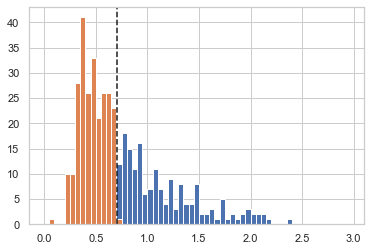

.85 quantile excluded: 0.1507


logXform > Z=1.64 excluded: 0.0646


In [ ]:
# Example usage:
x = qaSummAll.distFromMedQA_lowmc.dropna()  # Your data here
result, split_point = compare_fits(x, [.5,2.0])
print(result)
if split_point is not None:
    print("Optimal split point:", split_point)
    
print("2-Gaussian split excluded: {:0.4f}".format(len(x[x>split_point])/len(x)))
histWithSplit(x,split_point)
print(".85 quantile excluded: {:0.4f}".format(len(x[x>x.quantile(.85)])/len(x)))
histWithSplit(x,x.quantile(.85))
print("logXform > Z=1.64 excluded: {:0.4f}".format(len(x[x>np.exp(np.mean(np.log(x))+np.std(np.log(x))*1.64)])/len(x)))
histWithSplit(x,np.exp(np.mean(np.log(x))+np.std(np.log(x))*1.64))

Two Gaussians are better fit
Optimal split point: 0.6000000000000001
2-Gaussian split excluded: 0.4503


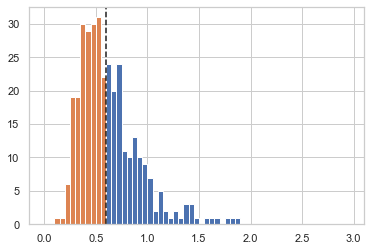

.85 quantile excluded: 0.1520


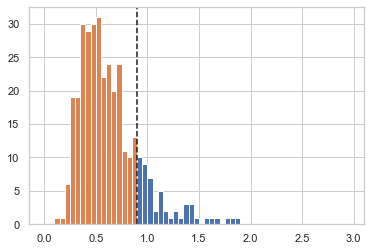

logXform > Z=1.64 excluded: 0.0526


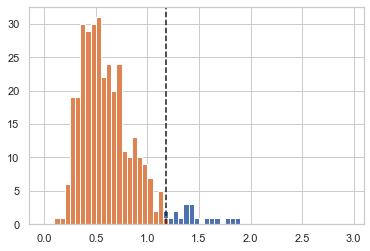

In [ ]:
# Example usage:
x = qaSummAll.distFromMedQAW2_lowmc.dropna()  # Your data here
result, split_point = compare_fits(x,[.5,1.5])
print(result)
if split_point is not None:
    print("Optimal split point:", split_point)
    
print("2-Gaussian split excluded: {:0.4f}".format(len(x[x>split_point])/len(x)))
histWithSplit(x,split_point)
print(".85 quantile excluded: {:0.4f}".format(len(x[x>x.quantile(.85)])/len(x)))
histWithSplit(x,x.quantile(.85))
print("logXform > Z=1.64 excluded: {:0.4f}".format(len(x[x>np.exp(np.mean(np.log(x))+np.std(np.log(x))*1.64)])/len(x)))
histWithSplit(x,np.exp(np.mean(np.log(x))+np.std(np.log(x))*1.64))

In [ ]:
rtDat=pd.DataFrame(index=lrnSumm.index)
for subj in lrnDat:
    subjID=subj.subject_id[0]
    rtDat.loc[subjID,'socRTmean']=subj[subj.trialtype=='decision'].rt.mean()
    rtDat.loc[subjID,'socRTmed']=subj[subj.trialtype=='decision'].rt.median()
    
for subj in rwlrnDat:
    subjID=subj.subject_id[0]
    rtDat.loc[subjID,'nsocRTmean']=subj[subj.trialtype=='decision'].rt.mean()
    rtDat.loc[subjID,'nsocRTmed']=subj[subj.trialtype=='decision'].rt.median()
    
rtDat['rtDiffMean']=rtDat.socRTmean-rtDat.nsocRTmean
rtDat['rtDiffMed']=rtDat.socRTmed-rtDat.nsocRTmed


In [ ]:
tmpRT=rtDat.loc[tmp.index,:]
for param in tmpRT.columns:
    print(param)
    for score in tmp.loc[:,'SCID_Score_Numeric':].columns:
    # for score in tmp.loc[:,(tmp.columns.str.endswith('Numeric') | tmp.columns.str.endswith('tot') | tmp.columns.str.endswith('total') | tmp.columns.str.startswith('RFQ') | tmp.columns.str.endswith('PID5_d') | tmp.columns.str.endswith('GSI') | tmp.columns.str.endswith('PDT') | tmp.columns.str.endswith('PSDI'))].columns:
        r,p=stats.pearsonr(tmpRT[param],tmp[score])
        if p < 0.05:
            print(f'{param} x {score}: r={r:0.2f}, p={p:0.3f}')

socRTmean
socRTmean x RSQ_Expectance: r=0.18, p=0.043
socRTmed
nsocRTmean
nsocRTmean x PID5_fSubmissiveness: r=0.18, p=0.039
nsocRTmed
rtDiffMean
rtDiffMean x PID5_fCallousness: r=-0.21, p=0.016
rtDiffMean x PID5_fGrandiosity: r=-0.17, p=0.050
rtDiffMean x CTQ_minDen: r=0.24, p=0.005
rtDiffMed
rtDiffMed x PID5_fCallousness: r=-0.21, p=0.016
rtDiffMed x PID5_fDeceitfulness: r=-0.20, p=0.026
rtDiffMed x PID5_fGrandiosity: r=-0.22, p=0.010
rtDiffMed x PID5_dAntagonism: r=-0.21, p=0.018


In [ ]:
(sldmModFits.distFromMedQA_lowMC_ltMADCutOff_goodSub==1) & (sldmModFits.distFromMedQAW2_lowMC_ltMADCutOff_goodSub==1)

PROLIFIC_PID
5f2f86864fd821374b4367bc    False
61492ac26b91b5b11ba2c88b    False
60234c1d5a0cf81cba76ce5d     True
6362aca86b740b1ec4cb6efb    False
60fcd2b146529d02f1566012     True
                            ...  
641359eb0e2dc93999637e35     True
63d2bc12a843f8466a8f83e0     True
610b416fd4f5d1dcfaa28d7a    False
63d9f31dba727de153019798    False
620bdd8ca922fc3f247f6c82    False
Length: 418, dtype: bool

In [ ]:
#CALCULATE SCID-II BPD SUMMSCORES FROM qDat
# qDat.loc[:,qDat.columns[qDat.columns[qDat.columns.str.startswith('SCID')].str.endswith('.1')]]
qDat.loc[:,[col for col in qDat.columns if re.match(r'SCID.*\.1', col)]].sum(axis=1)/12*3
# qDat.columns[qDat.columns.str.startswith('SCID')]

PROLIFIC_PID
5f2f86864fd821374b4367bc     6.50
61492ac26b91b5b11ba2c88b    25.50
60234c1d5a0cf81cba76ce5d     4.00
6362aca86b740b1ec4cb6efb     8.50
60fcd2b146529d02f1566012    23.50
                            ...  
641359eb0e2dc93999637e35    11.00
63d2bc12a843f8466a8f83e0    12.00
610b416fd4f5d1dcfaa28d7a    34.50
63d9f31dba727de153019798     1.00
620bdd8ca922fc3f247f6c82    21.25
Length: 418, dtype: float64

In [ ]:
summScores.PCL_Score_Numeric['60fcd2b146529d02f1566012']

119

In [ ]:
# qDat.loc['6362aca86b740b1ec4cb6efb',[col for col in qDat.columns if re.match(r'SCID.*\.1', col)]]
qDat.loc['60fcd2b146529d02f1566012',[col for col in qDat.columns if re.match(r'PCL5-.*.3', col)]].sum()

62.0

In [ ]:
stats.pearsonr(rwlrnSumm.dropna().subjLR_biasedOC, rwlrnSumm.dropna().SCID_Score_Numeric)
# lrnSumm.PCL_New_Score.dropna().shape

(-0.0691902351065852, 0.1715748666994705)

In [ ]:
initEst=lrnEstArr.groupby('PID').mean().mean(axis=1)
initEst.name='initEst'
tmp=tmp.join(initEst)

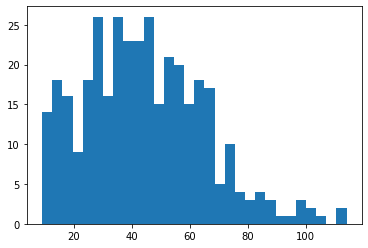

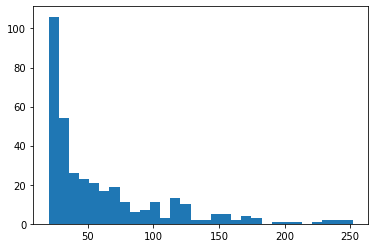

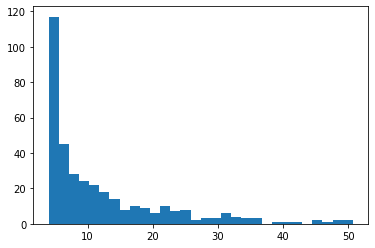

In [ ]:
plt.hist(tmp.SCID_Score_Numeric, bins=30)
plt.show()
plt.hist(tmp.SCID_New_Score, bins=30)
plt.show()


plt.hist(tmp.PCL_Score_Numeric, bins=30)
plt.show()
plt.hist(tmp.PCL_New_Score, bins=30)
plt.show()

In [ ]:
# newCols=tmp.columns.append('BSI_'+BSIDat.loc[:,'Somatization':].columns)
# tmp.columns=newCols

In [ ]:
for col in tmp.columns:
    r,p=stats.pearsonr(tmp.subjLR_biasedOC,tmp[col])
    print(f'{col}: r={r:0.2f}, p={p:0.3f}')

rat_mean: r=0.12, p=0.020
subjLR_biasedOC: r=1.00, p=0.000
SCID_Score_Numeric: r=-0.03, p=0.525
PCL_Score_Numeric: r=-0.08, p=0.115
SCID_New_Score: r=-0.03, p=0.547
PCL_New_Score: r=-0.09, p=0.104
rwsubjLR_biasedOC: r=0.50, p=0.000
BSI_Somatization: r=-0.01, p=0.867
BSI_Obsession-Compulsion: r=0.03, p=0.605
BSI_Interpersonal Sensitivity: r=-0.06, p=0.260
BSI_Depression: r=-0.05, p=0.389
BSI_Anxiety: r=-0.02, p=0.776
BSI_Hostility: r=-0.02, p=0.686
BSI_Phobic: r=-0.06, p=0.276
BSI_Paranoid Ideation: r=-0.05, p=0.383
BSI_Psychoticism: r=-0.02, p=0.652
BSI_GSI: r=-0.03, p=0.567
BSI_PDT: r=-0.01, p=0.856
BSI_PSDI: r=-0.05, p=0.310


In [ ]:
goodPtptsW1_AND_W2=qaSummAll.index[(qaSummAll.distFromMedQA_lowMC_ltMADCutOff_goodSub==1) & (qaSummAll.distFromMedQAW2_lowMC_ltMADCutOff_goodSub==1)]
goodPtptsW1_AND_W2=pd.DataFrame([], index=goodPtptsW1_AND_W2).join(tmp, how='inner').join(RSQDat.loc[:,'RSQtot':])

In [ ]:
for col in goodPtptsW1_AND_W2.loc[:,'RSQtot':].columns:
    r,p=stats.pearsonr(goodPtptsW1_AND_W2.subjLR,goodPtptsW1_AND_W2[col])
    print(f'{col}: r={r:0.2f}, p={p:0.3f}')

AttributeError: 'DataFrame' object has no attribute 'subjLR'

In [ ]:
plt.hist(tmp.PCL_Score_Numeric, bins=np.r_[0:260:10])
plt.show()
plt.hist(tmp.SCID_Score_Numeric, bins=np.r_[0:210:10])
plt.show()

In [ ]:
# fig,axs=plt.subplots(np.ceil(len(lrnDat)).astype(int),1, figsize=(18,100), sharey=False, facecolor='white')

# for subj,i in zip(lrnDat,range(len(lrnDat))):
#     currSubj=subj.subject_id[0]
#     currAx=i
#     tDat=subj.loc[subj.trialtype=='decision',['key_press', 'rt']].reset_index(drop=True).apply(pd.to_numeric)
#     # axs[currAx].axvspan(0,66,facecolor='y', alpha=0.4)
#     axs[currAx].axvspan(66,132,facecolor='gray', alpha=0.3)
#     axs[currAx].plot(tDat.key_press, '.', color='orange')
#     axs[currAx].plot(tDat.key_press[tDat.rt<300], '.', color='black')
#     axs[currAx].plot(tDat.key_press[tDat.rt<200], '.', color='magenta')

#     rt_pct=qaSumm.loc[currSubj,'lrn_qa:dec_%rt<300']
#     nConseqs=qaSumm.loc[currSubj,'lrn_qa:dec_%Conseqs']
# #     attnChks=qaSumm.loc[subj.subject_id[0],'PSWQ_5':'SAQ-A30_23'].sum()
#     subjLR=lrnSumm.loc[currSubj,'subjLR']
#     LRTp=lrnSumm.loc[currSubj,'subjLRTp']
#     if qaSumm.loc[currSubj,'distFromMedQA']>cutoff:
#         tCol='red'
#     else:
#         tCol='green'
        
#     axs[currAx].set_title('{}: rt%={:0.2f}, %Cons={:0.2f}, LRTp={:0.3f}\n OVERALL_LR: {:0.2f};'.format(currSubj[:5],rt_pct, nConseqs, LRTp, subjLR), color=tCol)
    
#     axs[currAx].set_ylim([.75,5.25])
#     axs[currAx].xaxis.set_ticklabels([])

# plt.savefig('results/first25_reg_220630_ResponseQA_plots.png')
# plt.show()

In [ ]:
# READ IN PILOT DATA (n=250) AND ANALYZE AUDIT SCORES
p1qDat=pd.read_csv('BPD+&+PTSD+Social+Learning_+Phase+1+-+Final_August+26,+2022_16.43_text.csv').drop(np.r_[0:2]).apply(pd.to_numeric, errors='ignore')
p1qDat=p1qDat[p1qDat.Finished=='True'].reset_index(drop=True)
p1auDat=p1qDat.loc[:,p1qDat.columns.str.contains('AUDIT')]
p1AUDIT=p1auDat.replace({'Never':0,'Monthly or less':1,
               '2 to 4 times a month':2,'2 to 3 times a week':3,
               '4 or more times a week':4,'1 or 2':0,'3 or 4':1,
               '5 or 6':2,'7 to 9':3,'10 or more':4,'Less than monthly':1,
               'Monthly':2,'Weekly':3,'Daily or almost daily':4,'Daily or mostly daily':4,np.nan:0,
               'No':0,'Yes, but not in the last year':2,'Yes, during the last year':4
              }).sum(axis=1)

________________________________________________________________________________


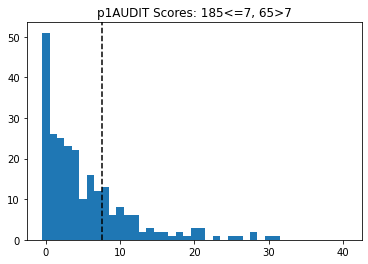

________________________________________________________________________________


In [ ]:
print('_' * term_size)
plt.hist(p1AUDIT, bins=np.r_[-0.5:41:1])
plt.axvline(7.5,linestyle="dashed", color='black')
plt.title('p1AUDIT Scores: {:d}<=7, {:d}>7'.format(np.sum(p1AUDIT<=7),np.sum(p1AUDIT>7)))
plt.show()
print('_' * term_size)


In [ ]:
bcDat[0][bcDat[0].trial_type=='html-slider-response'].trialtype.unique()

array(['decision', 'simRating', 'abilRating'], dtype=object)

In [ ]:
# for ptpt in bcDat

tmp1=list(bcDat[0][bcDat[0].trial_type=='html-slider-response'].sort_values(['trialtype', 'group']).response)
tmp2=list(bcDat[0][bcDat[0].trialtype=='decision'].sort_values(['group']).fraction.str[-3:].str.rstrip('%').astype(float)/100)
tmp1[5:10]+tmp2+tmp1[:5]+tmp1[10:]

[60.0,
 54.0,
 40.0,
 37.0,
 39.0,
 0.67,
 0.5,
 0.33,
 0.25,
 0.75,
 5.0,
 5.0,
 6.0,
 7.0,
 6.0,
 6.0,
 5.0,
 6.0,
 7.0,
 6.0]

In [ ]:
bcSumm.loc[bcDat[0].subject_id[0],:]

totalTime              209.473000
qa:prop_rt<300           0.000000
qa:prop_ConsecResps      0.214286
qa:instruxDur          132.500000
qa:blurEv                0.000000
Name: 63d6873b65a6170d64a652f6, dtype: float64

In [ ]:
bcDat[0][bcDat[0].trialtype=='decision'].sort_values(['group']).fraction.str[-3:].str.rstrip('%').astype(float)/100

6    0.67
7    0.50
8    0.33
9    0.25
5    0.75
Name: fraction, dtype: float64